In [1]:
from os import getcwd,listdir,chdir
home = getcwd()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch as mpatch
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
import seaborn as sns

from scipy.stats import zscore,pearsonr,ttest_ind,ttest_rel
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
from scipy.spatial import distance
from statsmodels.formula.api import ols
import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import ,LassoCV,LogisticRegressionCV
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from skbio.diversity import alpha,beta_diversity
from skbio.stats import composition
from sklearn.ensemble import RandomForestClassifier
from umap import UMAP

from tqdm.notebook import tqdm as progbar

sns.set(context='talk',style='ticks',font_scale=1,rc ={'axes.spines.right': False,'axes.spines.top': False,'pdf.fonttype':42,'ps.fonttype':42},palette='colorblind')

# Growth data

In [10]:
alm=pd.read_pickle('../data/David_et_al_growth_rates_tradeoff_final.pkl').reset_index()
alm_titr=pd.read_pickle('../data/David_et_al_growth_rates_cdiff_titr.pkl').reset_index()
alm=alm[(alm.tradeoff==0.8)&(alm.compartments!='community')]
alm_relgenus=pd.pivot_table(alm,index='sample',columns='compartments',values='abundance',fill_value=0)
shannon={}
otus={}
simpson={}
for smp,df in alm.groupby(by='sample'):
    df=df[~df.compartments.isin(['Clostridioides','community'])]
    df.abundance=df.abundance/df.abundance.sum()
    otus[smp]= alpha.observed_otus(df.abundance)
    simpson[smp]= alpha.simpson_e(df.abundance)
    shannon[smp]= alpha.shannon(df.abundance)
alm['dataset']='alm'
alm['shannon']=alm['sample'].map(shannon)
alm['otus']=alm['sample'].map(otus)
alm['simpson']=alm['sample'].map(simpson)
alm['log_growth']=np.log10(alm['growth_rate'])
alm['quantile']=pd.qcut(alm['shannon'],10)
alm_cdiff=alm[(alm.compartments=='Clostridioides')&(alm.tradeoff==0.8)]
alm_cdiff

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


compartments   growth_rate  abundance      sample  tradeoff dataset  \
3     Clostridioides  1.809791e-01   0.100038  DonorA-107       0.8     alm   
23    Clostridioides  8.671046e-02   0.100134  DonorA-118       0.8     alm   
43    Clostridioides  7.195813e-08   0.099946  DonorA-106       0.8     alm   
66    Clostridioides  9.963568e-02   0.099958  DonorA-116       0.8     alm   
89    Clostridioides  4.679460e-06   0.100000  DonorA-100       0.8     alm   
...              ...           ...        ...         ...       ...     ...   
8356  Clostridioides  3.648143e-13   0.100012    DonorB-9       0.8     alm   
8374  Clostridioides  1.987515e-12   0.099958   DonorB-98       0.8     alm   
8392  Clostridioides  4.637123e-04   0.100023   DonorB-93       0.8     alm   
8416  Clostridioides  8.976203e-13   0.100073   DonorB-96       0.8     alm   
8440  Clostridioides  1.105196e-07   0.100084   DonorB-97       0.8     alm   

       shannon  otus   simpson  log_growth                     quantile  
3     2.700621    16  0.302457   -0.742371               (2.679, 2.915]  
23    2.756515    18  0.237984   -1.061929               (2.679, 2.915]  
43    3.319035    22  0.282233   -7.142920               (3.257, 3.333]  
66    3.087114    20  0.263974   -1.001585                (3.071, 3.16]  
89    3.102340    20  0.275560   -5.329804                (3.071, 3.16]  
...        ...   ...       ...         ...                          ...  
8356  2.142144    14  0.205651  -12.437928  (1.3350000000000002, 2.384]  
8374  2.162297    17  0.174186  -11.701690  (1.3350000000000002, 2.384]  
8392  2.599846    19  0.211350   -3.333751               (2.384, 2.679]  
8416  2.792131    21  0.213018  -12.046907               (2.679, 2.915]  
8440  3.174050    22  0.258020   -6.956561                (3.16, 3.257]  

[391 rows x 11 columns]

In [2797]:
fmt=pd.read_pickle('../data/Weingarden_et_al_+cdiff_growth_rates_tradeoff_pfba.pkl')
fmt=fmt.reset_index()
fmt_relgenus=fmt.pivot_table(index='sample',columns='compartments',values='abundance',fill_value=0).drop(['community','Clostridioides'],axis=1)
fmt_relgenus=fmt_relgenus.divide(fmt_relgenus.sum(axis=1),axis=0)
shannon={}
otus={}
simpson={}
for smp,df in fmt.groupby(by='sample'):
    df=df[~df.compartments.isin(['Clostridioides','community'])]
    df.abundance=df.abundance/df.abundance.sum()
    otus[smp]= alpha.observed_otus(df.abundance)
    simpson[smp]= alpha.simpson_e(df.abundance)
    shannon[smp]= alpha.shannon(df.abundance)

fmt['shannon']=fmt['sample'].map(shannon)
fmt['otus']=fmt['sample'].map(otus)
fmt['simpson']=fmt['sample'].map(simpson)
fmt['dataset']='fmt'
fmt_cdiff['log_growth']=np.log10(fmt_cdiff['growth_rate'])
fmt_cdiff['quantile']=pd.qcut(fmt_cdiff['shannon'],10)
fmt_cdiff=fmt[fmt.compartments=='Clostridioides']
fmt_cdiff

/users/acarr/anaconda3/envs/micom/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


compartments   growth_rate  abundance             sample  tradeoff  \
1     Clostridioides  8.368364e-01   0.099844  1924.Sadowsky.14r       0.8   
15    Clostridioides  3.800861e-07   0.100678  1924.Sadowsky.15r       0.8   
31    Clostridioides  3.372752e-02   0.099903  1924.Sadowsky.12r       0.8   
56    Clostridioides  5.840250e-02   0.100727  1924.Sadowsky.111       0.8   
79    Clostridioides  3.223110e-07   0.100671  1924.Sadowsky.13r       0.8   
...              ...           ...        ...                ...       ...   
3161  Clostridioides  1.091756e-13   0.100320   1924.Sadowsky.96       0.8   
3186  Clostridioides  3.506263e-01   0.100956   1924.Sadowsky.82       0.8   
3216  Clostridioides  1.512006e-03   0.100000   1924.Sadowsky.9r       0.8   
3243  Clostridioides  3.192382e-11   0.100198   1924.Sadowsky.98       0.8   
3270  Clostridioides  6.233708e-05   0.100508   1924.Sadowsky.99       0.8   

       shannon  otus   simpson dataset  
1     1.025975    10  0.139875     fmt  
15    1.354140    10  0.167878     fmt  
31    2.626899    21  0.145091     fmt  
56    3.573829    20  0.472253     fmt  
79    3.727390    25  0.372939     fmt  
...        ...   ...       ...     ...  
3161  3.950224    23  0.537287     fmt  
3186  3.647777    29  0.256526     fmt  
3216  3.284107    24  0.219330     fmt  
3243  3.345372    24  0.259068     fmt  
3270  3.832906    26  0.372008     fmt  

[136 rows x 9 columns]

In [2805]:
murica= pd.read_pickle('../data/American_gut_growth_rates_tradeoff.pkl')
murica_relgenus=pd.pivot_table(murica_cdiff,index='sample',columns='compartments',values='abundance',fill_value=0)
shannon={}
otus={}
simpson={}
for smp,df in murica.groupby(by='sample'):
    df=df[~df.compartments.isin(['Clostridioides','community'])]
    df.abundance=df.abundance/df.abundance.sum()
    otus[smp]= alpha.observed_otus(df.abundance)
    simpson[smp]= alpha.simpson_e(df.abundance)
    shannon[smp]= alpha.shannon(df.abundance)
murica['shannon']=murica['sample'].map(shannon)
murica['otus']=murica['sample'].map(otus)
murica['simpson']=murica['sample'].map(simpson)
murica['log_growth']=np.log10(murica.growth_rate)
murica['quantile']=pd.qcut(murica['shannon'],10)
murica['dataset']='murica'
murica_cdiff=murica_cdiff[(murica_cdiff.compartments=='Clostridioides')&(murica_cdiff.abundance>.05)&(murica_cdiff.tradeoff==0.8)]
murica_cdiff

/users/acarr/anaconda3/envs/micom/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


compartments   growth_rate  abundance           sample  tradeoff  \
1       Clostridioides  7.977864e-02   0.100775  10317.000001067       0.8   
12      Clostridioides  3.456198e-01   0.101227  10317.000001001       0.8   
32      Clostridioides  2.402423e-06   0.101370  10317.000001079       0.8   
49      Clostridioides  2.535669e-02   0.100189  10317.000001008       0.8   
63      Clostridioides  4.323647e-13   0.100616  10317.000001002       0.8   
...                ...           ...        ...              ...       ...   
242294  Clostridioides  1.241931e-08   0.100100  10317.000071481       0.8   
242320  Clostridioides  1.367980e-01   0.101083  10317.000071438       0.8   
242353  Clostridioides  6.600007e-06   0.100906  10317.000071418       0.8   
242381  Clostridioides  1.725038e-07   0.101176  10317.000071429       0.8   
242415  Clostridioides  1.787083e-01   0.100580  10317.000071428       0.8   

       dataset   shannon  otus   simpson  log_growth        quantile  
1       murica  1.076384     4  0.466176   -1.098113   (0.13, 2.479]  
12      murica  3.217343    19  0.349327   -0.461401  (3.135, 3.272]  
32      murica  2.630253    15  0.281012   -5.619350  (2.479, 2.796]  
49      murica  2.083311    14  0.224158   -1.595907   (0.13, 2.479]  
63      murica  1.821468    16  0.124122  -12.364150   (0.13, 2.479]  
...        ...       ...   ...       ...         ...             ...  
242294  murica  3.086816    26  0.207014   -7.905903  (2.987, 3.135]  
242320  murica  3.847940    29  0.332114   -0.863920   (3.834, 4.69]  
242353  murica  3.652850    27  0.270824   -5.180456  (3.649, 3.834]  
242381  murica  3.904722    30  0.314474   -6.763201   (3.834, 4.69]  
242415  murica  3.412672    33  0.196144   -0.747855  (3.398, 3.523]  

[9494 rows x 11 columns]

In [11]:
arivale=pd.read_pickle('../data/Arivale_cdiff_growth_rates_tradeoff_pfba.pkl').reset_index()
shannon={}
otus={}
simpson={}
for smp,df in arivale.groupby(by='sample'):
    df=df[~df.compartments.isin(['Clostridioides','community'])]
    df.abundance=df.abundance/df.abundance.sum()
    otus[smp]= alpha.observed_otus(df.abundance)
    simpson[smp]= alpha.simpson_e(df.abundance)
    shannon[smp]= alpha.shannon(df.abundance)

arivale['shannon']=arivale['sample'].map(shannon)
arivale['otus']=arivale['sample'].map(otus)
arivale['simpson']=arivale['sample'].map(simpson)
arivale['log_growth']=np.log10(arivale['growth_rate'])
arivale['quantile']=pd.qcut(arivale['shannon'],10)
arivale['dataset']='arivale'
arivale_cdiff=arivale[arivale.compartments=='Clostridioides']
arivale_cdiff

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


compartments   growth_rate  abundance                       sample  \
2       Clostridioides  5.107642e-02   0.100148  22001612560033|GFM-1079-001   
14      Clostridioides  1.198525e-01   0.100023  22001612560015|GFM-1079-015   
30      Clostridioides  2.649423e-01   0.099917  22001612560045|GFM-1079-021   
53      Clostridioides  1.772731e-07   0.100177  22001612560020|GFM-1079-003   
76      Clostridioides  2.304020e-01   0.100398  22001612560012|GFM-1079-011   
...                ...           ...        ...                          ...   
136515  Clostridioides  1.131604e-11   0.099936             AV15-4376|AKE035   
136545  Clostridioides  1.417002e-01   0.100023                  QIRL|AKE014   
136567  Clostridioides  2.756182e-06   0.100024             AV15-4379|AKE036   
136595  Clostridioides  1.745178e-01   0.099904                NEBZ-2|AKE016   
136624  Clostridioides  3.525035e-02   0.099931                QIRL-2|AKE014   

        tradeoff   shannon  otus   simpson  log_growth        quantile  \
2            0.8  0.642374     8  0.149216   -1.291780  (0.488, 2.945]   
14           0.8  2.213065    13  0.227291   -0.921353  (0.488, 2.945]   
30           0.8  3.364806    21  0.353570   -0.576849   (3.203, 3.37]   
53           0.8  2.258554    21  0.147970   -6.751357  (0.488, 2.945]   
76           0.8  3.247414    21  0.340962   -0.637514   (3.203, 3.37]   
...          ...       ...   ...       ...         ...             ...   
136515       0.8  3.599907    28  0.281907  -10.946305  (3.581, 3.666]   
136545       0.8  3.711205    19  0.545091   -0.848630  (3.666, 3.744]   
136567       0.8  3.640894    25  0.339461   -5.559692  (3.581, 3.666]   
136595       0.8  3.737364    27  0.376480   -0.758160  (3.666, 3.744]   
136624       0.8  2.984695    23  0.175883   -1.452837  (2.945, 3.203]   

        dataset  
2       arivale  
14      arivale  
30      arivale  
53      arivale  
76      arivale  
...         ...  
136515  arivale  
136545  arivale  
136567  arivale  
136595  arivale  
136624  arivale  

[5230 rows x 11 columns]

In [2800]:
combined=pd.concat([murica_cdiff,alm_cdiff,fmt_cdiff,arivale_cdiff],ignore_index=True)
combined

compartments   growth_rate  abundance            sample  tradeoff  \
0      Clostridioides  7.977864e-02   0.100775   10317.000001067       0.8   
1      Clostridioides  3.456198e-01   0.101227   10317.000001001       0.8   
2      Clostridioides  2.402423e-06   0.101370   10317.000001079       0.8   
3      Clostridioides  2.535669e-02   0.100189   10317.000001008       0.8   
4      Clostridioides  4.323647e-13   0.100616   10317.000001002       0.8   
...               ...           ...        ...               ...       ...   
15248  Clostridioides  1.131604e-11   0.099936  AV15-4376|AKE035       0.8   
15249  Clostridioides  1.417002e-01   0.100023       QIRL|AKE014       0.8   
15250  Clostridioides  2.756182e-06   0.100024  AV15-4379|AKE036       0.8   
15251  Clostridioides  1.745178e-01   0.099904     NEBZ-2|AKE016       0.8   
15252  Clostridioides  3.525035e-02   0.099931     QIRL-2|AKE014       0.8   

       dataset   shannon  otus   simpson  log_growth        quantile  
0       murica  1.076384     4  0.466176   -1.098113   (0.13, 2.479]  
1       murica  3.217343    19  0.349327   -0.461401  (3.135, 3.272]  
2       murica  2.630253    15  0.281012   -5.619350  (2.479, 2.796]  
3       murica  2.083311    14  0.224158   -1.595907   (0.13, 2.479]  
4       murica  1.821468    16  0.124122  -12.364150   (0.13, 2.479]  
...        ...       ...   ...       ...         ...             ...  
15248  arivale  3.599907    28  0.281907  -10.946305  (3.581, 3.666]  
15249  arivale  3.711205    19  0.545091   -0.848630  (3.666, 3.744]  
15250  arivale  3.640894    25  0.339461   -5.559692  (3.581, 3.666]  
15251  arivale  3.737364    27  0.376480   -0.758160  (3.666, 3.744]  
15252  arivale  2.984695    23  0.175883   -1.452837  (2.945, 3.203]  

[15253 rows x 11 columns]

In [2816]:
all_combined=pd.concat([murica,alm,fmt,arivale],ignore_index=True)
all_combined

compartments  growth_rate  abundance           sample  tradeoff  \
0          Brevundimonas     0.001656   0.002215  10317.000001067       0.8   
1         Clostridioides     0.079779   0.100775  10317.000001067       0.8   
2                Delftia     0.217591   0.274640  10317.000001067       0.8   
3       Sphingobacterium     0.019420   0.024363  10317.000001067       0.8   
4       Stenotrophomonas     0.474661   0.598007  10317.000001067       0.8   
...                  ...          ...        ...              ...       ...   
380935       Phocaeicola     0.221028   0.029271    QIRL-2|AKE014       0.8   
380936         Roseburia     0.007843   0.004116    QIRL-2|AKE014       0.8   
380937      Ruminococcus     0.006319   0.022639    QIRL-2|AKE014       0.8   
380938     Streptococcus     0.000975   0.008461    QIRL-2|AKE014       0.8   
380939         community     0.394058   1.000000    QIRL-2|AKE014       0.8   

        dataset   shannon  otus   simpson  log_growth        quantile  
0        murica  1.076384     4  0.466176   -2.781051   (0.13, 2.479]  
1        murica  1.076384     4  0.466176   -1.098113   (0.13, 2.479]  
2        murica  1.076384     4  0.466176   -0.662359   (0.13, 2.479]  
3        murica  1.076384     4  0.466176   -1.711756   (0.13, 2.479]  
4        murica  1.076384     4  0.466176   -0.323616   (0.13, 2.479]  
...         ...       ...   ...       ...         ...             ...  
380935  arivale  2.984695    23  0.175883   -0.655553  (2.945, 3.203]  
380936  arivale  2.984695    23  0.175883   -2.105514  (2.945, 3.203]  
380937  arivale  2.984695    23  0.175883   -2.199382  (2.945, 3.203]  
380938  arivale  2.984695    23  0.175883   -3.010959  (2.945, 3.203]  
380939  arivale  2.984695    23  0.175883   -0.404440  (2.945, 3.203]  

[380940 rows x 11 columns]

# Growth rate assocations and prediction

In [ ]:
growth_rates=all_combined[all_combined.dataset=='fmt'].pivot(index='sample',columns='compartments',values='growth_rate')
growth_rates=growth_rates.fillna(0)
growth_rates

compartments       Clostridioides
sample                           
1924.Sadowsky.10     2.646780e-01
1924.Sadowsky.100    1.490552e-07
1924.Sadowsky.101    2.612184e-12
1924.Sadowsky.102    7.298885e-12
1924.Sadowsky.103    1.394871e-12
...                           ...
1924.Sadowsky.96     1.091756e-13
1924.Sadowsky.97     7.036110e-09
1924.Sadowsky.98     3.192382e-11
1924.Sadowsky.99     6.233708e-05
1924.Sadowsky.9r     1.512006e-03

[136 rows x 1 columns]

In [2632]:
X=all_combined[all_combined.dataset=='fmt'].pivot(index='sample',columns='compartments',values='abundance').fillna(0)
X

compartments       Acidaminococcus  Acinetobacter  Actinomyces  Adlercreutzia  \
sample                                                                          
1924.Sadowsky.10          0.000000       0.000000          0.0        0.00000   
1924.Sadowsky.100         0.009657       0.000000          0.0        0.00000   
1924.Sadowsky.101         0.008122       0.012183          0.0        0.00000   
1924.Sadowsky.102         0.004197       0.000000          0.0        0.00000   
1924.Sadowsky.103         0.030939       0.000000          0.0        0.00221   
...                            ...            ...          ...            ...   
1924.Sadowsky.96          0.007471       0.000000          0.0        0.00000   
1924.Sadowsky.97          0.000000       0.000000          0.0        0.00000   
1924.Sadowsky.98          0.001984       0.000000          0.0        0.00000   
1924.Sadowsky.99          0.012183       0.000000          0.0        0.00000   
1924.Sadowsky.9r          0.004348       0.000000          0.0        0.00000   

compartments       Aeromonas  Aggregatibacter  Akkermansia  Alistipes  \
sample                                                                  
1924.Sadowsky.10         0.0              0.0     0.000000   0.018124   
1924.Sadowsky.100        0.0              0.0     0.032189   0.022532   
1924.Sadowsky.101        0.0              0.0     0.020305   0.029442   
1924.Sadowsky.102        0.0              0.0     0.049318   0.070304   
1924.Sadowsky.103        0.0              0.0     0.046409   0.039779   
...                      ...              ...          ...        ...   
1924.Sadowsky.96         0.0              0.0     0.070438   0.032017   
1924.Sadowsky.97         0.0              0.0     0.049000   0.039000   
1924.Sadowsky.98         0.0              0.0     0.028770   0.030754   
1924.Sadowsky.99         0.0              0.0     0.035533   0.010152   
1924.Sadowsky.9r         0.0              0.0     0.027174   0.054348   

compartments       Amedibacillus  Anaerobutyricum  ...  Ruminococcus  \
sample                                             ...                 
1924.Sadowsky.10             0.0         0.021322  ...      0.053305   
1924.Sadowsky.100            0.0         0.007511  ...      0.035408   
1924.Sadowsky.101            0.0         0.016244  ...      0.017259   
1924.Sadowsky.102            0.0         0.010493  ...      0.014690   
1924.Sadowsky.103            0.0         0.018785  ...      0.013260   
...                          ...              ...  ...           ...   
1924.Sadowsky.96             0.0         0.029883  ...      0.084312   
1924.Sadowsky.97             0.0         0.010000  ...      0.054000   
1924.Sadowsky.98             0.0         0.006944  ...      0.002976   
1924.Sadowsky.99             0.0         0.019289  ...      0.039594   
1924.Sadowsky.9r             0.0         0.011957  ...      0.014130   

compartments       Schaalia  Selenomonas  Staphylococcus  Streptococcus  \
sample                                                                    
1924.Sadowsky.10        0.0          0.0             0.0       0.012793   
1924.Sadowsky.100       0.0          0.0             0.0       0.000000   
1924.Sadowsky.101       0.0          0.0             0.0       0.003046   
1924.Sadowsky.102       0.0          0.0             0.0       0.002099   
1924.Sadowsky.103       0.0          0.0             0.0       0.002210   
...                     ...          ...             ...            ...   
1924.Sadowsky.96        0.0          0.0             0.0       0.000000   
1924.Sadowsky.97        0.0          0.0             0.0       0.000000   
1924.Sadowsky.98        0.0          0.0             0.0       0.000000   
1924.Sadowsky.99        0.0          0.0             0.0       0.004061   
1924.Sadowsky.9r        0.0          0.0             0.0       0.000000   

compartments       Subdoligranulum  Sutterella  Terrisporobacter  Tyzzerella  \
sam

(array([6981.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0., 8272.]),
 array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
        0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
        0.88, 0.92, 0.96, 1.  ]),
 <BarContainer object of 25 artists>)

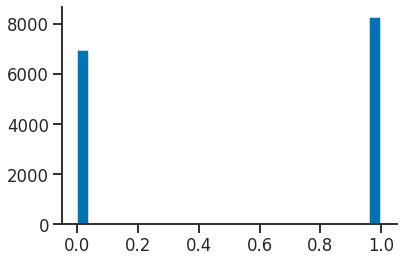

In [512]:
thresh=-3
Y=np.log10(growth_rates['Clostridioides'].values)
Y[Y>=thresh]=1
Y[Y<thresh]=0
plt.hist(Y,bins=25)

In [573]:
clr['Y']=Y
cols=clr.columns[clr.count()/clr.shape[0]>=.1]
train=clr.sample(frac=.7)[cols]
test=clr[~clr.index.isin(train.index)][cols]
train

compartments                 Akkermansia  Alistipes  Anaerobutyricum  \
1924.Sadowsky.73                     NaN        NaN         1.080184   
10317.000018442                      NaN  -0.274018        -1.062476   
22001612561341|GFM-1079-010    -0.492593  -0.087128        -1.098729   
AV15-3900|AKE028                     NaN  -2.036945        -0.022042   
10317.000007158                 1.588836   1.838052        -0.589696   
...                                  ...        ...              ...   
10317.000010264                -1.772838   1.117534        -1.367373   
10317.000038356                      NaN   2.795597              NaN   
10317.000063039                      NaN  -1.738198        -0.639586   
10317.000003150                      NaN        NaN              NaN   
10317.000030114                      NaN   1.406681        -0.855082   

compartments                 Anaerostipes  Bacteroides  Bifidobacterium  \
1924.Sadowsky.73                -1.890230    -1.890230        -1.484765   
10317.000018442                 -0.106964     2.498570         0.824594   
22001612561341|GFM-1079-010     -0.165909     1.450065         0.575248   
AV15-3900|AKE028                 0.214347     1.683918         2.616063   
10317.000007158                 -0.772018     3.025716              NaN   
...                                   ...          ...              ...   
10317.000010264                 -0.520075     1.425835              NaN   
10317.000038356                 -1.462377     2.183942        -0.258405   
10317.000063039                       NaN     2.957726        -1.332733   
10317.000003150                 -0.546220     1.087910         1.325582   
10317.000030114                 -1.771372     1.090828        -0.672760   

compartments                  Blautia  Coprococcus  Dialister     Dorea  ...  \
1924.Sadowsky.73             1.621315    -0.973939        NaN  0.882359  ...   
10317.000018442              0.161300    -1.978766        NaN       NaN  ...   
22001612561341|GFM-1079-010  0.876509     1.558028        NaN  0.493902  ...   
AV15-3900|AKE028             1.691155    -2.260088        NaN  0.414060  ...   
10317.000007158              0.103451          NaN        NaN       NaN  ...   
...                               ...          ...        ...       ...  ...   
10317.000010264              0.478454     0.669509        NaN       NaN  ...   
10317.000038356              0.272224          NaN        NaN       NaN  ...   
10317.000063039              0.704149    -1.332733   0.787530 -1.738198  ...   
10317.000003150              0.870846          NaN   2.110536       NaN  ...   
10317.000030114              0.626523    -0.267295   2.843748 -0.855082  ...   

compartments                 Clostridium  Collinsella  Corynebacterium  \
1924.Sadowsky.73                0.552117    -0.185482              NaN   
10317.000018442                      NaN          NaN              NaN   
22001612561341|GFM-1079-010    -0.875585    -0.057275              NaN   
AV15-3900|AKE028               -2.393620    -0.049071              NaN   
10317.000007158                -0.995161          NaN              NaN   
...                                  ...          ...              ...   
10317.000010264                -0.856547          NaN              NaN   
10317.000038356                -1.867843    -1.174695              NaN   
10317.000063039                -0.234121          NaN              NaN   
10317.000003150                      NaN          NaN          1.08791   
10317.000030114                 0.902776          NaN              NaN   

compartments                 Haemophilus  Veillonella  Holdemanella  \
1924.Sadowsky.73               -0.098471     0.594676           NaN   
10317.000018442                      NaN          NaN           NaN   
22001612561341|GFM-1079-010          NaN          NaN      -1.18574   
AV15-3900|AKE028                     NaN          NaN           NaN   
10317.000007158              

In [2464]:
#clr['Y']=Y
#cols=growth_rates.columns[growth_rates[growth_rates>0].count()/growth_rates.shape[0]>=.1]
train=growth_rates.sample(frac=.7)
test=growth_rates[~growth_rates.index.isin(train.index)]
train=np.log10(train[train>0]).fillna(-6)
test=np.log10(test[test>0]).fillna(-6)
train

compartments       Acidaminococcus  Acinetobacter  Actinomyces  Adlercreutzia  \
sample                                                                          
1924.Sadowsky.16         -6.000000      -0.484936         -6.0      -6.000000   
1924.Sadowsky.31r        -6.000000      -6.000000         -6.0      -6.000000   
1924.Sadowsky.73         -6.000000      -6.000000         -6.0      -6.000000   
1924.Sadowsky.100        -7.882522      -6.000000         -6.0      -6.000000   
1924.Sadowsky.6r         -0.307446      -6.000000         -6.0      -6.000000   
...                            ...            ...          ...            ...   
1924.Sadowsky.27r        -6.000000      -6.000000         -6.0      -6.000000   
1924.Sadowsky.16r        -1.645612      -6.000000         -6.0      -1.373676   
1924.Sadowsky.63         -6.000000      -6.000000         -6.0      -6.000000   
1924.Sadowsky.36         -0.887550      -6.000000         -6.0      -6.000000   
1924.Sadowsky.48         -6.000000      -6.000000         -6.0      -6.000000   

compartments       Aeromonas  Aggregatibacter  Akkermansia  Alistipes  \
sample                                                                  
1924.Sadowsky.16   -6.000000             -6.0    -6.000000   0.110740   
1924.Sadowsky.31r  -1.351935             -6.0    -6.000000  -6.000000   
1924.Sadowsky.73   -6.000000             -6.0    -6.000000  -6.000000   
1924.Sadowsky.100  -6.000000             -6.0    -7.881584   0.065130   
1924.Sadowsky.6r   -6.000000             -6.0    -6.000000   0.012840   
...                      ...              ...          ...        ...   
1924.Sadowsky.27r  -6.000000             -6.0    -6.000000  -6.000000   
1924.Sadowsky.16r  -6.000000             -6.0    -6.581141  -0.013968   
1924.Sadowsky.63   -6.000000             -6.0    -6.630229  -0.320759   
1924.Sadowsky.36   -6.000000             -6.0    -6.000000  -0.123774   
1924.Sadowsky.48   -6.000000             -6.0    -7.599120  -0.277805   

compartments       Amedibacillus  Anaerobutyricum  ...  Ruminococcus  \
sample                                             ...                 
1924.Sadowsky.16            -6.0        -1.245987  ...     -2.627206   
1924.Sadowsky.31r           -6.0        -6.000000  ...     -6.000000   
1924.Sadowsky.73            -6.0        -0.423924  ...     -3.055440   
1924.Sadowsky.100           -6.0        -7.858809  ...     -1.917930   
1924.Sadowsky.6r            -6.0       -11.555872  ...    -11.844758   
...                          ...              ...  ...           ...   
1924.Sadowsky.27r           -6.0        -6.000000  ...     -6.000000   
1924.Sadowsky.16r           -6.0        -1.065338  ...     -1.057055   
1924.Sadowsky.63            -6.0        -2.109315  ...     -1.409220   
1924.Sadowsky.36            -6.0        -6.805969  ...     -2.325217   
1924.Sadowsky.48            -6.0        -1.570182  ...     -1.284118   

compartments       Schaalia  Selenomonas  Staphylococcus  Streptococcus  \
sample                                                                    
1924.Sadowsky.16       -6.0         -6.0       -6.000000      -7.328100   
1924.Sadowsky.31r      -6.0         -6.0       -6.000000      -2.582907   
1924.Sadowsky.73       -6.0         -6.0       -4.930218      -5.319784   
1924.Sadowsky.100      -6.0         -6.0       -6.000000      -6.000000   
1924.Sadowsky.6r       -6.0         -6.0       -6.000000      -6.000000   
...                     ...          ...             ...            ...   
1924.Sadowsky.27r      -6.0         -6.0       -6.000000      -6.000000   
1924.Sadowsky.16r      -6.0         -6.0       -6.000000      -6.000000   
1924.Sadowsky.63       -6.0         -6.0       -6.000000      -6.000000   
1924.Sadowsky.36       -6.0         -6.0       -6.000000      -6.000000   
1924.Sadowsky.48       -6.0         -6.0       -6.000000      -6.000000   

compartments       Subdoligranulum  Sutterella  Terrisporobacter  Tyzzerella  \
sam

In [2465]:
#cols=X.columns[X[X>0].count()/X.shape[0]>=.1]
train=X.sample(frac=.7)
test=X[~X.index.isin(train.index)]
train=np.log10(train[train>0]).fillna(-3)
test=np.log10(test[test>0]).fillna(-3)
train

compartments       Acidaminococcus  Acinetobacter  Actinomyces  Adlercreutzia  \
sample                                                                          
1924.Sadowsky.18r        -2.710540      -3.000000         -3.0      -3.000000   
1924.Sadowsky.85         -3.000000      -3.000000         -3.0      -3.000000   
1924.Sadowsky.30         -3.000000      -3.000000         -3.0      -2.504697   
1924.Sadowsky.103        -1.509491      -3.000000         -3.0      -2.655619   
1924.Sadowsky.15r        -3.000000      -3.000000         -3.0      -3.000000   
...                            ...            ...          ...            ...   
1924.Sadowsky.108        -1.803457      -3.000000         -3.0      -3.000000   
1924.Sadowsky.7          -2.671173      -2.273233         -3.0      -2.671173   
1924.Sadowsky.78         -1.409979      -3.000000         -3.0      -3.000000   
1924.Sadowsky.56         -3.000000      -3.000000         -3.0      -3.000000   
1924.Sadowsky.95         -2.528917      -3.000000         -3.0      -3.000000   

compartments       Aeromonas  Aggregatibacter  Akkermansia  Alistipes  \
sample                                                                  
1924.Sadowsky.18r       -3.0        -3.000000    -1.467502  -1.467502   
1924.Sadowsky.85        -3.0        -3.000000    -3.000000  -3.000000   
1924.Sadowsky.30        -3.0        -3.000000    -3.000000  -2.078729   
1924.Sadowsky.103       -3.0        -3.000000    -1.333399  -1.400346   
1924.Sadowsky.15r       -3.0        -3.000000    -3.000000  -3.000000   
...                      ...              ...          ...        ...   
1924.Sadowsky.108       -3.0        -3.000000    -1.581608  -1.461034   
1924.Sadowsky.7         -3.0        -2.273233    -3.000000  -1.610475   
1924.Sadowsky.78        -3.0        -3.000000    -1.108949  -1.616453   
1924.Sadowsky.56        -3.0        -3.000000    -1.743141  -1.468440   
1924.Sadowsky.95        -3.0        -3.000000    -1.414973  -1.426254   

compartments       Amedibacillus  Anaerobutyricum  ...  Ruminococcus  \
sample                                             ...                 
1924.Sadowsky.18r           -3.0        -2.011570  ...     -1.398787   
1924.Sadowsky.85            -3.0        -3.000000  ...     -3.000000   
1924.Sadowsky.30            -3.0        -1.379759  ...     -1.101005   
1924.Sadowsky.103           -3.0        -1.726200  ...     -1.877467   
1924.Sadowsky.15r           -3.0        -3.000000  ...     -3.000000   
...                          ...              ...  ...           ...   
1924.Sadowsky.108           -3.0        -1.833420  ...     -1.435480   
1924.Sadowsky.7             -3.0        -1.629780  ...     -0.637749   
1924.Sadowsky.78            -3.0        -1.434112  ...     -1.898999   
1924.Sadowsky.56            -3.0        -1.743141  ...     -1.672560   
1924.Sadowsky.95            -3.0        -2.102948  ...     -1.750765   

compartments       Schaalia  Selenomonas  Staphylococcus  Streptococcus  \
sample                                                                    
1924.Sadowsky.18r      -3.0         -3.0            -3.0      -2.710540   
1924.Sadowsky.85       -3.0         -3.0            -3.0      -3.000000   
1924.Sadowsky.30       -3.0         -3.0            -3.0      -2.203667   
1924.Sadowsky.103      -3.0         -3.0            -3.0      -2.655619   
1924.Sadowsky.15r      -3.0         -3.0            -3.0      -3.000000   
...                     ...          ...             ...            ...   
1924.Sadowsky.108      -3.0         -3.0            -3.0      -3.000000   
1924.Sadowsky.7        -3.0         -3.0            -3.0      -2.370143   
1924.Sadowsky.78       -3.0         -3.0            -3.0      -2.279211   
1924.Sadowsky.56       -3.0         -3.0            -3.0      -2.371530   
1924.Sadowsky.95       -3.0         -3.0            -3.0      -3.000000   

compartments       Subdoligranulum  Sutterella  Terrisporobacter  Tyzzerella  \
sam

In [2466]:
Y=np.log10(growth_rates.Clostridioides)
Y[Y<-6]=-6

Y_test=Y[test.index].values
Y_train=Y[train.index].values

X_test=test.drop('Clostridioides',axis=1).values
X_train=train.drop('Clostridioides',axis=1).values

In [2670]:
X_train=growth_rates.loc[train.index]
X_train=np.log10(X_train[X_train>0]).fillna(-6)

X_test=growth_rates.loc[test.index]
X_test=np.log10(X_test[X_test>0]).fillna(-6)

In [2649]:
days=fmt_meta[fmt_meta.sample_name.isin(df.index)][['day_relative_to_fmt','sample_name']]
days.index=days.sample_name
days.day_relative_to_fmt=[x if x not in d else d[x] for x in days.day_relative_to_fmt]
days.day_relative_to_fmt=days.day_relative_to_fmt.astype(int)
days.drop('sample_name',axis=1,inplace=True)

Y=days

Y_test=Y.loc[test.index].values
Y_train=Y.loc[train.index].values



In [579]:
X_test=test.drop('Clostridioides',axis=1).fillna(-4).values
X_train=train.drop('Clostridioides',axis=1).fillna(-4).values

Y_test=test.Clostridioides.values
Y_train=train.Clostridioides.values

In [430]:
from sklearn.linear_model import Lasso,LassoCV,LogisticRegression

In [2673]:
alphas=np.linspace(10**-3,10,20)
train_err=[]
test_err=[]
test_corr=[]
for a in progbar(alphas):
    lasso=Lasso(max_iter=10000,alpha=a)
    lasso.fit(X_train,Y_train)
    Y_pred_train=lasso.predict(X_train)
    Y_pred_test=lasso.predict(X_test)
    train_err.append(pearsonr(Y_pred_train,Y_train)[0])
    test_err.append(pearsonr(Y_pred_test,Y_test)[0])
test_err=np.array(test_err)
train_err=np.array(train_err)

  0%|          | 0/20 [00:00<?, ?it/s]

/users/acarr/anaconda3/envs/micom/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4133.023585947402, tolerance: 11.868048421052633
  positive)


In [2476]:
lasso=Lasso(max_iter=10000,alpha=1.2)
lasso.fit(X_train,Y_train)
Y_pred_train=lasso.predict(X_train)
Y_pred_test=lasso.predict(X_test)

pearsonr(Y_pred_test,Y_test)

(0.6102810930766309, 2.2696528748931653e-05)

In [2456]:
lasso=Lasso(max_iter=10000,alpha=3)
lasso.fit(X,Y)
Y_pred=lasso.predict(X)

pearsonr(Y_pred,Y)

/users/acarr/anaconda3/envs/micom/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


(nan, nan)

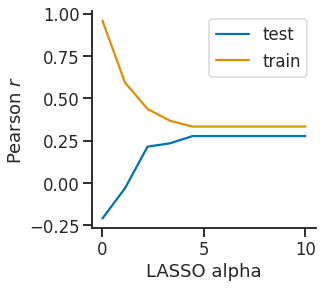

In [2653]:
#abundances
plt.figure(figsize=(4,4))
plt.plot(alphas,test_err,label='test')
plt.plot(alphas,train_err,label='train')
plt.xlabel('LASSO alpha')
plt.ylabel('Pearson $r$')
plt.legend()


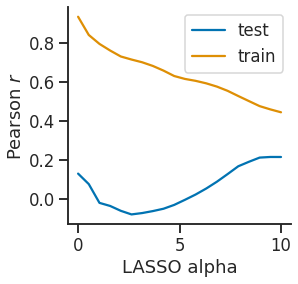

In [2674]:
#log growth
plt.figure(figsize=(4,4))
plt.plot(alphas,test_err,label='test')
plt.plot(alphas,train_err,label='train')
plt.xlabel('LASSO alpha')
plt.ylabel('Pearson $r$')
plt.legend()

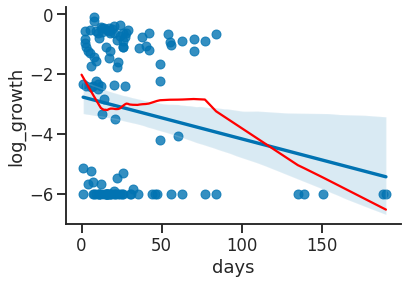

In [2691]:
sns.regplot(x='days',y='log_growth',data=df[df.days>0])
lowess = sm.nonparametric.lowess
fit=lowess(df[df.days>=0].log_growth,df[df.days>=0].days)
plt.plot(fit[:,0],fit[:,1],color='red')

/users/acarr/anaconda3/envs/micom/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, '$R^2=0.37$')

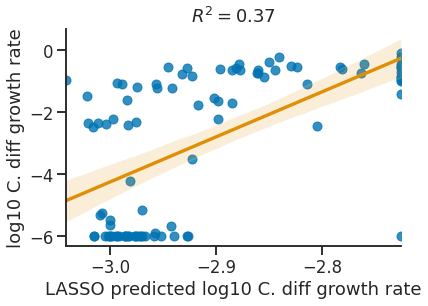

In [2477]:
sns.regplot(Y_pred_train,Y_train,fit_reg=False)
sns.regplot(Y_pred_train,Y_train,scatter=False)

lowess = sm.nonparametric.lowess
fit=lowess(Y_pred_train,Y_train)
#plt.plot(fit[:,0],fit[:,1],color='red')
plt.xlim(min(Y_pred_train),max(Y_pred_train))
fit2=linregress(Y_pred_test,Y_test)
plt.xlabel('LASSO predicted log10 C. diff growth rate')
plt.ylabel('log10 C. diff growth rate')
plt.title('$R^2=%s$'%((fit2.rvalue**2).round(2)))

# Global trends

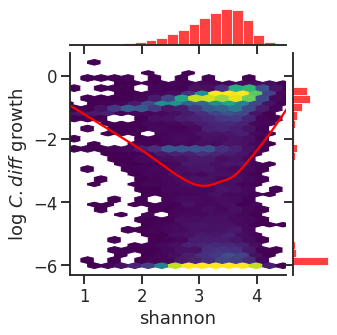

In [260]:
colors=sns.color_palette('colorblind')

lowess = sm.nonparametric.lowess
#fit=lowess(temp.log_growth,temp.shannon)
temp = combined.copy()
idx=temp[temp.log_growth < -6].index.values
temp.loc[idx,'log_growth']=-6

my_viridis = cm.get_cmap("viridis", 1024).with_extremes(under="white")
sns.jointplot(x='shannon', y='log_growth', kind="hex", palette="viridis",data=temp,height=5,gridsize=(20,20),joint_kws={'vmin':1,'vmax':300,'cmap':my_viridis},marginal_kws={'bins':25,'color':'red'})
#plt.ylim(-6.2,1)
plt.xlim(.75,4.5)
plt.plot(fit[:,0],fit[:,1],color='red')
plt.ylabel('log $C. diff$ growth')
plt.savefig('Hexblin-Shannon-vs-logrowth-Full.pdf',bbox_inches='tight')

# Fluxes

In [ ]:
murica_fluxes=pd.read_pickle('../data/American_gut_fluxes_tradeoff.pkl')
murica_exchanges=murica_fluxes.copy()
murica_exchanges.index=pd.MultiIndex.from_tuples([(murica_exchanges.loc[i,'sample'],murica_exchanges.loc[i,'compartment'])for i in murica_exchanges.index])
murica_exchanges=murica_exchanges.drop(['compartment','sample'],axis=1)
murica_exchanges=murica_exchanges[murica_exchanges.columns[['EX_' in x for x in murica_exchanges.columns ]]]

murica_export = murica_exchanges.copy()[[x[1] != 'community' for x in murica_exchanges.index]]
murica_export[murica_export<=0]=10**-6
murica_export=np.log10(murica_export).fillna(-6)

murica_import = murica_exchanges.copy()[[x[1] != 'community' for x in murica_exchanges.index]]
murica_import[murica_import >=0]=10**-6
murica_import=abs(murica_import)
murica_import=np.log10(murica_import).fillna(-6)

murica_cdiff_import=murica_import.loc[[i for i in murica_import.index if 'Clostridioides' in i[1]]]
murica_cdiff_import.index=murica_cdiff_import.index.droplevel(1)
murica_cdiff_import['log_growth']=np.log10(murica_cdiff[(murica_cdiff.compartments=='Clostridioides')&(murica_cdiff['sample'].isin(murica_cdiff_import.index))]['growth_rate'].values)
murica_cdiff_import

reaction         EX_12dgr180(e)  EX_12dgr180_m  EX_13ppd(e)  EX_13ppd_m  \
10317.000001067       -2.780344           -6.0         -6.0        -6.0   
10317.000001001       -2.147263           -6.0         -6.0        -6.0   
10317.000001079       -3.941943           -6.0         -6.0        -6.0   
10317.000001008       -3.336091           -6.0         -6.0        -6.0   
10317.000001002      -12.090565           -6.0         -6.0        -6.0   
...                         ...            ...          ...         ...   
10317.000071481       -8.062392           -6.0         -6.0        -6.0   
10317.000071438       -2.544231           -6.0         -6.0        -6.0   
10317.000071418       -4.216741           -6.0         -6.0        -6.0   
10317.000071429       -5.999737           -6.0         -6.0        -6.0   
10317.000071428       -2.439627           -6.0         -6.0        -6.0   

reaction         EX_15dap(e)  EX_15dap_m  EX_26dap_M(e)  EX_26dap_M_m  \
10317.000001067         -6.0        -6.0           -6.0          -6.0   
10317.000001001         -6.0        -6.0           -6.0          -6.0   
10317.000001079         -6.0        -6.0           -6.0          -6.0   
10317.000001008         -6.0        -6.0           -6.0          -6.0   
10317.000001002         -6.0        -6.0           -6.0          -6.0   
...                      ...         ...            ...           ...   
10317.000071481         -6.0        -6.0           -6.0          -6.0   
10317.000071438         -6.0        -6.0           -6.0          -6.0   
10317.000071418         -6.0        -6.0           -6.0          -6.0   
10317.000071429         -6.0        -6.0           -6.0          -6.0   
10317.000071428         -6.0        -6.0           -6.0          -6.0   

reaction         EX_2ddglcn(e)  EX_2ddglcn_m  ...  EX_cmp_m  EX_coa(e)  \
10317.000001067           -6.0          -6.0  ...      -6.0       -6.0   
10317.000001001           -6.0          -6.0  ...      -6.0       -6.0   
10317.000001079           -6.0          -6.0  ...      -6.0       -6.0   
10317.000001008           -6.0          -6.0  ...      -6.0       -6.0   
10317.000001002           -6.0          -6.0  ...      -6.0       -6.0   
...                        ...           ...  ...       ...        ...   
10317.000071481           -6.0          -6.0  ...      -6.0       -6.0   
10317.000071438           -6.0          -6.0  ...      -6.0       -6.0   
10317.000071418           -6.0          -6.0  ...      -6.0       -6.0   
10317.000071429           -6.0          -6.0  ...      -6.0       -6.0   
10317.000071428           -6.0          -6.0  ...      -6.0       -6.0   

reaction         EX_coa_m  EX_datp(e)  EX_datp_m  EX_ph2s(e)  EX_ph2s_m  \
10317.000001067      -6.0        -6.0       -6.0        -6.0       -6.0   
10317.000001001      -6.0        -6.0       -6.0        -6.0       -6.0   
10317.000001079      -6.0        -6.0       -6.0        -6.0       -6.0   
10317.000001008      -6.0        -6.0       -6.0        -6.0       -6.0   
10317.000001002      -6.0        -6.0       -6.0        -6.0       -6.0   
...                   ...         ...        ...         ...        ...   
10317.000071481      -6.0        -6.0       -6.0        -6.0       -6.0   
10317.000071438      -6.0        -6.0       -6.0        -6.0       -6.0   
10317.000071418      -6.0        -6.0       -6.0        -6.0       -6.0   
10317.000071429      -6.0        -6.0       -6.0        -6.0       -6.0   
10317.000071428      -6.0        -6.0       -6.0        -6.0       -6.0   

reaction         EX_thmmp(e)  EX_thmmp_m  log_growth  
10317.000001067         -6.0        -6.0   -1.098113  
10317.000001001         -6.0        -6.0   -0.461401  
10317.000001079         -6.0        -6.0   -5.619350  
10317.000001008         -6.0        -6.0   -1.595907  
10317.000001002         -6.0        -6.0  -12.364150  
...                      ...         ...         ...  
10317.000071481         -6.0        -6.0   -7.9

In [ ]:

fmt_fluxes=pd.read_pickle('../data/Weingarden_et_al_+cdiff_fluxes_tradeoff_pfba.pkl').reset_index()
fmt_fluxes.index = pd.MultiIndex.from_tuples([tuple(x) for x in fmt_fluxes[['sample','compartment']].values])
fmt_fluxes=fmt_fluxes.fillna(10**-6).drop(['sample','compartment'],axis=1)
fmt_exchanges=fmt_fluxes[fmt_fluxes.columns[['EX_' in x for x in fmt_fluxes.columns ]]]
fmt_exchanges

fmt_export = fmt_exchanges.copy()[[x[1] != 'community' for x in fmt_exchanges.index]]
fmt_export[fmt_export<=0]=10**-6
fmt_export=np.log10(fmt_export).fillna(-6)

fmt_import = fmt_exchanges.copy()[[x[1] != 'community' for x in fmt_exchanges.index]]
fmt_import[fmt_import >=0]=10**-6
fmt_import=abs(fmt_import)
fmt_import=np.log10(fmt_import).fillna(-6)

fmt_cdiff_import=fmt_import.loc[[i for i in fmt_import.index if 'Clostridioides' in i[1]]]
fmt_cdiff_import.index=fmt_cdiff_import.index.droplevel(1)
fmt_cdiff_import['log_growth']=np.log10(fmt[(fmt.compartments=='Clostridioides')&(fmt['sample'].isin(fmt_cdiff_import.index))]['growth_rate'].values)
fmt_cdiff_import

In [ ]:
alm_fluxes=pd.read_pickle('../data/David_et_al_fluxes_tradeoff_pfba.pkl').reset_index()
alm_fluxes.index = pd.MultiIndex.from_tuples([tuple(x) for x in alm_fluxes[['sample','compartment']].values])
alm_fluxes=alm_fluxes.fillna(10**-6).drop(['sample','compartment'],axis=1)
alm_exchanges=alm_fluxes[alm_fluxes.columns[['EX_' in x for x in alm_fluxes.columns ]]]


alm_export = alm_exchanges.copy()[[x[1] != 'community' for x in alm_exchanges.index]]
alm_export[alm_export<=0]=10**-6
alm_export=np.log10(alm_export).fillna(-6)

alm_import = alm_exchanges.copy()[[x[1] != 'community' for x in alm_exchanges.index]]
alm_import[alm_import >=0]=10**-6
alm_import=abs(alm_import)
alm_import=np.log10(alm_import).fillna(-6)

alm_cdiff_import=alm_import.loc[[i for i in alm_import.index if 'Clostridioides' in i[1]]]
alm_cdiff_import.index=alm_cdiff_import.index.droplevel(1)
alm_cdiff_import['log_growth']=np.log10(alm_cdiff[(alm_cdiff.compartments=='Clostridioides')&(alm_cdiff['sample'].isin(alm_cdiff_import.index))]['growth_rate'].values)
alm_cdiff_import

In [ ]:
arivale_fluxes=pd.read_pickle('../data/Arivale_cdiff_fluxes_tradeoff_pfba.pkl').reset_index()
arivale_fluxes.index = pd.MultiIndex.from_tuples([tuple(x) for x in arivale_fluxes[['sample','compartment']].values])
arivale_fluxes=arivale_fluxes.fillna(10**-6).drop(['sample','compartment'],axis=1)
arivale_exchanges=arivale_fluxes[arivale_fluxes.columns[['EX_' in x for x in arivale_fluxes.columns ]]]


arivale_export = arivale_exchanges.copy()[[x[1] != 'community' for x in arivale_exchanges.index]]
arivale_export[arivale_export<=0]=10**-6
arivale_export=np.log10(arivale_export).fillna(-6)

arivale_import = arivale_exchanges.copy()[[x[1] != 'community' for x in arivale_exchanges.index]]
arivale_import[arivale_import >=0]=10**-6
arivale_import=abs(arivale_import)
arivale_import=np.log10(arivale_import).fillna(-6)

arivale_cdiff_import=arivale_import.loc[[i for i in arivale_import.index if 'Clostridioides' in i[1]]]
arivale_cdiff_import.index=arivale_cdiff_import.index.droplevel(1)
arivale_cdiff_import=arivale_cdiff_import[arivale_cdiff_import.index.isin(arivale['sample'])]
arivale_cdiff_import.loc[arivale['sample'],'log_growth']=np.log10(arivale[(arivale.compartments=='Clostridioides')&(arivale['sample'].isin(arivale_cdiff_import.index))]['growth_rate'].values)
arivale_cdiff_import

In [57]:
arivale_cdiff_import['dataset']='arivale'
alm_cdiff_import['dataset']='alm'
murica_cdiff_import['dataset']='murica'
fmt_cdiff_import['dataset']='fmt'

cdiff_import=pd.concat([arivale_cdiff_import,alm_cdiff_import,murica_cdiff_import,fmt_cdiff_import])
cols=[x for x in cdiff_import if 'EX_' in x]
cdiff_import.loc[:,cols]=cdiff_import[cols][cdiff_import[cols]>-6].fillna(-6)
cdiff_import


EX_12dgr180(e)  EX_12dgr180_m  EX_12dhchol(e)  \
22001612560033|GFM-1079-001       -2.876566           -6.0            -6.0   
22001612560015|GFM-1079-015       -2.595648           -6.0            -6.0   
22001612560045|GFM-1079-021       -2.251451           -6.0            -6.0   
22001612560020|GFM-1079-003       -6.000000           -6.0            -6.0   
22001612560012|GFM-1079-011       -2.327444           -6.0            -6.0   
...                                     ...            ...             ...   
1924.Sadowsky.96                  -6.000000           -6.0            -6.0   
1924.Sadowsky.82                  -2.356408           -6.0            -6.0   
1924.Sadowsky.9r                  -5.454751           -6.0            -6.0   
1924.Sadowsky.98                  -6.000000           -6.0            -6.0   
1924.Sadowsky.99                  -5.814614           -6.0            -6.0   

                             EX_12dhchol_m  EX_12ppd_S(e)  EX_12ppd_S_m  \
22001612560033|GFM-1079-001           -6.0           -6.0          -6.0   
22001612560015|GFM-1079-015           -6.0           -6.0          -6.0   
22001612560045|GFM-1079-021           -6.0           -6.0          -6.0   
22001612560020|GFM-1079-003           -6.0           -6.0          -6.0   
22001612560012|GFM-1079-011           -6.0           -6.0          -6.0   
...                                    ...            ...           ...   
1924.Sadowsky.96                      -6.0           -6.0          -6.0   
1924.Sadowsky.82                      -6.0           -6.0          -6.0   
1924.Sadowsky.9r                      -6.0           -6.0          -6.0   
1924.Sadowsky.98                      -6.0           -6.0          -6.0   
1924.Sadowsky.99                      -6.0           -6.0          -6.0   

                             EX_13ppd(e)  EX_13ppd_m  EX_26dap_M(e)  \
22001612560033|GFM-1079-001         -6.0        -6.0           -6.0   
22001612560015|GFM-1079-015         -6.0        -6.0           -6.0   
22001612560045|GFM-1079-021         -6.0        -6.0           -6.0   
22001612560020|GFM-1079-003         -6.0        -6.0           -6.0   
22001612560012|GFM-1079-011         -6.0        -6.0           -6.0   
...                                  ...         ...            ...   
1924.Sadowsky.96                    -6.0        -6.0           -6.0   
1924.Sadowsky.82                    -6.0        -6.0           -6.0   
1924.Sadowsky.9r                    -6.0        -6.0           -6.0   
1924.Sadowsky.98                    -6.0        -6.0           -6.0   
1924.Sadowsky.99                    -6.0        -6.0           -6.0   

                             EX_26dap_M_m  ...  EX_amet(e)  EX_amet_m  \
22001612560033|GFM-1079-001          -6.0  ...        -6.0       -6.0   
22001612560015|GFM-1079-015          -6.0  ...        -6.0       -6.0   
22001612560045|GFM-1079-021          -6.0  ...        -6.0       -6.0   
22001612560020|GFM-1079-003          -6.0  ...        -6.0       -6.0   
22001612560012|GFM-1079-011          -6.0  ...        -6.0       -6.0   
...                                   ...  ...         ...        ...   
1924.Sadowsky.96                     -6.0  ...        -6.0       -6.0   
1924.Sadowsky.82                     -6.0  ...        -6.0       -6.0   
1924.Sadowsky.9r                     -6.0  ...        -6.0       -6.0   
1924.Sadowsky.98                     -6.0  ...        -6.0       -6.0   
1924.Sadowsky.99                     -6.0  ...        -6.0       -6.0   

                             EX_cmp(e)  EX_cmp_m  EX_coa(e)  EX_coa_m  \
22001612560033|GFM-1079-001       -6.0      -6.0       -6.0      -6.0   
22001612560015|GFM-1079-015       -6.0      -6.0       -6.0      -6.0   
22001612560045|GFM-1079-021       -6.0      -6.0       -6.0      -6.0   
22001612560020|GFM-1079-003       -6.0      -6.0       -6.0      -6.0   
22001612560012|GFM-1079-011       -6.0      -6.0       -6.0      -6.0   
...                    

In [658]:
fmt_meta=pd.read_csv('../data/Weingarden_et_al_meta.txt',sep='\t')
fmt_meta

sample_name  animations_gradient animations_subject  \
0      1924.Sadowsky.1                   54              Donor   
1     1924.Sadowsky.10                    8                CD1   
2    1924.Sadowsky.100                   16                CD4   
3    1924.Sadowsky.101                   17                CD4   
4    1924.Sadowsky.102                   18                CD4   
..                 ...                  ...                ...   
147   1924.Sadowsky.97                   13                CD4   
148   1924.Sadowsky.98                   14                CD4   
149   1924.Sadowsky.99                   15                CD4   
150   1924.Sadowsky.9r                   49              Donor   
151  1924.Sadowsky.CD4                    8                CD4   

    anonymized_name collection_timestamp day_relative_to_fmt     description  \
0        Sadowsky.1           2011-07-26                  54       CD1 Donor   
1       Sadowsky.10           2011-08-03                   8       Day 8 CD1   
2      Sadowsky.100           2011-12-16                  16      Day 16 CD4   
3      Sadowsky.101           2011-12-17                  17      Day 17 CD4   
4      Sadowsky.102           2011-12-18                  18  Day 18 (1) CD4   
..              ...                  ...                 ...             ...   
147     Sadowsky.97           2011-12-13                  13      Day 13 CD4   
148     Sadowsky.98           2011-12-14                  14      Day 14 CD4   
149     Sadowsky.99           2011-12-15                  15      Day 15 CD4   
150     Sadowsky.9r           2011-09-13                  49        Donor 10   
151    Sadowsky.CD4           2011-12-08                   8       Day 8 CD4   

    disease_state  dna_extracted  elevation  ... public qiita_study_id  \
0         healthy           True  440.82907  ...   True           1924   
1        post-FMT           True  440.82907  ...   True           1924   
2        post-FMT           True  440.82907  ...   True           1924   
3        post-FMT           True  440.82907  ...   True           1924   
4        post-FMT           True  440.82907  ...   True           1924   
..            ...            ...        ...  ...    ...            ...   
147      post-FMT           True  440.82907  ...   True           1924   
148      post-FMT           True  440.82907  ...   True           1924   
149      post-FMT           True  440.82907  ...   True           1924   
150       healthy           True  440.82907  ...   True           1924   
151      post-FMT           True  440.82907  ...   True           1924   

                  race sample_location sample_type       scientific_name  \
0    Restricted access            UCSD       Stool  human gut metagenome   
1                white            UCSD       Stool  human gut metagenome   
2                white            UCSD       Stool  human gut metagenome   
3                white            UCSD       Stool  human gut metagenome   
4                white            UCSD       Stool  human gut metagenome   
..                 ...             ...         ...                   ...   
147              white            UCSD       Stool  human gut metagenome   
148              white            UCSD       Stool  human gut metagenome   
149              white            UCSD       Stool  human gut metagenome   
150  Restricted access            UCSD       Stool  human gut metagenome   
151              white            UCSD       Stool  human gut metagenome   

                   sex taxon_id                        title  \
0    Restricted access   408170  sadowsky_CDdiff_transplants   
1               female   408170  sadowsky_CDdiff_transplants   
2               female   408170  sadowsky_CDdiff_transplants   
3               female   408170  sadowsky_CDdiff_transplants   
4               female   408170  sadowsky_CDdiff_transplants   
..                 ...      ...                          ...   
147    

In [8]:
murica_meta=pd.read_csv('../data/American_gut_metadata.tsv',sep='\t')
murica_meta

/users/acarr/anaconda3/envs/micom/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0,10,11,12,13,14,15,16,17,18,19,20,21,24,68,91,98,129,130,131,132,133,134,140,178,179,180,181,182,183) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


sample_name     acid_reflux acne_medication  \
0              10317.000001000    Not provided           false   
1              10317.000001001    Not provided           false   
2              10317.000001002    Not provided           false   
3              10317.000001004    Not provided           false   
4              10317.000001008    Not provided           false   
...                        ...             ...             ...   
17849  10317.blank1.ragOffice1  Not applicable  Not applicable   
17850  10317.blank2.ragOffice1  Not applicable  Not applicable   
17851      10317.blank20.G2.r4  Not applicable  Not applicable   
17852  10317.blank3.ragOffice1  Not applicable  Not applicable   
17853  10317.blank4.ragOffice1  Not applicable  Not applicable   

      acne_medication_otc                                           add_adhd  \
0                   false  Diagnosed by a medical professional (doctor, p...   
1                   false                                       Not provided   
2                   false                                       Not provided   
3                   false                                       Not provided   
4                   false                                       Not provided   
...                   ...                                                ...   
17849      Not applicable                                     Not applicable   
17850      Not applicable                                     Not applicable   
17851      Not applicable                                     Not applicable   
17852      Not applicable                                     Not applicable   
17853      Not applicable                                     Not applicable   

              age_cat   age_corrected       age_years alcohol_consumption  \
0                 60s            64.0              64                true   
1                 50s            53.0            53.0                true   
2                 50s            53.0            53.0                true   
3                 40s            44.0            44.0                true   
4                 60s            66.0            66.0               false   
...               ...             ...             ...                 ...   
17849  Not applicable  Not applicable  Not applicable      Not applicable   
17850  Not applicable  Not applicable  Not applicable      Not applicable   
17851  Not applicable  Not applicable  Not applicable      Not applicable   
17852  Not applicable  Not applicable  Not applicable      Not applicable   
17853  Not applicable  Not applicable  Not applicable      Not applicable   

                alcohol_frequency  ... vioscreen_xylitol  vioscreen_zinc  \
0                           Daily  ...      Not provided    Not provided   
1      Rarely (a few times/month)  ...      Not provided    Not provided   
2      Regularly (3-5 times/week)  ...      Not provided    Not provided   
3      Rarely (a few times/month)  ...      Not provided    Not provided   
4                           Never  ...      Not provided    Not provided   
...                           ...  ...               ...             ...   
17849              Not applicable  ...    Not applicable  Not applicable   
17850              Not applicable  ...    Not applicable  Not applicable   
17851              Not applicable  ...    Not applicable  Not applicable   
17852              Not applicable  ...    Not applicable  Not applicable   
17853              Not applicable  ...    Not applicable  Not applicable   

      vitamin_b_supplement_frequency vitamin_d_supplement_frequency  \
0                              Never     Regularly (3-5 times/week)   
1                       Not provided                   Not provided   
2                       Not provided                   Not provided   
3                       Not provided                   Not provided   
4                       Not provided                   Not provided   
.

/users/acarr/anaconda3/envs/micom/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


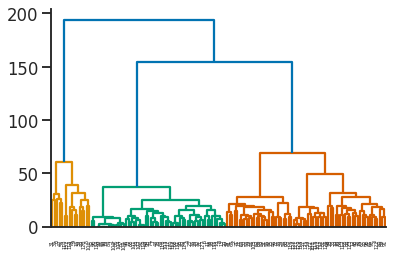

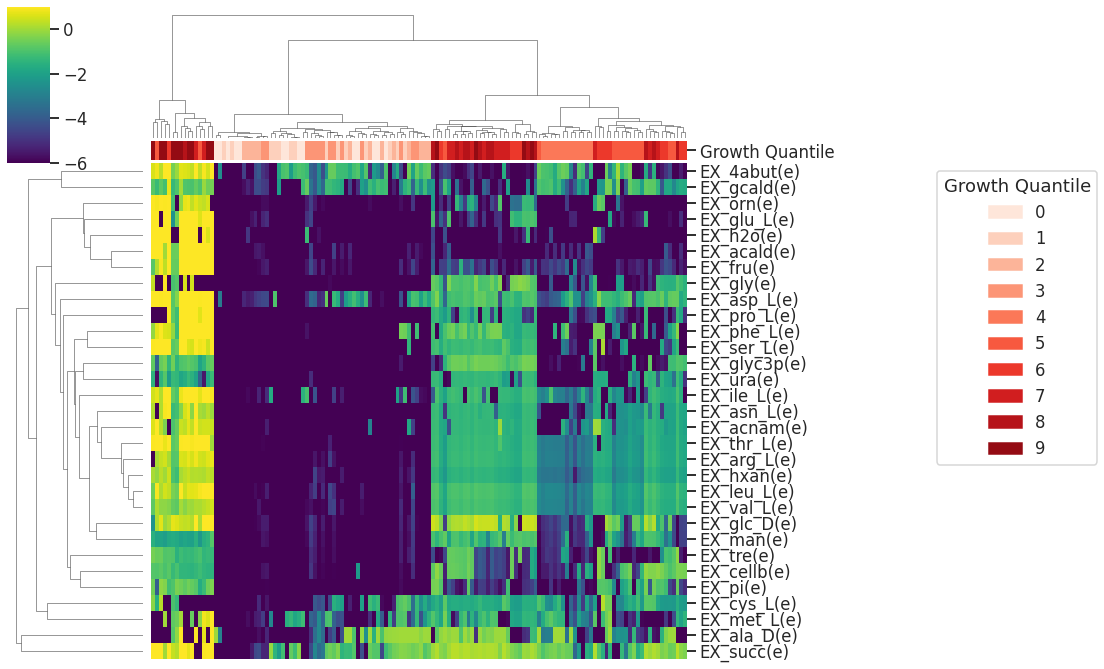

In [2602]:
#Make log growth rate heatmap

df=cdiff_import[cdiff_import.dataset=='fmt'].copy().dropna(axis=1)
cols=[x for x in df.columns if 'EX_' in x]
max_d =150
X=df[cols]
Z = linkage(X, 'ward')
dendro = dendrogram(Z,color_threshold=max_d)
clusters = fcluster(Z, max_d, criterion='distance')
colors=sns.color_palette('colorblind',len(pd.unique(clusters)))
cmap={i:colors[i-1] for i in pd.unique(clusters)}

n=10
df['Growth Quantile']=pd.qcut(df.log_growth,n,labels=False)
colors=sns.color_palette('Reds',n)
cmap = {}
i = 0
for group in sorted(df['Growth Quantile'].unique()):
    cmap[group] = colors[i]
    i+=1
#Use color dictionary to map color to speces column (provides color of each data point)
col_colors=df['Growth Quantile'].copy()
col_colors=col_colors.map(cmap)
idx=df[cols].var()[df.var()>=4.5].index
hits=idx
clust=sns.clustermap(df.iloc[:,:-2][idx].T,cmap='viridis',vmin=-6,vmax=1,figsize=(12,12),col_linkage=Z,col_colors=col_colors,yticklabels=1)
order=[x.get_text() for x in clust.ax_heatmap.get_xticklabels()]
clust.ax_heatmap.set_ylabel('')
clust.ax_heatmap.set_xlabel('')
clust.ax_heatmap.set_xticks([])
#Create custom legend to include in plot 
handles = []
labels = sorted(df['Growth Quantile'].unique())
for i in range(len(sorted(labels))):
    patch = mpatches.Patch(color=colors[i],label=labels[i])
    handles.append(patch)  
clust.ax_heatmap.legend(handles=handles,bbox_to_anchor=(1.45,1),loc=2,title='Growth Quantile')

In [177]:
tmp=cdiff_import[['dataset','log_growth']]
tmp=tmp.reset_index()
tmp.index=pd.MultiIndex.from_tuples([(tmp.loc[i,'dataset'],tmp.loc[i,'index'],'Clostridioides') for i in tmp.index])
tmp=tmp.drop(['index','dataset'],axis=1)
tmp


log_growth
arivale 22001612560033|GFM-1079-001 Clostridioides   -1.291780
        22001612560015|GFM-1079-015 Clostridioides   -0.921353
        22001612560045|GFM-1079-021 Clostridioides   -0.576849
        22001612560020|GFM-1079-003 Clostridioides   -6.751357
        22001612560012|GFM-1079-011 Clostridioides   -0.637514
...                                                        ...
fmt     1924.Sadowsky.96            Clostridioides  -12.961875
        1924.Sadowsky.82            Clostridioides   -0.455155
        1924.Sadowsky.9r            Clostridioides   -2.820447
        1924.Sadowsky.98            Clostridioides  -10.495885
        1924.Sadowsky.99            Clostridioides   -4.205254

[15098 rows x 1 columns]

In [2622]:
df['cluster']=clusters

idx=df[df['log_growth']<-6].index
df.loc[idx,'log_growth']=-6
lm = ols('log_growth ~ C(cluster)',data=df).fit()
table = sm.stats.anova_lm(lm)

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_growth   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     976.6
Date:                Thu, 13 Apr 2023   Prob (F-statistic):           3.15e-80
Time:                        14:01:20   Log-Likelihood:                -124.33
No. Observations:                 136   AIC:                             254.7
Df Residuals:                     133   BIC:                             263.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.5964      0.153     -3.908      0.000      -0.898      -0.295
C(cluster)[T.2]    -5.2613      0.173    -30.344      0.000      -5.604      -4.918
C(cluster)[T.3]    -0.7084      0.170     -4.158      0.000      -1.045      -0.371
==============================================================================
Omnibus:                       18.123   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.945
Skew:                          -0.658   Prob(JB):                     5.18e-07
Kurtosis:                       4.838   Cond. No.                         6.17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Frequency')

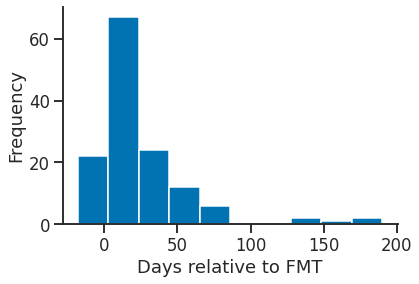

In [2623]:
df['days']=fmt_meta[fmt_meta.sample_name.isin(df.index)]['day_relative_to_fmt'].values
d={'pre-FMT':0}
df['days']=[d[x] if x in d else x for x in df.days]
df.days=df.days.astype(int)
plt.hist(df.days)

plt.xlabel('Days relative to FMT')
plt.ylabel('Frequency')

In [2631]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

#df['cluster']=clusters
#idx=df[df['log_growth']<-6].index
#df.loc[idx,'log_growth']=-6
df['growth_quantile']=df['Growth Quantile'].values
lm = ols('days ~ C(growth_quantile)',data=df).fit()
table = sm.stats.anova_lm(lm)
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   days   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     2.667
Date:                Thu, 13 Apr 2023   Prob (F-statistic):            0.00724
Time:                        14:03:01   Log-Likelihood:                -657.11
No. Observations:                 136   AIC:                             1334.
Df Residuals:                     126   BIC:                             1363.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  31.7143      8.427      3.764      0.000      15.038      48.391
C(growth_quantile)[T.1]     4.7143     11.917      0.396      0.693     -18.870      28.298
C(growth_quantile)[T.2]    23.0549     12.144      1.898      0.060      -0.978      47.088
C(growth_quantile)[T.3]   -13.0714     11.917     -1.097      0.275     -36.655      10.513
C(growth_quantile)[T.4]   -20.7143     12.144     -1.706      0.091     -44.747       3.319
C(growth_quantile)[T.5]   -16.2143     11.917     -1.361      0.176     -39.798       7.370
C(growth_quantile)[T.6]    -3.1758     12.144     -0.262      0.794     -27.209      20.857
C(growth_quantile)[T.7]     4.5714     11.917      0.384      0.702     -19.013      28.155
C(growth_quantile)[T.8]   -18.2527     12.144     -1.503      0.135     -42.286       5.780
C(growth_quantile)[T.9]   -18.5000     11.917     -1.552      0.123     -42.084       5.084
==============================================================================
Omnibus:                       84.768   Durbin-Watson:                   1.730
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              450.125
Skew:                           2.248   Prob(JB):                     1.81e-98
Kurtosis:                      10.696   Cond. No.                         10.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Probiotic

In [1709]:
prob=pd.read_pickle('../data/Weingarden_et_al_+cdiff_growth_rates_probiotic_tradeoff-vanco_pfba_set2.pkl')
cdiff_prob=prob.loc['Clostridioides'].reset_index()
cdiff_prob['log_growth']=np.log10(cdiff_prob.growth_rate)
cdiff_prob.loc[cdiff_prob.index[cdiff_prob['log_growth']<-6],'log_growth']=-6
cdiff_prob.index=cdiff_prob['sample']
cdiff_prob=cdiff_prob.drop('sample',axis=1)
cdiff_prob=cdiff_prob.loc[df.index]
cdiff_prob['condition2']='+probiotic'
tmp = pd.DataFrame()
for idx, group in cdiff_prob.groupby(by='condition'):
    
    group.loc[df.index,'cluster']=clusters
    group=group.reset_index()
    tmp=pd.concat([tmp,group])
    
    tmp2 = df.loc[:,'log_growth'].copy().reset_index()
    tmp2['cluster']=clusters
    tmp2['condition2']='-probiotic'
    tmp2['condition']=idx
    tmp2.columns=['sample', 'log_growth', 'cluster', 'condition2', 'condition']
    tmp = pd.concat([tmp,tmp2])
cdiff_prob=tmp
cdiff_prob=cdiff_prob.dropna(axis=1)
cdiff_prob.loc[cdiff_prob.index[cdiff_prob['log_growth']<-6],'log_growth']=-6
cdiff_prob['cdiff_lvl']=[float(x.split('-')[0][1:]) for x in cdiff_prob.condition]
cdiff_prob['prob_lvl']=[float(x.split('-')[2]) for x in cdiff_prob.condition]
cdiff_prob=cdiff_prob.reset_index().drop('index',axis=1)
idx1=cdiff_prob[(cdiff_prob.condition2=='+probiotic')&(cdiff_prob.prob_lvl==0)].index.values
idx2=cdiff_prob[(cdiff_prob.condition2=='+probiotic')&(cdiff_prob.prob_lvl==0.5)].index.values
idx3=cdiff_prob[(cdiff_prob.condition2=='-probiotic')].index.values

cdiff_prob.loc[idx1,'condition2']='+Vancomycin'
cdiff_prob.loc[idx2,'condition2']='+Vancomycin, +Probiotic'
cdiff_prob.loc[idx3,'condition2']='+None'
cdiff_prob

/users/acarr/anaconda3/envs/micom/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/users/acarr/anaconda3/envs/micom/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/acarr/anaconda3/envs/micom/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

sample                        condition  log_growth  \
0     1924.Sadowsky.14r     +.01-cdiff-0-probiotic-vanco    0.104040   
1     1924.Sadowsky.15r     +.01-cdiff-0-probiotic-vanco   -6.000000   
2     1924.Sadowsky.12r     +.01-cdiff-0-probiotic-vanco   -6.000000   
3     1924.Sadowsky.111     +.01-cdiff-0-probiotic-vanco   -5.314978   
4     1924.Sadowsky.13r     +.01-cdiff-0-probiotic-vanco   -6.000000   
...                 ...                              ...         ...   
1627   1924.Sadowsky.96  +.075-cdiff-0.5-probiotic-vanco   -6.000000   
1628   1924.Sadowsky.82  +.075-cdiff-0.5-probiotic-vanco   -0.455155   
1629   1924.Sadowsky.9r  +.075-cdiff-0.5-probiotic-vanco   -2.820447   
1630   1924.Sadowsky.98  +.075-cdiff-0.5-probiotic-vanco   -6.000000   
1631   1924.Sadowsky.99  +.075-cdiff-0.5-probiotic-vanco   -4.205254   

       condition2  cluster  cdiff_lvl  prob_lvl  
0     +Vancomycin      1.0      0.010       0.0  
1     +Vancomycin      2.0      0.010       0.0  
2     +Vancomycin      3.0      0.010       0.0  
3     +Vancomycin      3.0      0.010       0.0  
4     +Vancomycin      2.0      0.010       0.0  
...           ...      ...        ...       ...  
1627        +None      2.0      0.075       0.5  
1628        +None      1.0      0.075       0.5  
1629        +None      3.0      0.075       0.5  
1630        +None      2.0      0.075       0.5  
1631        +None      2.0      0.075       0.5  

[1632 rows x 7 columns]

In [1705]:
prob2=pd.read_pickle('../data/Weingarden_et_al_+cdiff_growth_rates_probiotic_tradeoff_pfba_set1.pkl')
cdiff_prob2=prob2.loc['Clostridioides'].reset_index()
cdiff_prob2['log_growth']=np.log10(cdiff_prob2.growth_rate)
cdiff_prob2.loc[cdiff_prob2.index[cdiff_prob2['log_growth']<-6],'log_growth']=-6
cdiff_prob2.index=cdiff_prob2['sample']
cdiff_prob2=cdiff_prob2.drop('sample',axis=1)
cdiff_prob2=cdiff_prob2.loc[df.index]
cdiff_prob2['condition2']='+probiotic'
tmp = pd.DataFrame()
for idx, group in cdiff_prob2.groupby(by='condition'):
    
    group.loc[df.index,'cluster']=clusters
    group=group.reset_index()
    tmp=pd.concat([tmp,group])
    
    tmp2 = df.loc[:,'log_growth'].copy().reset_index()
    tmp2['cluster']=clusters
    tmp2['condition2']='-probiotic'
    tmp2['condition']=idx
    tmp2.columns=['sample', 'log_growth', 'cluster', 'condition2', 'condition']
    tmp = pd.concat([tmp,tmp2])
cdiff_prob2=tmp
cdiff_prob2=cdiff_prob2.dropna(axis=1)
cdiff_prob2.loc[cdiff_prob2.index[cdiff_prob2['log_growth']<-6],'log_growth']=-6
cdiff_prob2['cdiff_lvl']=0.1
cdiff_prob2['prob_lvl']=[float(x.split('-')[1]) for x in cdiff_prob2.condition]
cdiff_prob2=cdiff_prob2.reset_index().drop('index',axis=1)
cdiff_prob2

/users/acarr/anaconda3/envs/micom/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/users/acarr/anaconda3/envs/micom/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/acarr/anaconda3/envs/micom/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

sample             condition  log_growth  condition2  \
0     1924.Sadowsky.14r  +cdiff-0.2-probiotic   -2.828560  +probiotic   
1     1924.Sadowsky.15r  +cdiff-0.2-probiotic   -6.000000  +probiotic   
2     1924.Sadowsky.12r  +cdiff-0.2-probiotic   -3.473773  +probiotic   
3     1924.Sadowsky.111  +cdiff-0.2-probiotic   -6.000000  +probiotic   
4     1924.Sadowsky.13r  +cdiff-0.2-probiotic   -6.000000  +probiotic   
...                 ...                   ...         ...         ...   
1899   1924.Sadowsky.96  +cdiff-0.8-probiotic   -6.000000  -probiotic   
1900   1924.Sadowsky.82  +cdiff-0.8-probiotic   -0.455155  -probiotic   
1901   1924.Sadowsky.9r  +cdiff-0.8-probiotic   -2.820447  -probiotic   
1902   1924.Sadowsky.98  +cdiff-0.8-probiotic   -6.000000  -probiotic   
1903   1924.Sadowsky.99  +cdiff-0.8-probiotic   -4.205254  -probiotic   

      cluster  cdiff_lvl  prob_lvl  
0         1.0        0.1       0.2  
1         2.0        0.1       0.2  
2         3.0        0.1       0.2  
3         3.0        0.1       0.2  
4         2.0        0.1       0.2  
...       ...        ...       ...  
1899      2.0        0.1       0.8  
1900      1.0        0.1       0.8  
1901      3.0        0.1       0.8  
1902      2.0        0.1       0.8  
1903      2.0        0.1       0.8  

[1904 rows x 7 columns]

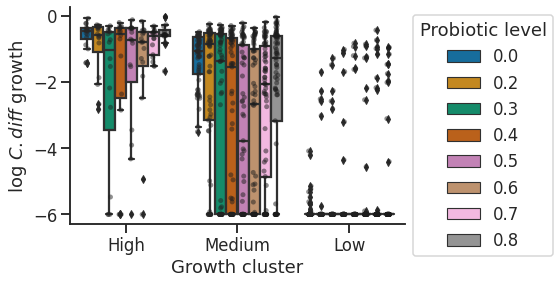

In [2551]:
plt.figure(figsize=(6,4))
idx=cdiff_prob2[cdiff_prob2.condition2=='-probiotic'].index.values
tmp=cdiff_prob2[['sample','log_growth','cluster','prob_lvl']].drop_duplicates()
cdiff_prob2.loc[idx,'prob_lvl']=0
sns.boxplot(x='cluster',y='log_growth',hue='prob_lvl',data=tmp,order=[1,3,2])
ax=sns.stripplot(x='cluster',y='log_growth',hue='prob_lvl',data=tmp,order=[1,3,2],color='k',alpha=0.5,dodge=True)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:8], labels[0:8],bbox_to_anchor=(1,1),title='Probiotic level',loc=2)
plt.ylabel('log $C. diff$ growth')
plt.xlabel('Growth cluster')
plt.xticks([0,1,2],['High','Medium','Low'])
plt.savefig('Cdiff-Probiotic-test-boxplots.pdf',bbox_inches='tight')

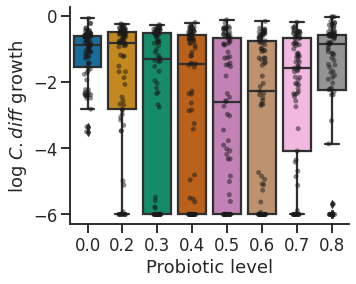

In [2558]:
plt.figure(figsize=(5,4))
sns.boxplot(x='prob_lvl',y='log_growth',data=tmp[tmp.cluster!=2])
sns.stripplot(x='prob_lvl',y='log_growth',data=tmp[tmp.cluster!=2],color='k',alpha=0.5,dodge=True)
plt.ylabel('log $C. diff$ growth')
plt.xlabel('Probiotic level')
plt.savefig('Cdiff-Probiotic-test-boxplots-v2.pdf',bbox_inches='tight')

In [1710]:
tmp=cdiff_prob2[(cdiff_prob2.prob_lvl==0.5)&(cdiff_prob2.condition2=='+probiotic')]
tmp.condition2='+Probiotic'
tmp.cdiff_lvl=0.01
cdiff_prob=pd.concat([cdiff_prob,tmp])
cdiff_prob

/users/acarr/anaconda3/envs/micom/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


sample                     condition  log_growth   condition2  \
0    1924.Sadowsky.14r  +.01-cdiff-0-probiotic-vanco    0.104040  +Vancomycin   
1    1924.Sadowsky.15r  +.01-cdiff-0-probiotic-vanco   -6.000000  +Vancomycin   
2    1924.Sadowsky.12r  +.01-cdiff-0-probiotic-vanco   -6.000000  +Vancomycin   
3    1924.Sadowsky.111  +.01-cdiff-0-probiotic-vanco   -5.314978  +Vancomycin   
4    1924.Sadowsky.13r  +.01-cdiff-0-probiotic-vanco   -6.000000  +Vancomycin   
..                 ...                           ...         ...          ...   
947   1924.Sadowsky.96          +cdiff-0.5-probiotic   -6.000000   +Probiotic   
948   1924.Sadowsky.82          +cdiff-0.5-probiotic   -3.906904   +Probiotic   
949   1924.Sadowsky.9r          +cdiff-0.5-probiotic   -6.000000   +Probiotic   
950   1924.Sadowsky.98          +cdiff-0.5-probiotic   -6.000000   +Probiotic   
951   1924.Sadowsky.99          +cdiff-0.5-probiotic   -1.203822   +Probiotic   

     cluster  cdiff_lvl  prob_lvl  
0        1.0       0.01       0.0  
1        2.0       0.01       0.0  
2        3.0       0.01       0.0  
3        3.0       0.01       0.0  
4        2.0       0.01       0.0  
..       ...        ...       ...  
947      2.0       0.01       0.5  
948      1.0       0.01       0.5  
949      3.0       0.01       0.5  
950      2.0       0.01       0.5  
951      2.0       0.01       0.5  

[1768 rows x 7 columns]

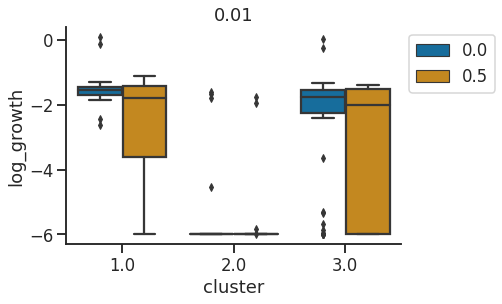

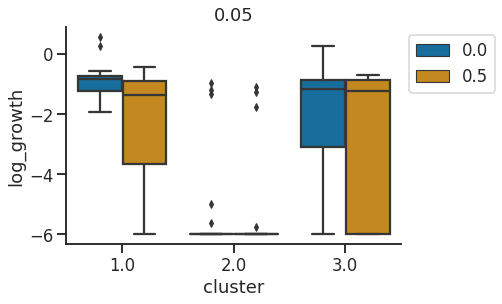

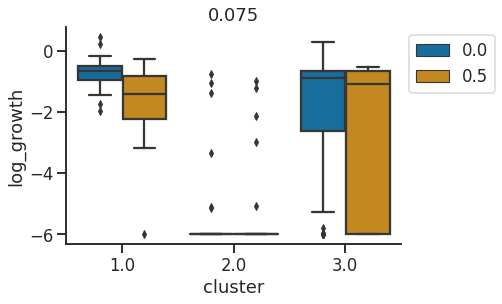

<Figure size 432x288 with 0 Axes>

In [1036]:
diff1={}
diff2={}
smp1={}
smp2={}
cond1={}
cond2={}
lvl=[]
for idx,d in cdiff_prob.groupby(by='cdiff_lvl'):
    sns.boxplot(hue='prob_lvl',y='log_growth',data=d[(d.condition2=='+probiotic')],x='cluster')
    lvl.append(idx)
    #med=d.groupby(by=['cluster','condition2']).median()
    diff1[lvl[-1]]=d[(d.condition2=='+probiotic')&(d.prob_lvl==0)&(d.cluster==1)].log_growth.values-d[(d.condition2=='+probiotic')&(d.prob_lvl==0.5)&(d.cluster==1)].log_growth.values
    diff2[lvl[-1]]=d[(d.condition2=='+probiotic')&(d.prob_lvl==0)&(d.cluster==3)].log_growth.values-d[(d.condition2=='+probiotic')&(d.prob_lvl==0.5)&(d.cluster==3)].log_growth.values
    
    smp1[lvl[-1]]=d[(d.condition2=='+probiotic')&(d.prob_lvl==0)&(d.cluster==1)]['sample'].values
    smp2[lvl[-1]]=d[(d.condition2=='+probiotic')&(d.prob_lvl==0)&(d.cluster==3)]['sample'].values
    
    cond1[lvl[-1]]=d[(d.condition2=='+probiotic')&(d.prob_lvl==0)&(d.cluster==1)]['condition'].values
    cond2[lvl[-1]]=d[(d.condition2=='+probiotic')&(d.prob_lvl==0)&(d.cluster==3)]['condition'].values
    plt.title(idx)
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()
    plt.clf()
#plt.ylim(-2,1)

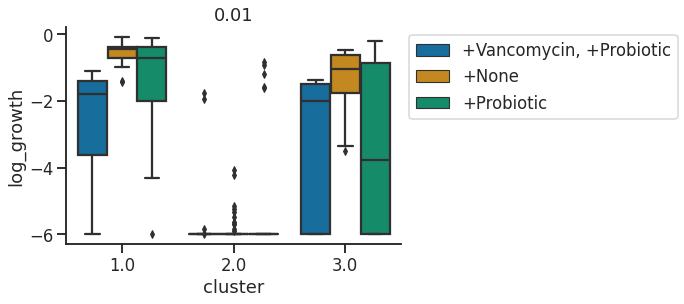

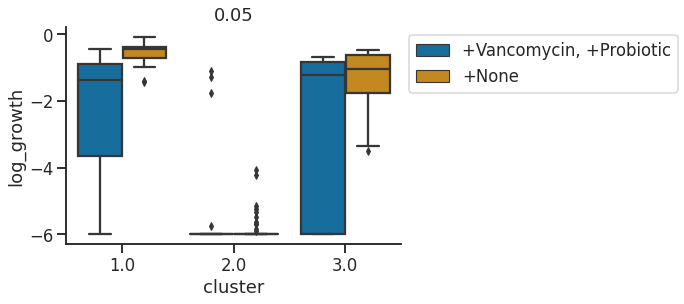

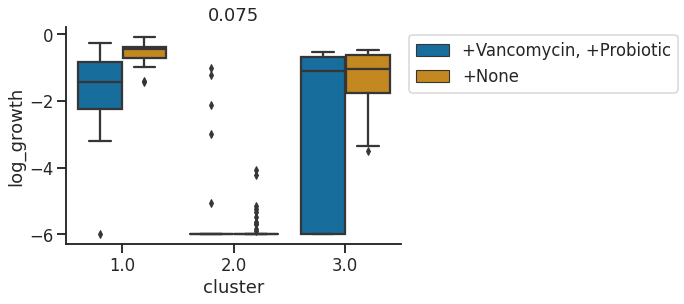

<Figure size 432x288 with 0 Axes>

In [2516]:
diff1={}
diff2={}
smp1={}
smp2={}
cond1={}
cond2={}
lvl=[]
for idx,d in cdiff_prob.groupby(by='cdiff_lvl'):
    sns.boxplot(hue='condition2',y='log_growth',data=d[(d.prob_lvl==0.5)],x='cluster')
    lvl.append(idx)
    #med=d.groupby(by=['cluster','condition2']).median()
    diff1[lvl[-1]]=d[(d.condition2=='-probiotic')&(d.prob_lvl==0.5)&(d.cluster==1)].log_growth.values-d[(d.condition2=='+probiotic')&(d.prob_lvl==0.5)&(d.cluster==1)].log_growth.values
    diff2[lvl[-1]]=d[(d.condition2=='-probiotic')&(d.prob_lvl==0.5)&(d.cluster==3)].log_growth.values-d[(d.condition2=='+probiotic')&(d.prob_lvl==0.5)&(d.cluster==3)].log_growth.values
    
    smp1[lvl[-1]]=d[(d.condition2=='+probiotic')&(d.prob_lvl==0.5)&(d.cluster==1)]['sample'].values
    smp2[lvl[-1]]=d[(d.condition2=='+probiotic')&(d.prob_lvl==0.5)&(d.cluster==3)]['sample'].values
    
    cond1[lvl[-1]]=d[(d.condition2=='+probiotic')&(d.prob_lvl==0.5)&(d.cluster==1)]['condition'].values
    cond2[lvl[-1]]=d[(d.condition2=='+probiotic')&(d.prob_lvl==0.5)&(d.cluster==3)]['condition'].values
    plt.title(idx)
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()
    plt.clf()
#plt.ylim(-2,1)

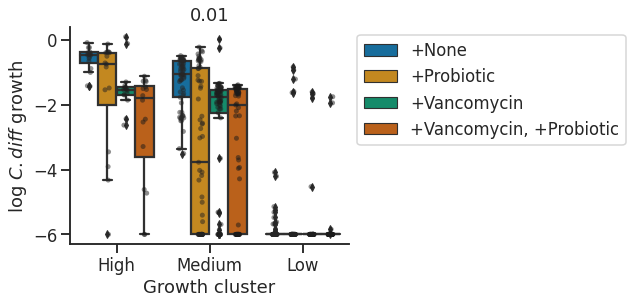

<Figure size 432x288 with 0 Axes>

In [2313]:
for idx,d in cdiff_prob.groupby(by='cdiff_lvl'):
    plt.figure(figsize=(5,4))
    d=d.drop('condition',axis=1)
    d=d.drop_duplicates(subset=['sample','condition2','cluster'])
    sns.boxplot(hue='condition2',y='log_growth',data=d,x='cluster',order=[1,3,2],hue_order=['+None','+Probiotic' ,'+Vancomycin','+Vancomycin, +Probiotic'])
    ax=sns.stripplot(hue='condition2',y='log_growth',data=d,x='cluster',order=[1,3,2],hue_order=['+None', '+Probiotic' ,'+Vancomycin','+Vancomycin, +Probiotic'],color='k',alpha=0.5,dodge=True)
    plt.title(idx)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[0:4], labels[0:4],bbox_to_anchor=(1,1))
    plt.ylabel('log $C. diff$ growth')
    plt.xlabel('Growth cluster')
    plt.xticks([0,1,2],['High','Medium','Low'])
    plt.savefig('Cdiff-Probiotic-boxplots.pdf',bbox_inches='tight')
    plt.show()
    plt.clf()
    break

In [2340]:
from scipy.stats import wilcoxon
x=d[(d.condition2=='+Probiotic')&(d.cluster==2)].log_growth.values
y=d[(d.condition2=='+Vancomycin')&(d.cluster==2)].log_growth.values
wilcoxon(x=x,y=y)

#Results
#High
#None vs Probiotic, p = 0.038
#None vs Van, p = 0.0007
#None vs Probitoic + Van p = 9.1552734375e-05
#Van vs Probiotic, p=0.86
#Van vs Probiotic + Van p = 0.116
#Probiotic vs Probiotic + Van p= 0.0832

#Medium
#None vs Probiotic, p = 2.6572827979273516e-07
#None vs Probitoic + Van p = 1.376197286689417e-11
#None vs Van, p = 2.3e-8
#Van vs Probiotic, p=0.066
#Van vs Probiotic + Van p = 0.0045
#Probiotic vs Probiotic + Van p= 0.75

#Low
#None vs Probiotic, p = 0.2860
#None vs Probitoic + Van p = 0.2860
#Van vs Probiotic, p=0.23
#Van vs Probiotic + Van p = 0.067
#Probiotic vs Probiotic + Van p= 0.0629

WilcoxonResult(statistic=7.0, pvalue=0.23672357063785732)

In [1110]:
x1=d[(d.condition2=='+Vancomycin, +Probiotic')&(d.cluster==3)].log_growth.values
x2=d[(d.condition2=='+Vancomycin')&(d.cluster==3)].log_growth.values
ttest_ind(x1,x2,equal_var=False)

Ttest_indResult(statistic=-2.14435483014239, pvalue=0.0339252617827345)

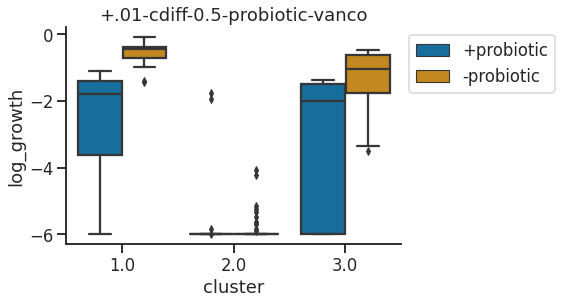

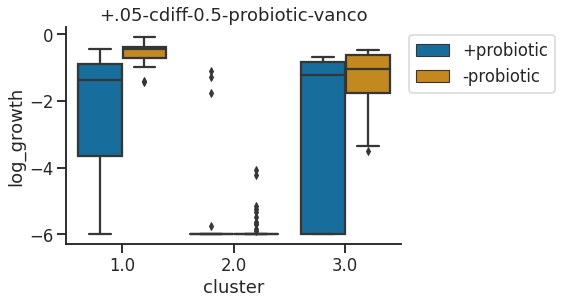

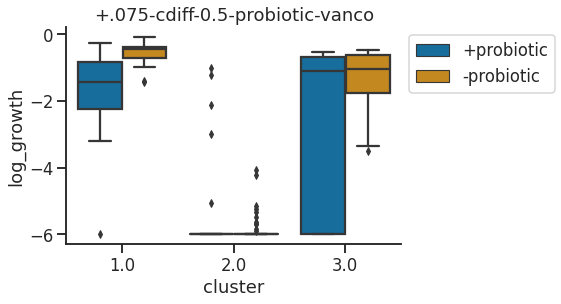

<Figure size 432x288 with 0 Axes>

In [1001]:
diff1={}
diff2={}
smp1={}
smp2={}
cond1={}
cond2={}
lvl=[]
for idx,d in cdiff_prob.groupby(by='condition'):
    sns.boxplot(hue='condition2',y='log_growth',data=d,x='cluster')
    lvl.append(float(idx.split('-')[0][1:]))
    med=d.groupby(by=['cluster','condition2']).median()
    diff1[lvl[-1]]=d[(d.condition2=='-probiotic')&(d.cluster==1)].log_growth.values-d[(d.condition2=='+probiotic')&(d.cluster==1)].log_growth.values
    diff2[lvl[-1]]=d[(d.condition2=='-probiotic')&(d.cluster==3)].log_growth.values-d[(d.condition2=='+probiotic')&(d.cluster==3)].log_growth.values
    
    smp1[lvl[-1]]=d[(d.condition2=='-probiotic')&(d.cluster==1)]['sample'].values
    smp2[lvl[-1]]=d[(d.condition2=='-probiotic')&(d.cluster==3)]['sample'].values
    
    cond1[lvl[-1]]=d[(d.condition2=='-probiotic')&(d.cluster==1)]['condition'].values
    cond2[lvl[-1]]=d[(d.condition2=='-probiotic')&(d.cluster==3)]['condition'].values
    plt.title(idx)
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()
    plt.clf()
#plt.ylim(-2,1)

In [992]:
d1=pd.DataFrame.from_dict(diff1).unstack().reset_index().drop('level_1',axis=1)
d1.columns=['probiotic','growth_ratio']
d1['cluster']=1

c1=pd.DataFrame.from_dict(cond1).unstack().reset_index().drop('level_1',axis=1)
s1=pd.DataFrame.from_dict(smp1).unstack().reset_index().drop('level_1',axis=1)

d1['sample']=s1[0]
d1['condition']=c1[0]


d2=pd.DataFrame.from_dict(diff2).unstack().reset_index().drop('level_1',axis=1)
d2.columns=['probiotic','growth_ratio']
d2['cluster']=3

c2=pd.DataFrame.from_dict(cond2).unstack().reset_index().drop('level_1',axis=1)
s2=pd.DataFrame.from_dict(smp2).unstack().reset_index().drop('level_1',axis=1)

d2['sample']=s2[0]
d2['condition']=c2[0]

d=pd.concat([d1,d2])
d

probiotic  growth_ratio  cluster             sample  \
0        0.010      3.208189        1  1924.Sadowsky.14r   
1        0.010      1.470218        1   1924.Sadowsky.13   
2        0.010      4.247019        1   1924.Sadowsky.12   
3        0.010      1.187927        1   1924.Sadowsky.11   
4        0.010      0.668498        1  1924.Sadowsky.26r   
..         ...           ...      ...                ...   
190      0.075      3.458799        3   1924.Sadowsky.93   
191      0.075     -1.716737        3   1924.Sadowsky.81   
192      0.075      3.769007        3   1924.Sadowsky.91   
193      0.075      0.310532        3   1924.Sadowsky.95   
194      0.075     -1.996356        3   1924.Sadowsky.9r   

                           condition  
0     +.01-cdiff-0.5-probiotic-vanco  
1     +.01-cdiff-0.5-probiotic-vanco  
2     +.01-cdiff-0.5-probiotic-vanco  
3     +.01-cdiff-0.5-probiotic-vanco  
4     +.01-cdiff-0.5-probiotic-vanco  
..                               ...  
190  +.075-cdiff-0.5-probiotic-vanco  
191  +.075-cdiff-0.5-probiotic-vanco  
192  +.075-cdiff-0.5-probiotic-vanco  
193  +.075-cdiff-0.5-probiotic-vanco  
194  +.075-cdiff-0.5-probiotic-vanco  

[243 rows x 5 columns]

Text(0.5, 1.0, 'Medium growth cluster')

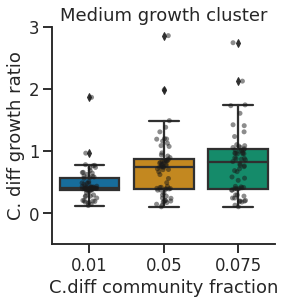

In [990]:
fig,ax=plt.subplots(1,1,figsize=(4,4))
sns.boxplot(x='probiotic',y='growth_ratio',data=d[d.cluster==3],ax=ax)
sns.stripplot(x='probiotic',y='growth_ratio',data=d[d.cluster==3],color='k',ax=ax,alpha=0.5)
plt.xlabel('C.diff community fraction')
plt.ylabel('C. diff growth ratio')
plt.ylim(-0.5,3)
plt.title('Medium growth cluster')

Text(0.5, 1.0, 'Medium growth cluster')

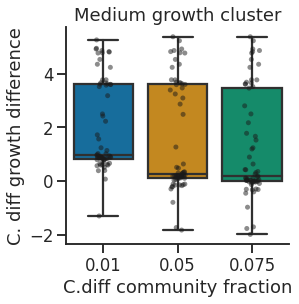

In [994]:
fig,ax=plt.subplots(1,1,figsize=(4,4))
sns.boxplot(x='probiotic',y='growth_ratio',data=d[d.cluster==3],ax=ax)
sns.stripplot(x='probiotic',y='growth_ratio',data=d[d.cluster==3],color='k',ax=ax,alpha=0.5)
plt.xlabel('C.diff community fraction')
plt.ylabel('C. diff growth difference')
#plt.ylim(-0.5,3)
plt.title('Medium growth cluster')

In [1240]:
strains=['colihominis',
'bolteae',
'producta',
'longicatena',
'innocuum',
'plautii']
prob_strains=prob.loc[strains].reset_index()
prob_strains['log_growth']=np.log10(prob_strains.growth_rate)
prob_strains.loc[prob_strains.index[prob_strains['log_growth']<-6],'log_growth']=-6
prob_strains=prob_strains[prob_strains.condition=='+.01-cdiff-0.5-probiotic-vanco']
tmp=cdiff_prob[(cdiff_prob.condition2=='+Vancomycin, +Probiotic')&(cdiff_prob.condition=='+.01-cdiff-0.5-probiotic-vanco')].copy()
#tmp=tmp.drop(['condition'],axis=1)
tmp.columns=['sample','condition','cdiff_log_growth','condition2','cluster','cdiff_lvl','prob_lvl']
tmp1=cdiff_prob[(cdiff_prob.condition2=='+Vancomycin, +Probiotic')&(cdiff_prob.condition=='+.01-cdiff-0.5-probiotic-vanco')].copy()
tmp2=cdiff_prob[(cdiff_prob.condition2=='+None')&(cdiff_prob.condition=='+.01-cdiff-0.5-probiotic-vanco')].copy()
tmp1.index=tmp1['sample']
tmp2.index=tmp2['sample']
ratio=(10**tmp1.log_growth)/(10**tmp2.log_growth)
diff=(10**tmp1.log_growth)-(10**tmp2.log_growth)
tmp['growth_ratio']=ratio.loc[tmp['sample']].values
tmp['growth_diff']=diff.loc[tmp['sample']].values
prob_strains=pd.merge(prob_strains,tmp,on=['sample','condition'])

#tmp=d[['condition','sample','growth_ratio']]
#prob_strains=pd.merge(prob_strains,tmp,on=['sample','condition'])

#prob_strains['probiotic']=[float(x.split('-')[0][1:]) for x in  prob_strains.condition]
prob_strains

compartments   growth_rate  abundance             sample  \
0    colihominis  4.665907e-13   0.083366  1924.Sadowsky.108   
1        bolteae  3.833001e-04   0.083366  1924.Sadowsky.108   
2       producta  2.587624e-11   0.083366  1924.Sadowsky.108   
3    longicatena  6.483165e-12   0.083366  1924.Sadowsky.108   
4       innocuum  4.753409e-03   0.083366  1924.Sadowsky.108   
..           ...           ...        ...                ...   
811      bolteae  1.808768e-03   0.083340   1924.Sadowsky.99   
812     producta  1.283296e-06   0.083340   1924.Sadowsky.99   
813  longicatena  7.638300e-09   0.083340   1924.Sadowsky.99   
814     innocuum  3.314260e-03   0.083340   1924.Sadowsky.99   
815      plautii  5.167683e-09   0.083340   1924.Sadowsky.99   

                          condition  tradeoff  log_growth  cdiff_log_growth  \
0    +.01-cdiff-0.5-probiotic-vanco       0.8   -6.000000              -6.0   
1    +.01-cdiff-0.5-probiotic-vanco       0.8   -3.416461              -6.0   
2    +.01-cdiff-0.5-probiotic-vanco       0.8   -6.000000              -6.0   
3    +.01-cdiff-0.5-probiotic-vanco       0.8   -6.000000              -6.0   
4    +.01-cdiff-0.5-probiotic-vanco       0.8   -2.322995              -6.0   
..                              ...       ...         ...               ...   
811  +.01-cdiff-0.5-probiotic-vanco       0.8   -2.742617              -6.0   
812  +.01-cdiff-0.5-probiotic-vanco       0.8   -5.891673              -6.0   
813  +.01-cdiff-0.5-probiotic-vanco       0.8   -6.000000              -6.0   
814  +.01-cdiff-0.5-probiotic-vanco       0.8   -2.479613              -6.0   
815  +.01-cdiff-0.5-probiotic-vanco       0.8   -6.000000              -6.0   

                  condition2  cluster  cdiff_lvl  prob_lvl  growth_ratio  \
0    +Vancomycin, +Probiotic      2.0       0.01       0.5      0.300138   
1    +Vancomycin, +Probiotic      2.0       0.01       0.5      0.300138   
2    +Vancomycin, +Probiotic      2.0       0.01       0.5      0.300138   
3    +Vancomycin, +Probiotic      2.0       0.01       0.5      0.300138   
4    +Vancomycin, +Probiotic      2.0       0.01       0.5      0.300138   
..                       ...      ...        ...       ...           ...   
811  +Vancomycin, +Probiotic      2.0       0.01       0.5      0.016042   
812  +Vancomycin, +Probiotic      2.0       0.01       0.5      0.016042   
813  +Vancomycin, +Probiotic      2.0       0.01       0.5      0.016042   
814  +Vancomycin, +Probiotic      2.0       0.01       0.5      0.016042   
815  +Vancomycin, +Probiotic      2.0       0.01       0.5      0.016042   

     growth_diff  
0      -0.000002  
1      -0.000002  
2      -0.000002  
3      -0.000002  
4      -0.000002  
..           ...  
811    -0.000061  
812    -0.000061  
813    -0.000061  
814    -0.000061  
815    -0.000061  

[816 rows x 14 columns]

In [1236]:
tmp1=cdiff_prob[(cdiff_prob.condition2=='+Vancomycin, +Probiotic')&(cdiff_prob.condition=='+.01-cdiff-0.5-probiotic-vanco')].copy()
tmp2=cdiff_prob[(cdiff_prob.condition2=='+None')&(cdiff_prob.condition=='+.01-cdiff-0.5-probiotic-vanco')].copy()
tmp1.index=tmp1['sample']
tmp2.index=tmp2['sample']
ratio=(10**tmp1.log_growth)/(10**tmp2.log_growth)
diff=(10**tmp1.log_growth)-(10**tmp2.log_growth)
diff

sample
1924.Sadowsky.14r   -0.836318
1924.Sadowsky.15r    0.000000
1924.Sadowsky.12r   -0.033727
1924.Sadowsky.111   -0.058401
1924.Sadowsky.13r    0.000000
                       ...   
1924.Sadowsky.96     0.000000
1924.Sadowsky.82    -0.350625
1924.Sadowsky.9r     0.029246
1924.Sadowsky.98     0.000000
1924.Sadowsky.99    -0.000061
Name: log_growth, Length: 136, dtype: float64

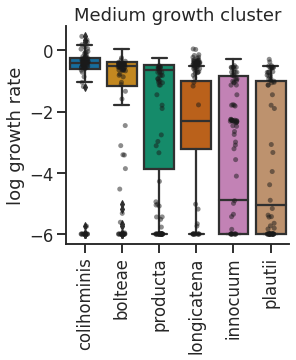

<Figure size 432x288 with 0 Axes>

In [1144]:

fig,ax=plt.subplots(1,1,figsize=(4,4))
order=prob_strains[prob_strains.cluster==3].groupby(by='compartments').median().sort_values(by='growth_rate',ascending=False).index.values
sns.boxplot(x='compartments',y='log_growth',data=prob_strains[prob_strains.cluster==3],ax=ax,order=order)
sns.stripplot(x='compartments',y='log_growth',data=prob_strains[prob_strains.cluster==3],color='k',ax=ax,alpha=0.5)
plt.ylabel('log growth rate')
plt.xticks(rotation=90)
plt.xlabel('')
#plt.ylim(-0.5,3)
plt.title('Medium growth cluster')
plt.show()
plt.clf()

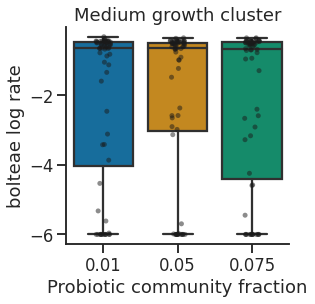

<Figure size 432x288 with 0 Axes>

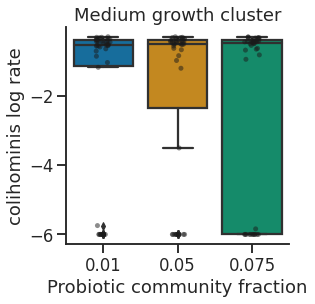

<Figure size 432x288 with 0 Axes>

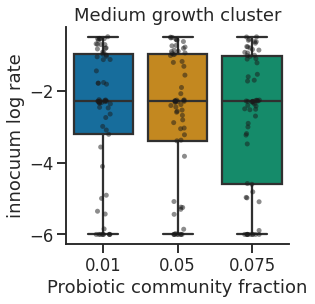

<Figure size 432x288 with 0 Axes>

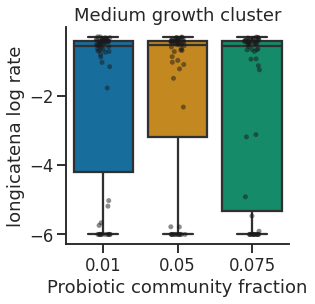

<Figure size 432x288 with 0 Axes>

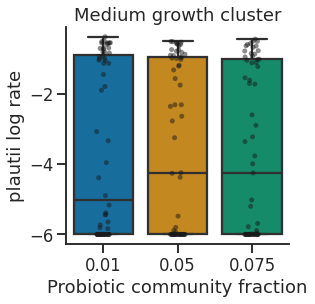

<Figure size 432x288 with 0 Axes>

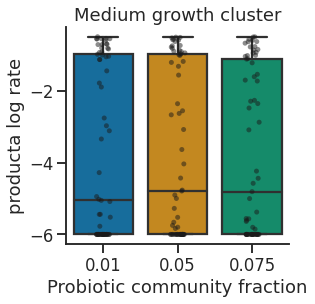

<Figure size 432x288 with 0 Axes>

In [999]:
for strain,s in prob_strains[prob_strains.growth_rate<=0.5].groupby(by='compartments'):
    fig,ax=plt.subplots(1,1,figsize=(4,4))
    sns.boxplot(x='probiotic',y='log_growth',data=s[s.cluster==3],ax=ax)
    sns.stripplot(x='probiotic',y='log_growth',data=s[s.cluster==3],color='k',ax=ax,alpha=0.5)
    plt.xlabel('Probiotic community fraction')
    plt.ylabel('%s log rate'%strain)
    #plt.ylim(-0.5,3)
    plt.title('Medium growth cluster')
    plt.show()
    plt.clf()

/users/acarr/anaconda3/envs/micom/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


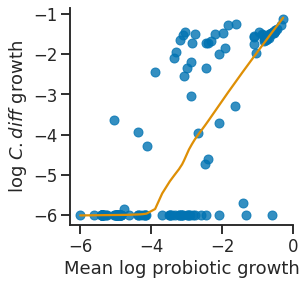

In [1274]:
x=prob_strains.groupby(by='sample').mean().log_growth.values
y=prob_strains.groupby(by='sample').mean().cdiff_log_growth.values

lowess = sm.nonparametric.lowess
fit=lowess(y,x)
plt.figure(figsize=(4,4))
sns.regplot(x[y<10],y[y<10],fit_reg=False)
#plt.ylim(0,9)
plt.plot(fit[:,0],fit[:,1])
plt.xlabel('Mean log probiotic growth')
plt.ylabel('log $C. diff$ growth')
plt.savefig('cdiff_growth_rate-vs-probiotic.pdf',bbox_inches='tight')

In [2153]:
prob_fluxes=pd.read_pickle('../data/Weingarden_et_al_+cdiff_fluxes_probiotic_tradeoff-vanco_pfba_set2.pkl')
#prob_fluxes=pd.read_pickle('../data/Weingarden_et_al_+cdiff_fluxes_probiotic_tradeoff_pfba_set1.pkl')

prob_growth=pd.read_pickle('../data/Weingarden_et_al_+cdiff_growth_rates_probiotic_tradeoff-vanco_pfba_set2.pkl').reset_index()
#prob_growth=pd.read_pickle('../data/Weingarden_et_al_+cdiff_growth_rates_probiotic_tradeoff_pfba_set1.pkl').reset_index()
prob_growth.index=pd.MultiIndex.from_tuples([(prob_growth.loc[i,'sample'],prob_growth.loc[i,'compartments']) for i in prob_growth.index])
prob_growth=prob_growth.drop(['compartments','sample'],axis=1)
prob_growth['log_growth']=np.log10(prob_growth.growth_rate)
idx=prob_growth.index[prob_growth['log_growth']<-6]
prob_growth.loc[idx,'log_growth']=-6
prob_growth


growth_rate  abundance  \
1924.Sadowsky.108 Acidaminococcus  1.319263e-01   0.007856   
                  Akkermansia      1.710910e-12   0.013355   
                  Alistipes        1.020910e+00   0.036922   
                  Anaerobutyricum  2.074489e-12   0.010212   
                  Anaerostipes     4.667535e-12   0.030637   
...                                         ...        ...   
1924.Sadowsky.99  Roseburia        7.420606e-13   0.001822   
                  Ruminococcus     5.994736e-13   0.005796   
                  Streptococcus    4.528569e-13   0.006624   
                  Tyzzerella       1.404831e-12   0.003312   
                  community        3.940582e-01   1.000000   

                                                        condition  tradeoff  \
1924.Sadowsky.108 Acidaminococcus  +.01-cdiff-0.5-probiotic-vanco       0.8   
                  Akkermansia      +.01-cdiff-0.5-probiotic-vanco       0.8   
                  Alistipes        +.01-cdiff-0.5-probiotic-vanco       0.8   
                  Anaerobutyricum  +.01-cdiff-0.5-probiotic-vanco       0.8   
                  Anaerostipes     +.01-cdiff-0.5-probiotic-vanco       0.8   
...                                                           ...       ...   
1924.Sadowsky.99  Roseburia          +.01-cdiff-0-probiotic-vanco       0.8   
                  Ruminococcus       +.01-cdiff-0-probiotic-vanco       0.8   
                  Streptococcus      +.01-cdiff-0-probiotic-vanco       0.8   
                  Tyzzerella         +.01-cdiff-0-probiotic-vanco       0.8   
                  community          +.01-cdiff-0-probiotic-vanco       0.8   

                                   log_growth  
1924.Sadowsky.108 Acidaminococcus   -0.879669  
                  Akkermansia       -6.000000  
                  Alistipes          0.008987  
                  Anaerobutyricum   -6.000000  
                  Anaerostipes      -6.000000  
...                                       ...  
1924.Sadowsky.99  Roseburia         -6.000000  
                  Ruminococcus      -6.000000  
                  Streptococcus     -6.000000  
                  Tyzzerella        -6.000000  
                  community         -0.404440  

[24912 rows x 5 columns]

In [2206]:
strain_fluxes=prob_fluxes[prob_fluxes['condition']=='+.01-cdiff-0.5-probiotic-vanco'].loc[strains+['Clostridioides']]
strain_fluxes.index=pd.MultiIndex.from_tuples([(strain_fluxes.iloc[i,:]['sample'],strain_fluxes.index[i]) for i in range(len(strain_fluxes.index))])
strain_fluxes

reaction                            12DGR180ti  12PPDSDH  12PPDt  12aHSDHe  \
1924.Sadowsky.108 colihominis              NaN       NaN     NaN       NaN   
1924.Sadowsky.105 colihominis              NaN       NaN     NaN       NaN   
1924.Sadowsky.106 colihominis              NaN       NaN     NaN       NaN   
1924.Sadowsky.100 colihominis              NaN       NaN     NaN       NaN   
1924.Sadowsky.102 colihominis              NaN       NaN     NaN       NaN   
...                                        ...       ...     ...       ...   
1924.Sadowsky.94  Clostridioides  6.076020e-08       NaN     NaN       NaN   
1924.Sadowsky.97  Clostridioides  6.519254e-12       NaN     NaN       NaN   
1924.Sadowsky.98  Clostridioides  1.545972e-07       NaN     NaN       NaN   
1924.Sadowsky.9r  Clostridioides  6.205694e-04       NaN     NaN       NaN   
1924.Sadowsky.99  Clostridioides  1.148988e-08       NaN     NaN       NaN   

reaction                          13PPDHr  13PPDt  15DAPt  1P4H2CBXLAH  \
1924.Sadowsky.108 colihominis         NaN     NaN     NaN          NaN   
1924.Sadowsky.105 colihominis         NaN     NaN     NaN          NaN   
1924.Sadowsky.106 colihominis         NaN     NaN     NaN          NaN   
1924.Sadowsky.100 colihominis         NaN     NaN     NaN          NaN   
1924.Sadowsky.102 colihominis         NaN     NaN     NaN          NaN   
...                                   ...     ...     ...          ...   
1924.Sadowsky.94  Clostridioides      0.0     0.0     NaN          NaN   
1924.Sadowsky.97  Clostridioides      0.0     0.0     NaN          NaN   
1924.Sadowsky.98  Clostridioides      0.0     0.0     NaN          NaN   
1924.Sadowsky.9r  Clostridioides      0.0     0.0     NaN          NaN   
1924.Sadowsky.99  Clostridioides      0.0     0.0     NaN          NaN   

reaction                               23DHMPO  23PDE2  ...  biomass289  \
1924.Sadowsky.108 colihominis              NaN     0.0  ...         NaN   
1924.Sadowsky.105 colihominis              NaN     0.0  ...         NaN   
1924.Sadowsky.106 colihominis              NaN     0.0  ...         NaN   
1924.Sadowsky.100 colihominis              NaN     0.0  ...         NaN   
1924.Sadowsky.102 colihominis              NaN     0.0  ...         NaN   
...                                        ...     ...  ...         ...   
1924.Sadowsky.94  Clostridioides -2.950971e-08     0.0  ...         NaN   
1924.Sadowsky.97  Clostridioides -3.444342e-12     0.0  ...         NaN   
1924.Sadowsky.98  Clostridioides -1.101992e-07     0.0  ...         NaN   
1924.Sadowsky.9r  Clostridioides -2.254706e-05     0.0  ...         NaN   
1924.Sadowsky.99  Clostridioides -5.308135e-09     0.0  ...         NaN   

reaction                          biomass305  P5CRy  biomass082  biomass159  \
1924.Sadowsky.108 colihominis            NaN    NaN         NaN         NaN   
1924.Sadowsky.105 colihominis            NaN    NaN         NaN         NaN   
1924.Sadowsky.106 colihominis            NaN    NaN         NaN         NaN   
1924.Sadowsky.100 colihominis            NaN    NaN         NaN         NaN   
1924.Sadowsky.102 colihominis            NaN    NaN         NaN         NaN   
...                                      ...    ...         ...         ...   
1924.Sadowsky.94  Clostridioides         NaN    NaN         NaN         NaN   
1924.Sadowsky.97  Clostridioides         NaN    NaN         NaN         NaN   
1924.Sadowsky.98  Clostridioides         NaN    NaN         NaN         NaN   
1924.Sadowsky.9r  Clostridioides         NaN    NaN         NaN         NaN   
1924.Sadowsky.99  Clostridioides         NaN    NaN         NaN         NaN   

reaction                          biomass165  biomass375  biomass288  \
1924.Sadowsky.108 colihominis            NaN         NaN         NaN   
1924.Sadowsky.105 colihominis            NaN         NaN         NaN   
1924.Sadowsky.106 colihominis            NaN         NaN         NaN   
1924.Sadowsky.100 colihominis       

In [2207]:
strain_fluxes=strain_fluxes.fillna(10**-6).drop(['sample'],axis=1)
strain_exchanges=strain_fluxes[strain_fluxes.columns[['EX_' in x for x in strain_fluxes.columns ]]]

strain_export = strain_exchanges.copy()[[x[1] != 'community' for x in strain_exchanges.index]]
strain_export[strain_export<=0]=10**-6
strain_export=np.log10(strain_export).fillna(-6)

strain_import = strain_exchanges.copy()[[x[1] != 'community' for x in strain_exchanges.index]]
strain_import[strain_import >=0]=10**-6
strain_import=abs(strain_import)
strain_import=np.log10(strain_import).fillna(-6)

strain_import=strain_import[strain_import>-6].fillna(-6)
strain_export=strain_export[strain_export>-6].fillna(-6)

strain_export

reaction                          EX_12dgr180(e)  EX_12dgr180_m  \
1924.Sadowsky.108 colihominis               -6.0           -6.0   
1924.Sadowsky.105 colihominis               -6.0           -6.0   
1924.Sadowsky.106 colihominis               -6.0           -6.0   
1924.Sadowsky.100 colihominis               -6.0           -6.0   
1924.Sadowsky.102 colihominis               -6.0           -6.0   
...                                          ...            ...   
1924.Sadowsky.94  Clostridioides            -6.0           -6.0   
1924.Sadowsky.97  Clostridioides            -6.0           -6.0   
1924.Sadowsky.98  Clostridioides            -6.0           -6.0   
1924.Sadowsky.9r  Clostridioides            -6.0           -6.0   
1924.Sadowsky.99  Clostridioides            -6.0           -6.0   

reaction                          EX_12dhchol(e)  EX_12dhchol_m  \
1924.Sadowsky.108 colihominis               -6.0           -6.0   
1924.Sadowsky.105 colihominis               -6.0           -6.0   
1924.Sadowsky.106 colihominis               -6.0           -6.0   
1924.Sadowsky.100 colihominis               -6.0           -6.0   
1924.Sadowsky.102 colihominis               -6.0           -6.0   
...                                          ...            ...   
1924.Sadowsky.94  Clostridioides            -6.0           -6.0   
1924.Sadowsky.97  Clostridioides            -6.0           -6.0   
1924.Sadowsky.98  Clostridioides            -6.0           -6.0   
1924.Sadowsky.9r  Clostridioides            -6.0           -6.0   
1924.Sadowsky.99  Clostridioides            -6.0           -6.0   

reaction                          EX_12ppd_S(e)  EX_12ppd_S_m  EX_13ppd(e)  \
1924.Sadowsky.108 colihominis              -6.0          -6.0         -6.0   
1924.Sadowsky.105 colihominis              -6.0          -6.0         -6.0   
1924.Sadowsky.106 colihominis              -6.0          -6.0         -6.0   
1924.Sadowsky.100 colihominis              -6.0          -6.0         -6.0   
1924.Sadowsky.102 colihominis              -6.0          -6.0         -6.0   
...                                         ...           ...          ...   
1924.Sadowsky.94  Clostridioides           -6.0          -6.0         -6.0   
1924.Sadowsky.97  Clostridioides           -6.0          -6.0         -6.0   
1924.Sadowsky.98  Clostridioides           -6.0          -6.0         -6.0   
1924.Sadowsky.9r  Clostridioides           -6.0          -6.0         -6.0   
1924.Sadowsky.99  Clostridioides           -6.0          -6.0         -6.0   

reaction                          EX_13ppd_m  EX_15dap(e)  EX_15dap_m  ...  \
1924.Sadowsky.108 colihominis           -6.0         -6.0        -6.0  ...   
1924.Sadowsky.105 colihominis           -6.0         -6.0        -6.0  ...   
1924.Sadowsky.106 colihominis           -6.0         -6.0        -6.0  ...   
1924.Sadowsky.100 colihominis           -6.0         -6.0        -6.0  ...   
1924.Sadowsky.102 colihominis           -6.0         -6.0        -6.0  ...   
...                                      ...          ...         ...  ...   
1924.Sadowsky.94  Clostridioides        -6.0         -6.0        -6.0  ...   
1924.Sadowsky.97  Clostridioides        -6.0         -6.0        -6.0  ...   
1924.Sadowsky.98  Clostridioides        -6.0         -6.0        -6.0  ...   
1924.Sadowsky.9r  Clostridioides        -6.0         -6.0        -6.0  ...   
1924.Sadowsky.99  Clostridioides        -6.0         -6.0        -6.0  ...   

reaction                          EX_selni(e)  EX_selni_m  EX_3hcinnm(e)  \
1924.Sadowsky.108 colihominis            -6.0        -6.0           -6.0   
1924.Sadowsky.105 colihominis            -6.0        -6.0           -6.0   
1924.Sadowsky.106 colihominis            -6.0        -6.0           -6.0   
1924.Sadowsky.100 colihominis            -6.0        -6.0           -6.0   
1924.Sadowsky.102 colihominis            -6.0        -6.0           -6.0   
...                                       ...         ...   

In [2154]:
strain_fluxes=prob_fluxes[prob_fluxes['condition']=='+.01-cdiff-0.5-probiotic-vanco']
#strain_fluxes=prob_fluxes[prob_fluxes['condition']=='+cdiff-0.5-probiotic']
strain_fluxes.index=pd.MultiIndex.from_tuples([(strain_fluxes.iloc[i,:]['sample'],strain_fluxes.index[i]) for i in range(len(strain_fluxes.index))])

strain_fluxes=strain_fluxes.fillna(10**-6).drop(['sample'],axis=1)
strain_exchanges=strain_fluxes[strain_fluxes.columns[['EX_' in x for x in strain_fluxes.columns ]]]

strain_export = strain_exchanges.copy()[[x[1] != 'community' and x[1] != 'medium'  for x in strain_exchanges.index]]
strain_export[strain_export<=0]=10**-6
strain_export=np.log10(strain_export).fillna(-6)

strain_import = strain_exchanges.copy()[[x[1] != 'community' and x[1] != 'medium'  for x in strain_exchanges.index]]
strain_import[strain_import >=0]=10**-6
strain_import=abs(strain_import)
strain_import=np.log10(strain_import).fillna(-6)

strain_import=strain_import[strain_import>-6].fillna(-6)
strain_export=strain_export[strain_export>-6].fillna(-6)
strain_export

reaction                           EX_12dgr180(e)  EX_12dgr180_m  \
1924.Sadowsky.108 Acidaminococcus            -6.0           -6.0   
                  Akkermansia                -6.0           -6.0   
                  Alistipes                  -6.0           -6.0   
                  Anaerobutyricum            -6.0           -6.0   
                  Anaerostipes               -6.0           -6.0   
...                                           ...            ...   
1924.Sadowsky.99  colihominis                -6.0           -6.0   
                  innocuum                   -6.0           -6.0   
                  longicatena                -6.0           -6.0   
                  plautii                    -6.0           -6.0   
                  producta                   -6.0           -6.0   

reaction                           EX_12dhchol(e)  EX_12dhchol_m  \
1924.Sadowsky.108 Acidaminococcus            -6.0           -6.0   
                  Akkermansia                -6.0           -6.0   
                  Alistipes                  -6.0           -6.0   
                  Anaerobutyricum            -6.0           -6.0   
                  Anaerostipes               -6.0           -6.0   
...                                           ...            ...   
1924.Sadowsky.99  colihominis                -6.0           -6.0   
                  innocuum                   -6.0           -6.0   
                  longicatena                -6.0           -6.0   
                  plautii                    -6.0           -6.0   
                  producta                   -6.0           -6.0   

reaction                           EX_12ppd_S(e)  EX_12ppd_S_m  EX_13ppd(e)  \
1924.Sadowsky.108 Acidaminococcus           -6.0          -6.0         -6.0   
                  Akkermansia               -6.0          -6.0         -6.0   
                  Alistipes                 -6.0          -6.0         -6.0   
                  Anaerobutyricum           -6.0          -6.0         -6.0   
                  Anaerostipes              -6.0          -6.0         -6.0   
...                                          ...           ...          ...   
1924.Sadowsky.99  colihominis               -6.0          -6.0         -6.0   
                  innocuum                  -6.0          -6.0         -6.0   
                  longicatena               -6.0          -6.0         -6.0   
                  plautii                   -6.0          -6.0         -6.0   
                  producta                  -6.0          -6.0         -6.0   

reaction                           EX_13ppd_m  EX_15dap(e)  EX_15dap_m  ...  \
1924.Sadowsky.108 Acidaminococcus        -6.0         -6.0        -6.0  ...   
                  Akkermansia            -6.0         -6.0        -6.0  ...   
                  Alistipes              -6.0         -6.0        -6.0  ...   
                  Anaerobutyricum        -6.0         -6.0        -6.0  ...   
                  Anaerostipes           -6.0         -6.0        -6.0  ...   
...                                       ...          ...         ...  ...   
1924.Sadowsky.99  colihominis            -6.0         -6.0        -6.0  ...   
                  innocuum               -6.0         -6.0        -6.0  ...   
                  longicatena            -6.0         -6.0        -6.0  ...   
                  plautii                -6.0         -6.0        -6.0  ...   
                  producta               -6.0         -6.0        -6.0  ...   

reaction                           EX_selni(e)  EX_selni_m  EX_3hcinnm(e)  \
1924.Sadowsky.108 Acidaminococcus         -6.0        -6.0           -6.0   
                  Akkermansia             -6.0        -6.0           -6.0   
                  Alistipes               -6.0        -6.0           -6.0   
                  Anaerobutyricum         -6.0        -6.0           -6.0   
                  Anaerostipes            -6.0        -6.0           -6.0   
...   

In [2162]:
smps=cdiff_prob[(cdiff_prob.condition=='+.01-cdiff-0.5-probiotic-vanco')&(cdiff_prob.condition2=='+Vancomycin, +Probiotic')]
#smps=cdiff_prob[(cdiff_prob.condition=='+cdiff-0.5-probiotic')&(cdiff_prob.condition2=='+Probiotic')]
smps=smps[smps.log_growth>=-6]['sample'].values
smp_import=strain_import.loc[smps]
smp_import

reaction                                  EX_12dgr180(e)  EX_12dgr180_m  \
1924.Sadowsky.14r Akkermansia                  -6.000000           -6.0   
                  Clostridioides               -2.293434           -6.0   
                  Clostridium                  -2.797155           -6.0   
                  Erysipelatoclostridium       -2.784819           -6.0   
                  Haemophilus                  -6.000000           -6.0   
...                                                  ...            ...   
1924.Sadowsky.99  colihominis                  -6.000000           -6.0   
                  innocuum                     -3.860831           -6.0   
                  longicatena                  -6.000000           -6.0   
                  plautii                      -6.000000           -6.0   
                  producta                     -6.000000           -6.0   

reaction                                  EX_12dhchol(e)  EX_12dhchol_m  \
1924.Sadowsky.14r Akkermansia                       -6.0           -6.0   
                  Clostridioides                    -6.0           -6.0   
                  Clostridium                       -6.0           -6.0   
                  Erysipelatoclostridium            -6.0           -6.0   
                  Haemophilus                       -6.0           -6.0   
...                                                  ...            ...   
1924.Sadowsky.99  colihominis                       -6.0           -6.0   
                  innocuum                          -6.0           -6.0   
                  longicatena                       -6.0           -6.0   
                  plautii                           -6.0           -6.0   
                  producta                          -6.0           -6.0   

reaction                                  EX_12ppd_S(e)  EX_12ppd_S_m  \
1924.Sadowsky.14r Akkermansia                 -6.000000          -6.0   
                  Clostridioides              -6.000000          -6.0   
                  Clostridium                  1.452143          -6.0   
                  Erysipelatoclostridium      -6.000000          -6.0   
                  Haemophilus                 -6.000000          -6.0   
...                                                 ...           ...   
1924.Sadowsky.99  colihominis                 -6.000000          -6.0   
                  innocuum                    -6.000000          -6.0   
                  longicatena                 -6.000000          -6.0   
                  plautii                     -6.000000          -6.0   
                  producta                    -6.000000          -6.0   

reaction                                  EX_13ppd(e)  EX_13ppd_m  \
1924.Sadowsky.14r Akkermansia                    -6.0        -6.0   
                  Clostridioides                 -6.0        -6.0   
                  Clostridium                    -6.0        -6.0   
                  Erysipelatoclostridium         -6.0        -6.0   
                  Haemophilus                    -6.0        -6.0   
...                                               ...         ...   
1924.Sadowsky.99  colihominis                    -6.0        -6.0   
                  innocuum                       -6.0        -6.0   
                  longicatena                    -6.0        -6.0   
                  plautii                        -6.0        -6.0   
                  producta                       -6.0        -6.0   

reaction                                  EX_15dap(e)  EX_15dap_m  ...  \
1924.Sadowsky.14r Akkermansia                    -6.0        -6.0  ...   
                  Clostridioides                 -6.0        -6.0  ...   
                  Clostridium                    -6.0        -6.0  ...   
                  Erysipelatoclostridium         -6.0        -6.0  ...   
                  Haemophilus                    -6.0        -6.0  ...   
...                                             

In [2163]:
smp_growth=prob_growth[prob_growth.condition=='+.01-cdiff-0.5-probiotic-vanco']
#smp_growth=prob_growth[prob_growth.condition=='+cdiff-0.5-probiotic']
smp_growth=smp_growth.loc[smps]
smp_growth

growth_rate  abundance  \
1924.Sadowsky.14r Akkermansia             1.213063e-01   0.440824   
                  Clostridioides          5.181458e-04   0.010004   
                  Clostridium             9.996149e-04   0.003361   
                  Erysipelatoclostridium  5.337601e-04   0.006723   
                  Haemophilus             1.917825e+00   0.002881   
...                                                ...        ...   
1924.Sadowsky.99  innocuum                3.314260e-03   0.083340   
                  longicatena             7.638300e-09   0.083340   
                  plautii                 5.167683e-09   0.083340   
                  producta                1.283296e-06   0.083340   
                  community               3.940582e-01   1.000000   

                                                               condition  \
1924.Sadowsky.14r Akkermansia             +.01-cdiff-0.5-probiotic-vanco   
                  Clostridioides          +.01-cdiff-0.5-probiotic-vanco   
                  Clostridium             +.01-cdiff-0.5-probiotic-vanco   
                  Erysipelatoclostridium  +.01-cdiff-0.5-probiotic-vanco   
                  Haemophilus             +.01-cdiff-0.5-probiotic-vanco   
...                                                                  ...   
1924.Sadowsky.99  innocuum                +.01-cdiff-0.5-probiotic-vanco   
                  longicatena             +.01-cdiff-0.5-probiotic-vanco   
                  plautii                 +.01-cdiff-0.5-probiotic-vanco   
                  producta                +.01-cdiff-0.5-probiotic-vanco   
                  community               +.01-cdiff-0.5-probiotic-vanco   

                                          tradeoff  log_growth  
1924.Sadowsky.14r Akkermansia                  0.8   -0.916117  
                  Clostridioides               0.8   -3.285548  
                  Clostridium                  0.8   -3.000167  
                  Erysipelatoclostridium       0.8   -3.272654  
                  Haemophilus                  0.8    0.282809  
...                                            ...         ...  
1924.Sadowsky.99  innocuum                     0.8   -2.479613  
                  longicatena                  0.8   -6.000000  
                  plautii                      0.8   -6.000000  
                  producta                     0.8   -5.891673  
                  community                    0.8   -0.404440  

[4560 rows x 5 columns]

In [2062]:
clr_import=pd.DataFrame(index=smp_import.index,columns=smp_import.columns)
for row in smp_import.index:
    clr_import.loc[row,:]=composition.clr(10**smp_import.loc[row,:])
clr_import

reaction                                 EX_12dgr180(e) EX_12dgr180_m  \
1924.Sadowsky.14r Akkermansia                 -0.180338     -0.180338   
                  Clostridioides               8.792641     -0.256653   
                  Clostridium                  1.585138     -0.160261   
                  Erysipelatoclostridium       3.876453     -0.132065   
                  Fusobacterium               -0.350977     -0.350977   
...                                                 ...           ...   
1924.Sadowsky.99  colihominis                 -0.048058     -0.048058   
                  innocuum                    -0.080607     -0.080607   
                  longicatena                 -0.041582     -0.041582   
                  plautii                      6.316782     -0.280924   
                  producta                    -0.059729     -0.059729   

reaction                                 EX_12dhchol(e) EX_12dhchol_m  \
1924.Sadowsky.14r Akkermansia                 -0.180338     -0.180338   
                  Clostridioides              -0.256653     -0.256653   
                  Clostridium                 -0.160261     -0.160261   
                  Erysipelatoclostridium      -0.132065     -0.132065   
                  Fusobacterium               -0.350977     -0.350977   
...                                                 ...           ...   
1924.Sadowsky.99  colihominis                 -0.048058     -0.048058   
                  innocuum                    -0.080607     -0.080607   
                  longicatena                 -0.041582     -0.041582   
                  plautii                     -0.280924     -0.280924   
                  producta                    -0.059729     -0.059729   

reaction                                 EX_12ppd_S(e) EX_12ppd_S_m  \
1924.Sadowsky.14r Akkermansia                -0.180338    -0.180338   
                  Clostridioides             -0.256653    -0.256653   
                  Clostridium                -0.160261    -0.160261   
                  Erysipelatoclostridium     -0.132065    -0.132065   
                  Fusobacterium              -0.350977    -0.350977   
...                                                ...          ...   
1924.Sadowsky.99  colihominis                -0.048058    -0.048058   
                  innocuum                   -0.080607    -0.080607   
                  longicatena                -0.041582    -0.041582   
                  plautii                    -0.280924    -0.280924   
                  producta                   -0.059729    -0.059729   

reaction                                 EX_13ppd(e) EX_13ppd_m EX_15dap(e)  \
1924.Sadowsky.14r Akkermansia              -0.180338  -0.180338   -0.180338   
                  Clostridioides           -0.256653  -0.256653   -0.256653   
                  Clostridium              -0.160261  -0.160261   -0.160261   
                  Erysipelatoclostridium   -0.132065  -0.132065   -0.132065   
                  Fusobacterium            -0.350977  -0.350977   -0.350977   
...                                              ...        ...         ...   
1924.Sadowsky.99  colihominis              -0.048058  -0.048058   -0.048058   
                  innocuum                 -0.080607  -0.080607   -0.080607   
                  longicatena              -0.041582  -0.041582   -0.041582   
                  plautii                  -0.280924  -0.280924   -0.280924   
                  producta                 -0.059729  -0.059729   -0.059729   

reaction                                 EX_15dap_m  ... EX_sel(e)  EX_sel_m  \
1924.Sadowsky.14r Akkermansia             -0.180338  ... -0.180338 -0.180338   
                  Clostridioides          -0.256653  ... -0.256653 -0.256653   
                  Clostridium             -0.160261  ... -0.160261 -0.160261   
                  Erysipelatoclostridium  -0.132065  ... -0.132065 -0.132065   
                  Fusobacterium           -0

In [2064]:
clr_import=pd.DataFrame(index=smp_import.index,columns=smp_import.columns)
for col in smp_import.columns:
    clr_import[col]=composition.clr(10**smp_import[col])
clr_import

reaction                                  EX_12dgr180(e)  EX_12dgr180_m  \
1924.Sadowsky.14r Akkermansia                  -1.766064   2.664535e-15   
                  Clostridioides                7.283230   2.664535e-15   
                  Clostridium                  -0.020665   2.664535e-15   
                  Erysipelatoclostridium        2.242454   2.664535e-15   
                  Fusobacterium                -1.766064   2.664535e-15   
...                                                  ...            ...   
1924.Sadowsky.99  colihominis                  -1.766064   2.664535e-15   
                  innocuum                     -1.766064   2.664535e-15   
                  longicatena                  -1.766064   2.664535e-15   
                  plautii                       4.831642   2.664535e-15   
                  producta                     -1.766064   2.664535e-15   

reaction                                  EX_12dhchol(e)  EX_12dhchol_m  \
1924.Sadowsky.14r Akkermansia                  -0.890872   2.664535e-15   
                  Clostridioides               -0.890872   2.664535e-15   
                  Clostridium                  -0.890872   2.664535e-15   
                  Erysipelatoclostridium       -0.890872   2.664535e-15   
                  Fusobacterium                -0.890872   2.664535e-15   
...                                                  ...            ...   
1924.Sadowsky.99  colihominis                  -0.890872   2.664535e-15   
                  innocuum                     -0.890872   2.664535e-15   
                  longicatena                  -0.890872   2.664535e-15   
                  plautii                      -0.890872   2.664535e-15   
                  producta                     -0.890872   2.664535e-15   

reaction                                  EX_12ppd_S(e)  EX_12ppd_S_m  \
1924.Sadowsky.14r Akkermansia                 -1.160139  2.664535e-15   
                  Clostridioides              -1.160139  2.664535e-15   
                  Clostridium                 -1.160139  2.664535e-15   
                  Erysipelatoclostridium      -1.160139  2.664535e-15   
                  Fusobacterium               -1.160139  2.664535e-15   
...                                                 ...           ...   
1924.Sadowsky.99  colihominis                 -1.160139  2.664535e-15   
                  innocuum                    -1.160139  2.664535e-15   
                  longicatena                 -1.160139  2.664535e-15   
                  plautii                     -1.160139  2.664535e-15   
                  producta                    -1.160139  2.664535e-15   

reaction                                   EX_13ppd(e)    EX_13ppd_m  \
1924.Sadowsky.14r Akkermansia             2.664535e-15  2.664535e-15   
                  Clostridioides          2.664535e-15  2.664535e-15   
                  Clostridium             2.664535e-15  2.664535e-15   
                  Erysipelatoclostridium  2.664535e-15  2.664535e-15   
                  Fusobacterium           2.664535e-15  2.664535e-15   
...                                                ...           ...   
1924.Sadowsky.99  colihominis             2.664535e-15  2.664535e-15   
                  innocuum                2.664535e-15  2.664535e-15   
                  longicatena             2.664535e-15  2.664535e-15   
                  plautii                 2.664535e-15  2.664535e-15   
                  producta                2.664535e-15  2.664535e-15   

reaction                                  EX_15dap(e)    EX_15dap_m  ...  \
1924.Sadowsky.14r Akkermansia               -0.016364  2.664535e-15  ...   
                  Clostridioides            -0.016364  2.664535e-15  ...   
                  Clostridium               -0.016364  2.664535e-15  ...   
                  Erysipelatoclostridium    -0.016364  2.664535e-15  ...   
                  Fusobacterium             -0.016364  2.664535e-15  ...   


In [2503]:
dist=pd.DataFrame()
for s,d in smp_import.loc[smps].groupby(level=0):
    def calc_dist_norm(row):
        return distance.euclidean(d.loc[(s,'Clostridioides')]-smp_growth.loc[(s,'Clostridioides'),'log_growth'],row-smp_growth.loc[row.name,'log_growth'])
    def calc_dist(row):
        return distance.euclidean(d.loc[(s,'Clostridioides')],row)
    dist=pd.concat([dist,pd.DataFrame(d.apply(calc_dist,axis=1))])
dist=dist.reset_index()
dist.columns=['sample','species','euc-dist']
dist

sample          species   euc-dist
0     1924.Sadowsky.10  Acidaminococcus  20.641747
1     1924.Sadowsky.10    Adlercreutzia  22.066919
2     1924.Sadowsky.10        Alistipes  23.949833
3     1924.Sadowsky.10  Anaerobutyricum  24.726282
4     1924.Sadowsky.10     Anaerostipes  16.942970
...                ...              ...        ...
1804  1924.Sadowsky.9r      colihominis  24.436264
1805  1924.Sadowsky.9r         innocuum  22.493904
1806  1924.Sadowsky.9r      longicatena  26.857101
1807  1924.Sadowsky.9r          plautii  24.849628
1808  1924.Sadowsky.9r         producta  20.074436

[1809 rows x 3 columns]

In [2502]:
idx=[idx for idx in smp_growth.index if idx[1] =='Clostridioides']
tmp=smp_growth.loc[idx]
smps=[i[0] for i in tmp[tmp.log_growth>-6].index]
len(smps)

60

In [2065]:

dist=pd.DataFrame()
for s,d in clr_import.groupby(level=0):
    def calc_dist_norm(row):
        return distance.euclidean(d.loc[(s,'Clostridioides')]-smp_growth.loc[(s,'Clostridioides'),'log_growth'],row-smp_growth.loc[row.name,'log_growth'])
    def calc_dist(row):
        return distance.euclidean(d.loc[(s,'Clostridioides')],row)
    dist=pd.concat([dist,pd.DataFrame(d.apply(calc_dist,axis=1))])
dist=dist.reset_index()
dist.columns=['sample','species','euc-dist']
dist

sample          species   euc-dist
0     1924.Sadowsky.106  Acidaminococcus  73.856400
1     1924.Sadowsky.106      Akkermansia  69.484254
2     1924.Sadowsky.106        Alistipes  81.917972
3     1924.Sadowsky.106  Anaerobutyricum  63.815728
4     1924.Sadowsky.106     Anaerostipes  57.325160
...                 ...              ...        ...
1636   1924.Sadowsky.99      colihominis  58.058039
1637   1924.Sadowsky.99         innocuum  52.259069
1638   1924.Sadowsky.99      longicatena  56.657198
1639   1924.Sadowsky.99          plautii  63.302290
1640   1924.Sadowsky.99         producta  54.949902

[1641 rows x 3 columns]

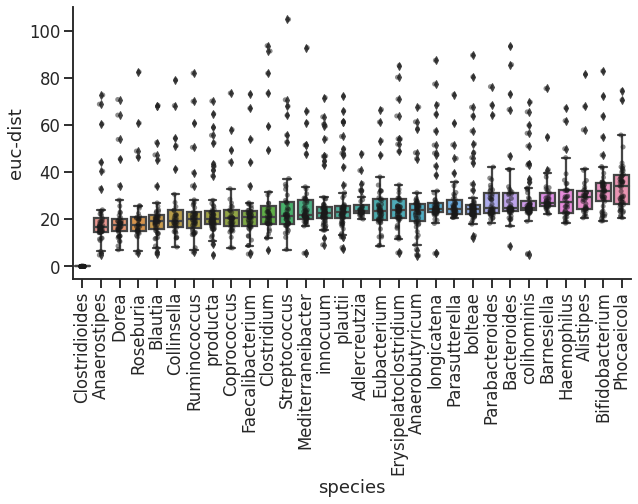

In [2012]:
#+Vanco,+probiotic
counts = dist.groupby(by='species').count()
order=counts.index[(counts>=30)['euc-dist']]
order=dist.groupby(by='species').median().loc[order].sort_values(by='euc-dist').index

#Could try normalizing by growth rate (log subtract) or clr
#Compare Cdiff in absence of probiotic, vs probiotic in presence of cdiff or probiotic in absence of cdiff
plt.figure(figsize=(10,5))
sns.boxplot(x='species',y='euc-dist',data=dist,order=order)
sns.stripplot(x='species',y='euc-dist',data=dist,order=order,color='k',alpha=0.5)
xticks=plt.xticks(rotation=90)

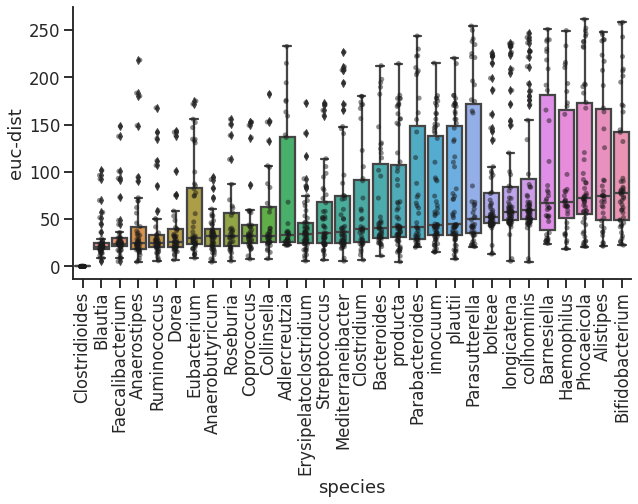

In [2039]:
#+Vanco,+probiotic- growth rate normalized
counts = dist.groupby(by='species').count()
order=counts.index[(counts>=30)['euc-dist']]
order=dist.groupby(by='species').median().loc[order].sort_values(by='euc-dist').index

#Could try normalizing by growth rate (log subtract) or clr
#Compare Cdiff in absence of probiotic, vs probiotic in presence of cdiff or probiotic in absence of cdiff
plt.figure(figsize=(10,5))
sns.boxplot(x='species',y='euc-dist',data=dist,order=order)
sns.stripplot(x='species',y='euc-dist',data=dist,order=order,color='k',alpha=0.5)
xticks=plt.xticks(rotation=90)

Text(0, 0.5, 'Niche distance')

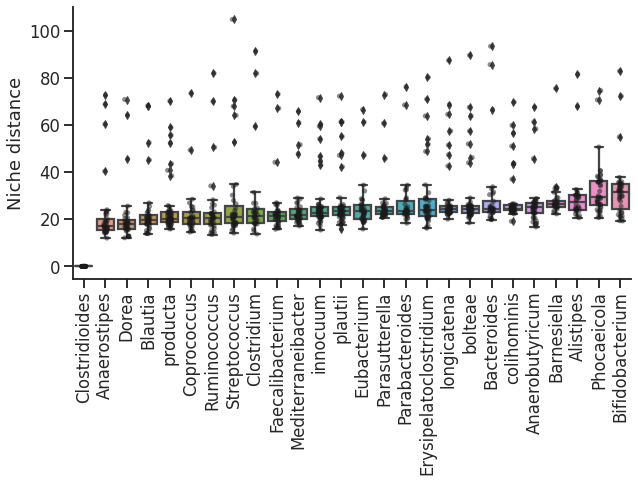

In [2161]:
#+probiotic
counts = dist.groupby(by='species').count()
order=counts.index[(counts>=30)['euc-dist']]
order=dist.groupby(by='species').median().loc[order].sort_values(by='euc-dist').index

#Could try normalizing by growth rate (log subtract) or clr
#Compare Cdiff in absence of probiotic, vs probiotic in presence of cdiff or probiotic in absence of cdiff
plt.figure(figsize=(10,5))
sns.boxplot(x='species',y='euc-dist',data=dist,order=order)
sns.stripplot(x='species',y='euc-dist',data=dist,order=order,color='k',alpha=0.5)
xticks=plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Niche distance')

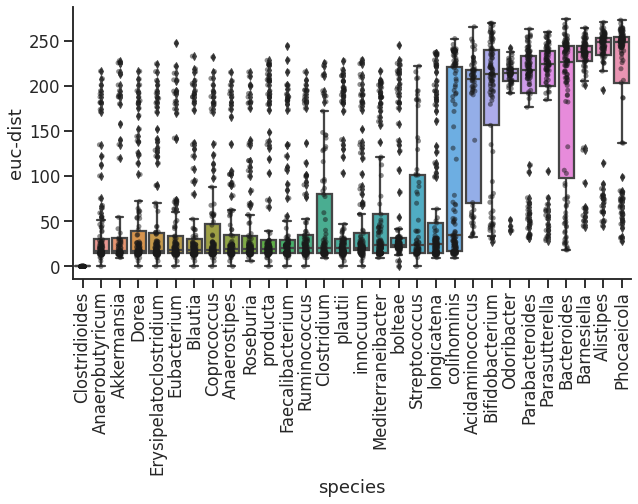

In [2132]:
#+probiotic, growth rate normalized
counts = dist.groupby(by='species').count()
order=counts.index[(counts>=60)['euc-dist']]
order=dist.groupby(by='species').median().loc[order].sort_values(by='euc-dist').index

#Could try normalizing by growth rate (log subtract) or clr
#Compare Cdiff in absence of probiotic, vs probiotic in presence of cdiff or probiotic in absence of cdiff
plt.figure(figsize=(10,5))
sns.boxplot(x='species',y='euc-dist',data=dist,order=order)
sns.stripplot(x='species',y='euc-dist',data=dist,order=order,color='k',alpha=0.5)
xticks=plt.xticks(rotation=90)

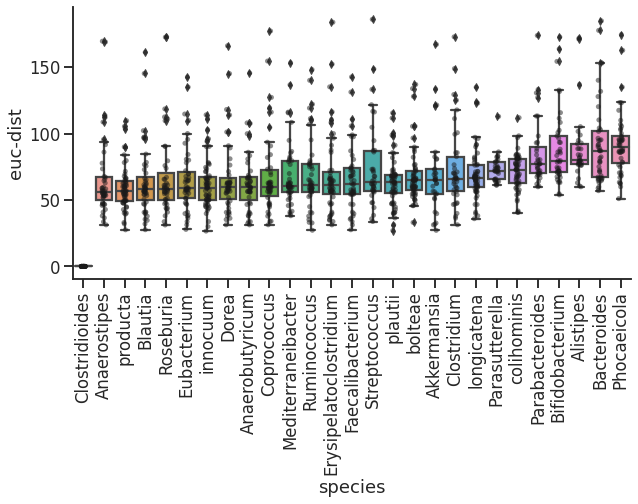

In [2063]:
#+probiotic, clr normalized
counts = dist.groupby(by='species').count()
order=counts.index[(counts>=30)['euc-dist']]
order=dist.groupby(by='species').median().loc[order].sort_values(by='euc-dist').index

#Could try normalizing by growth rate (log subtract) or clr
#Compare Cdiff in absence of probiotic, vs probiotic in presence of cdiff or probiotic in absence of cdiff
plt.figure(figsize=(10,5))
sns.boxplot(x='species',y='euc-dist',data=dist,order=order)
sns.stripplot(x='species',y='euc-dist',data=dist,order=order,color='k',alpha=0.5)
xticks=plt.xticks(rotation=90)

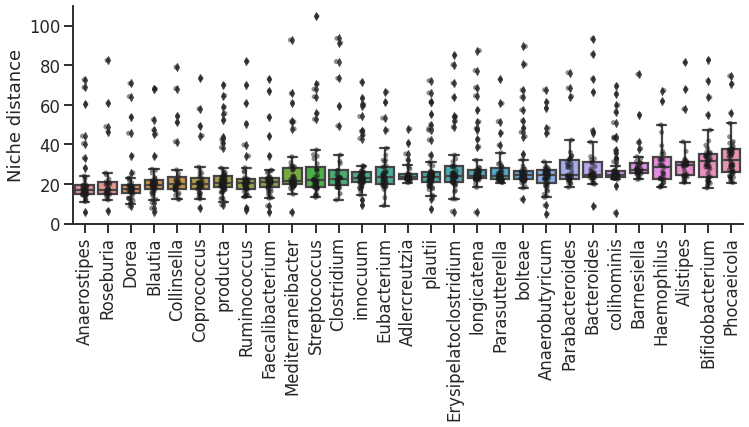

In [2515]:
#+probiotic, clr normalized
counts = dist.groupby(by='species').count()
order=counts.index[(counts>=30)['euc-dist']]
order=dist.groupby(by='species').median().loc[order].sort_values(by='euc-dist').index[1:]

#Could try normalizing by growth rate (log subtract) or clr
#Compare Cdiff in absence of probiotic, vs probiotic in presence of cdiff or probiotic in absence of cdiff
plt.figure(figsize=(12,4))
sns.boxplot(x='species',y='euc-dist',data=dist,order=order)
sns.stripplot(x='species',y='euc-dist',data=dist,order=order,color='k',alpha=0.5)
xticks=plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Niche distance')
plt.savefig('Niche-dist.pdf',bbox_inches='tight')

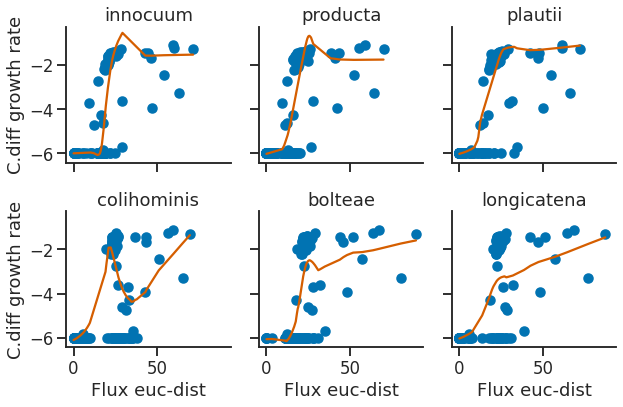

In [2165]:
idx=[i for i in smp_growth.index if 'Clostridioides' in i[1]]
tmp_growth=smp_growth.loc[idx]

fig,ax =plt.subplots(2,3,figsize=(9,6),sharex=True,sharey=True)
k=0
j=0
for species in ['innocuum','producta','plautii','colihominis','bolteae','longicatena']:
    if k==3:
        j=1
    if k%3==0:
        ax[j][k%3].set_ylabel('C.diff growth rate')
    if j ==1:
        ax[j][k%3].set_xlabel('Flux euc-dist')
    tmp_dist=dist[dist.species==species]
    tmp_dist.index=tmp_dist['sample']
    tmp_dist=tmp_dist.loc[[i[0] for i in smp_growth.index]]
    tmp_dist=tmp_dist.drop_duplicates()
    x=tmp_dist['euc-dist'];y=tmp_growth['log_growth']
    lowess = sm.nonparametric.lowess
    fit=lowess(y,x)
   
    ax[j][k%3].scatter(x,y)
    ax[j][k%3].plot(fit[:,0],fit[:,1],color='r')
    #plt.xlabel('Flux euclidean distance')
    #plt.ylabel('C.diff growth rate')
    ax[j][k%3].set_title(species)
    k+=1
plt.tight_layout()
    

Text(0, 0.5, '$log_{10} C. diff$ growth rate')

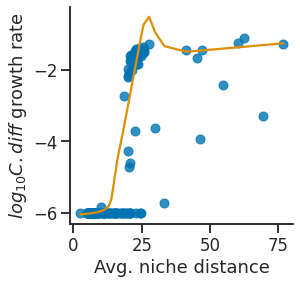

In [2479]:
tmp_dist=dist[dist.species.isin(['innocuum','producta','plautii','colihominis','bolteae','longicatena'])]
tmp_dist.index=tmp_dist['sample']


tmp_dist=tmp_dist.groupby(level=0).mean()
tmp_dist=tmp_dist.loc[[i[0] for i in smp_growth.index]]
tmp_dist=tmp_dist.drop_duplicates()
x=tmp_dist['euc-dist'];y=tmp_growth['log_growth']
lowess = sm.nonparametric.lowess
fit=lowess(y,x)
plt.figure(figsize=(4,4))
sns.regplot(x=x.values,y=y.values,fit_reg=False)
plt.plot(fit[:,0],fit[:,1])
plt.xlabel('Avg. niche distance')
plt.ylabel('$log_{10} C. diff$ growth rate')
#plt.savefig('Probiotic-niche-dist.pdf',bbox_inches='tight')

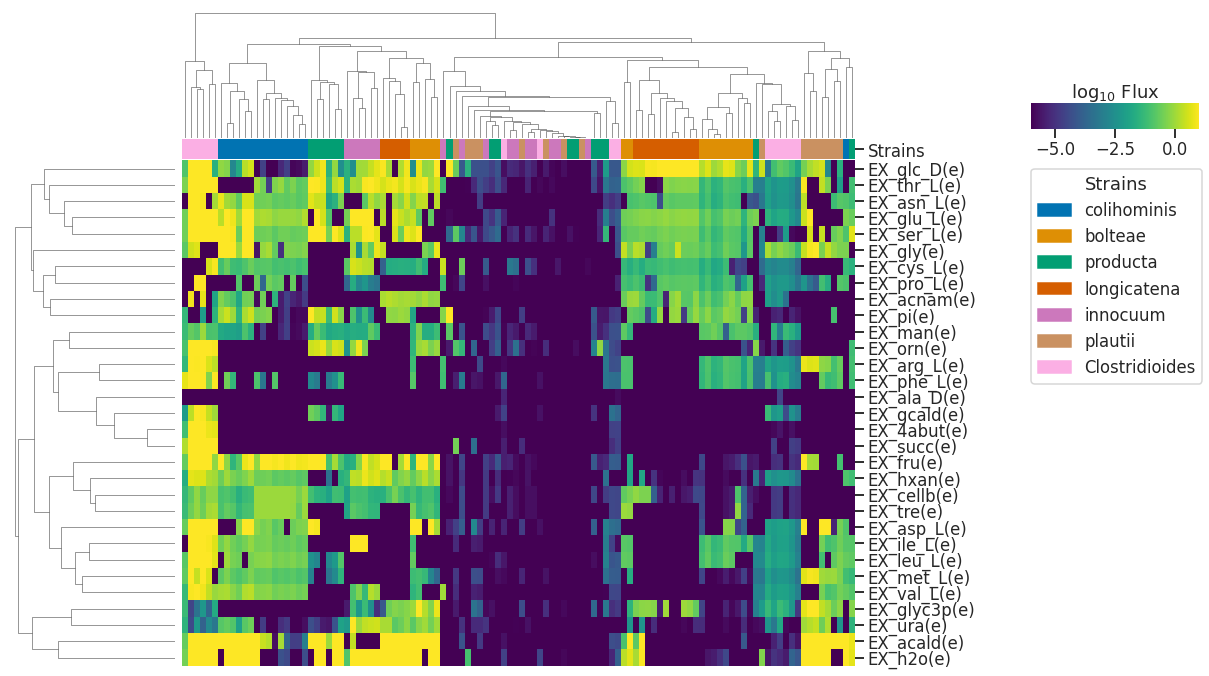

In [2208]:
smps=pd.unique(cdiff_prob[cdiff_prob['cluster'].isin([1])]['sample'].values)
#tmp=strain_import[hits]
#smps=tmp[tmp[tmp>-6].fillna(-6).mean(axis=1)>=-3.5].index.values

col_colors=pd.DataFrame([x[1] for x in strain_import.index],columns=['Strains'])
col_colors.index=strain_import.index
cmap={}
colors=sns.color_palette('colorblind')
i=0
handles = []
for strain in col_colors.Strains.unique():
    cmap[strain]=colors[i]
    patch = mpatches.Patch(color=colors[i],label=strain)
    handles.append(patch)
    i+=1
col_colors.Strains=col_colors.Strains.map(cmap)
kws = dict(cbar_kws=dict( orientation='horizontal'))
clust=sns.clustermap(strain_import.loc[smps,hits].sort_index().T,cmap='viridis',vmin=-6,vmax=1,figsize=(14,14),col_colors=col_colors,yticklabels=1,**kws)
clust.ax_heatmap.set_ylabel('')
clust.ax_heatmap.set_xlabel('')
clust.ax_heatmap.set_xticks([])

#Create custom legend to include in plot 
x0, _y0, _w, _h = clust.cbar_pos
clust.ax_cbar.set_position([1.035, 0.86, clust.ax_row_dendrogram.get_position().width, 0.025])
clust.ax_cbar.set_title('log$_{10}$ Flux')

clust.ax_heatmap.legend(handles=handles,bbox_to_anchor=(1.25,1),loc=2,title='Strains')

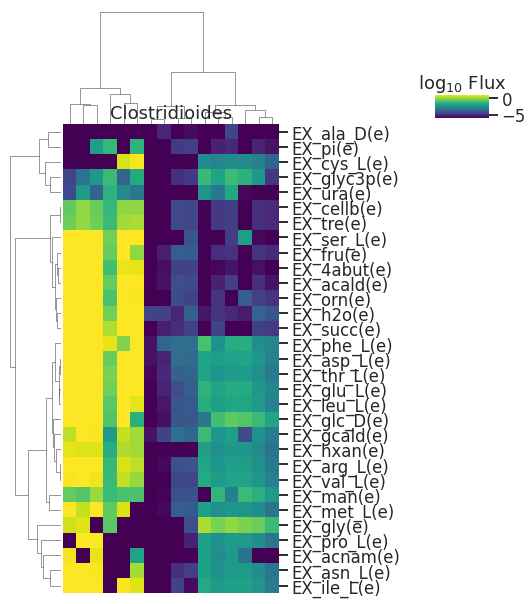

<Figure size 432x288 with 0 Axes>

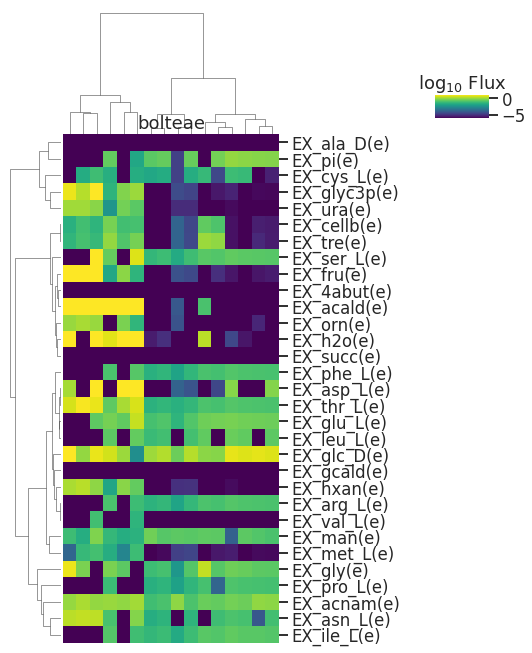

<Figure size 432x288 with 0 Axes>

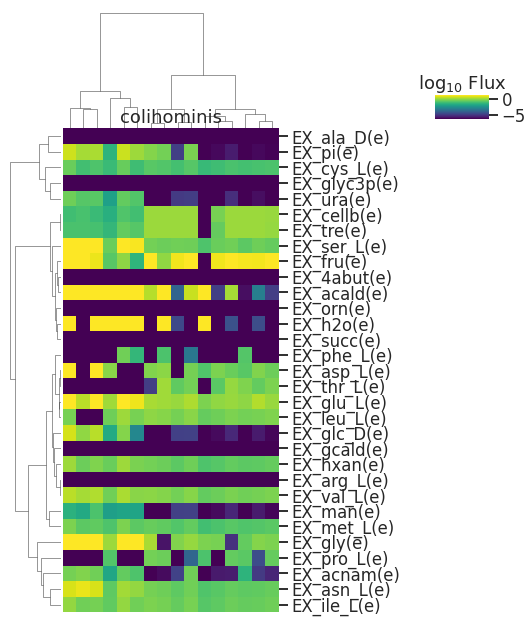

<Figure size 432x288 with 0 Axes>

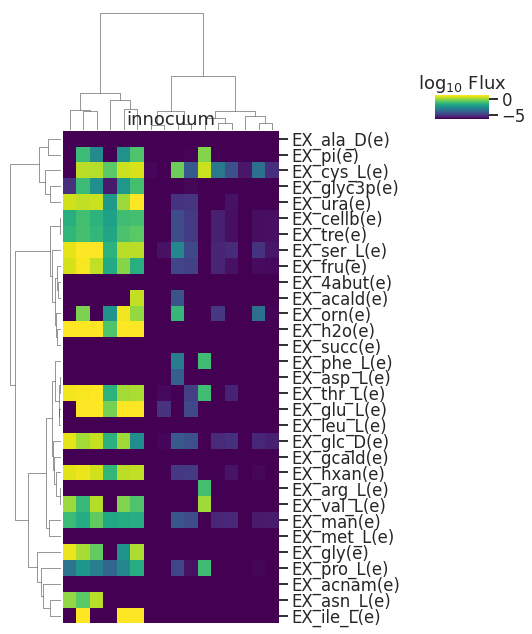

<Figure size 432x288 with 0 Axes>

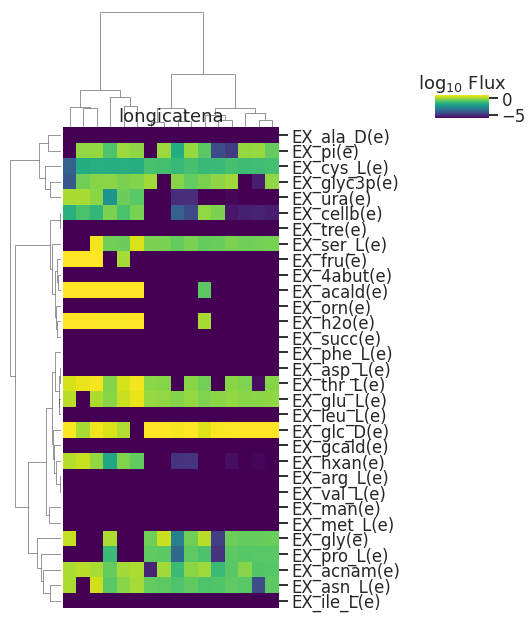

<Figure size 432x288 with 0 Axes>

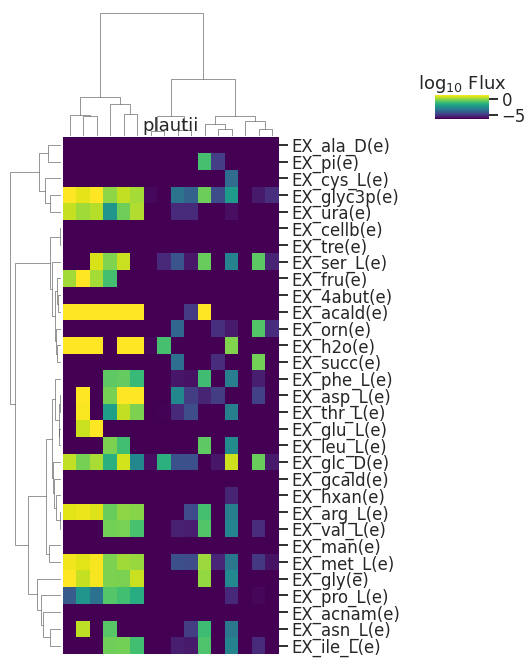

<Figure size 432x288 with 0 Axes>

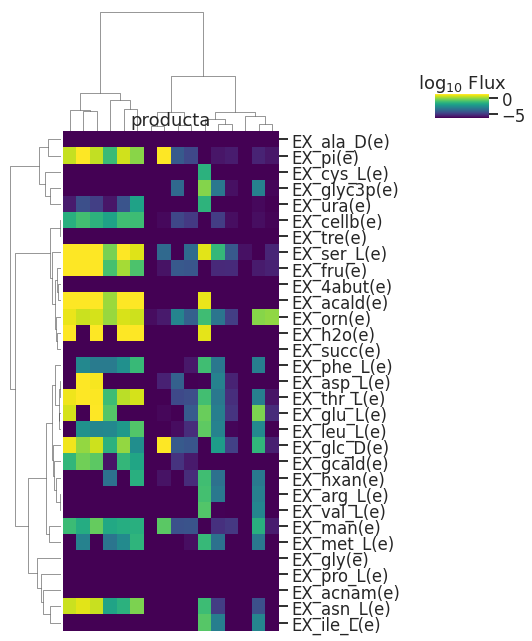

<Figure size 432x288 with 0 Axes>

In [2324]:
smps=pd.unique(cdiff_prob[cdiff_prob['cluster'].isin([1])]['sample'].values)
#tmp=strain_import[hits]
#smps=tmp[tmp[tmp>-6].fillna(-6).mean(axis=1)>=-3.5].index.values
max_d =150
X=strain_import.loc[[(x,'Clostridioides') for x in smps],hits].T
row_linkage = linkage(X, 'ward')
col_linkage = linkage(X.T, 'ward')
for strain,s in strain_import.groupby(level=1):
    clust=sns.clustermap(s.loc[smps,hits].T,cmap='viridis',vmin=-6,vmax=1,figsize=(6,13),yticklabels=1,row_linkage=row_linkage,col_linkage=col_linkage)
    clust.ax_heatmap.set_ylabel('')
    clust.ax_heatmap.set_xlabel('')
    clust.ax_heatmap.set_xticks([])
    clust.ax_heatmap.set_title(strain)
    #Create custom legend to include in plot 
    x0, _y0, _w, _h = clust.cbar_pos
    clust.ax_cbar.set_position([1.035, 0.86, clust.ax_row_dendrogram.get_position().width, 0.025])
    clust.ax_cbar.set_title('log$_{10}$ Flux')
    plt.savefig('Probiotic-Heatmap-%s-v2.pdf'%(strain),bbox_inches='tight')
    plt.show()
    plt.clf()

    

/users/acarr/anaconda3/envs/micom/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


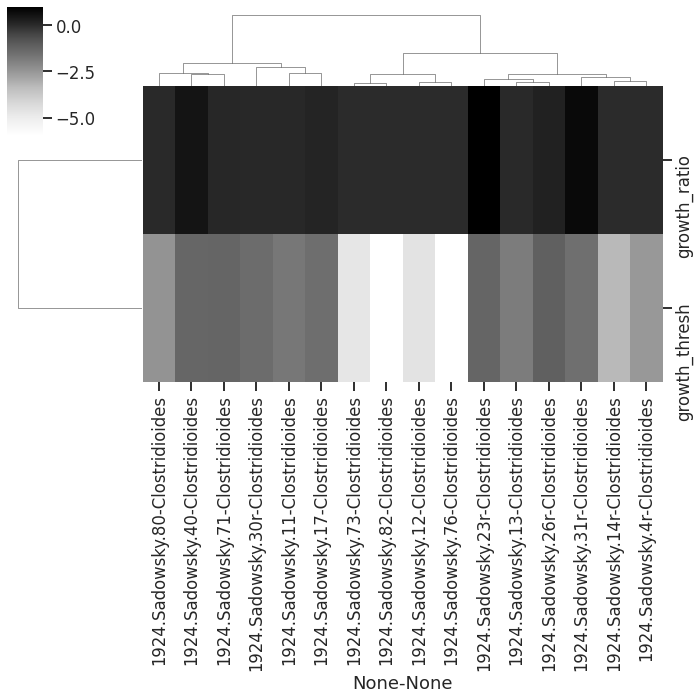

/users/acarr/anaconda3/envs/micom/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


<Figure size 432x288 with 0 Axes>

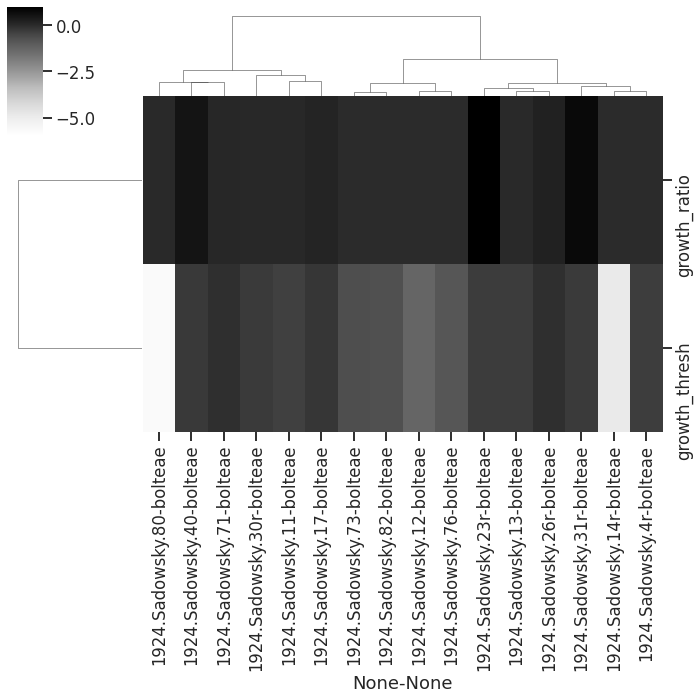

<Figure size 432x288 with 0 Axes>

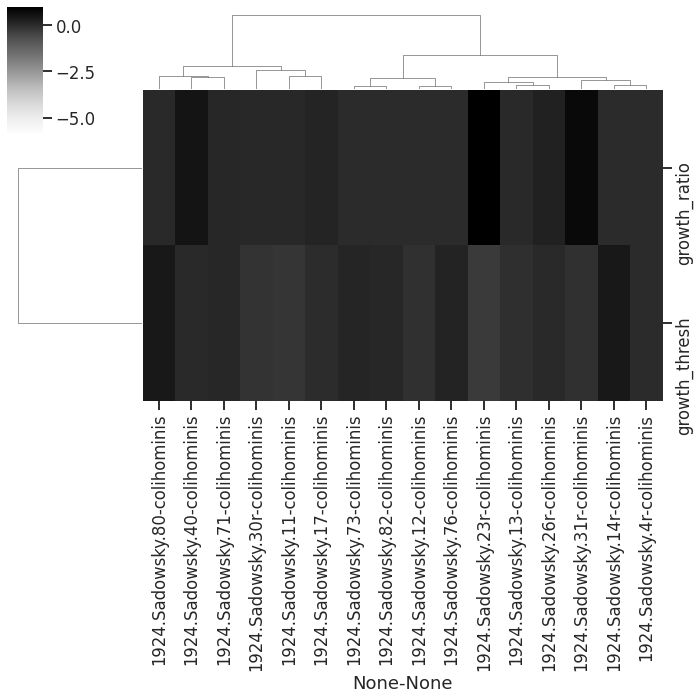

<Figure size 432x288 with 0 Axes>

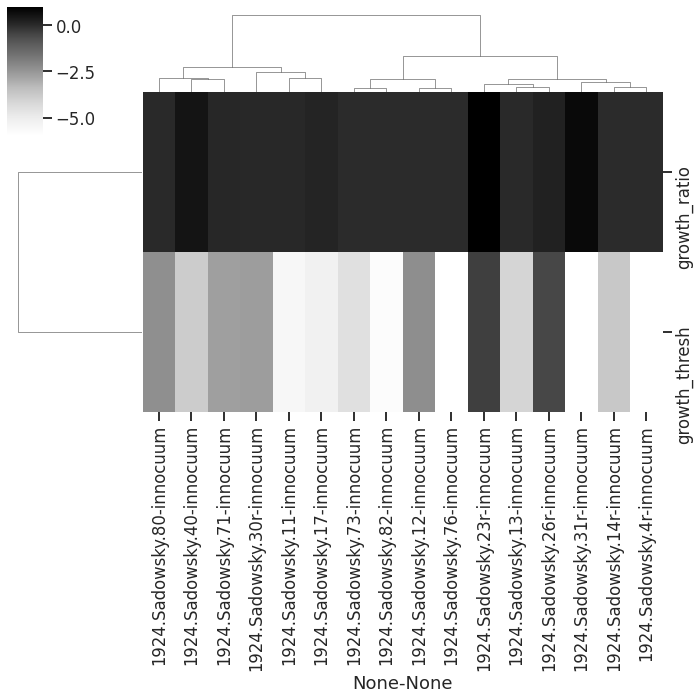

<Figure size 432x288 with 0 Axes>

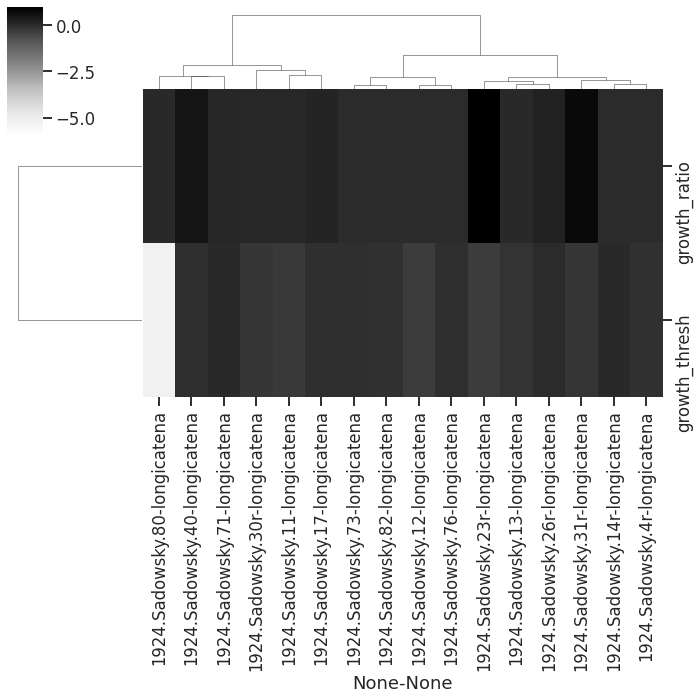

<Figure size 432x288 with 0 Axes>

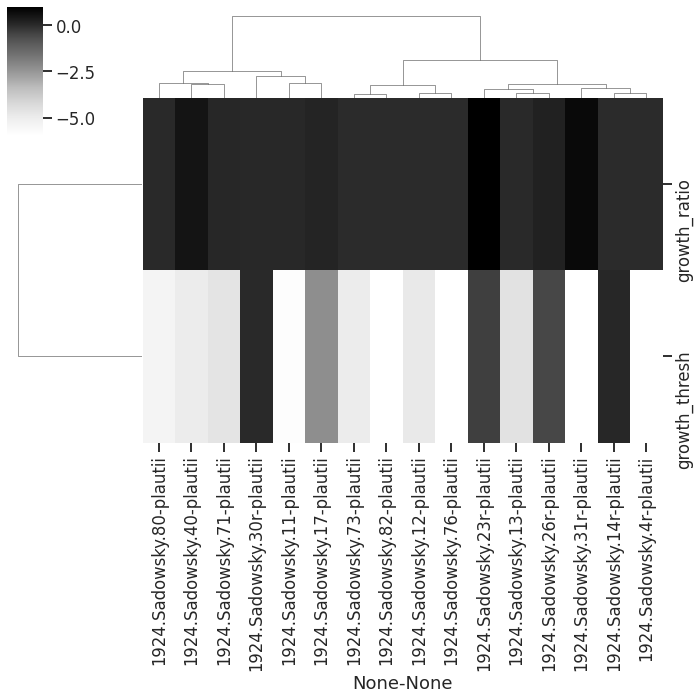

<Figure size 432x288 with 0 Axes>

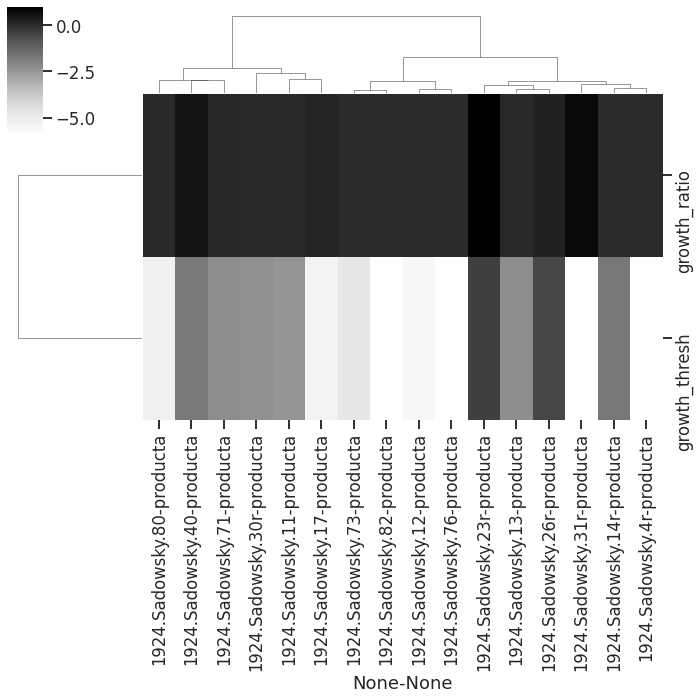

<Figure size 432x288 with 0 Axes>

In [2323]:
for strain,s in strain_import.groupby(level=1):
    if strain == 'Clostridioides':
        colors=prob_strains[(prob_strains['sample'].isin(smps))&(prob_strains.compartments=='producta')]
        colors.index=pd.MultiIndex.from_tuples([(i,strain) for i in colors['sample']])
        colors['growth_thresh']=colors.cdiff_log_growth
        #idx=colors[colors.cdiff_log_growth>=-3].index.values
        #colors.loc[idx,'growth_thresh']=1
    else:
        colors=prob_strains[(prob_strains['sample'].isin(smps))&(prob_strains.compartments==strain)]
        colors.index=pd.MultiIndex.from_tuples([(i,strain) for i in colors['sample']])
        colors['growth_thresh']=colors.log_growth
        #idx=colors[colors.log_growth>=-3].index.values
        #colors.loc[idx,'growth_thresh']=1
    sns.clustermap(colors[['growth_ratio','growth_thresh']].T,cmap='Greys',vmax=-6,vmin=1,col_linkage=col_linkage)
    plt.savefig('strain_colorbar-%s.pdf'%(strain),bbox_inches='tight')
    plt.show()
    plt.clf()

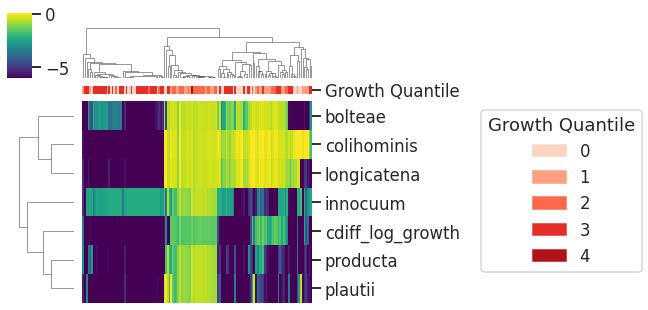

In [1250]:
tmp=prob_strains.pivot(columns='compartments',index=['sample','condition','cdiff_log_growth','growth_ratio','growth_diff'],values='log_growth').reset_index()
tmp=tmp[tmp.growth_ratio<10]
n=5
tmp['Growth Quantile']=pd.qcut(tmp.growth_ratio,n,labels=False)
colors=sns.color_palette('Reds',n)
cmap = {}
i = 0
for group in sorted(tmp['Growth Quantile'].unique()):
    cmap[group] = colors[i]
    i+=1
#Use color dictionary to map color to speces column (provides color of each data point)
col_colors=tmp['Growth Quantile'].copy()
col_colors=col_colors.map(cmap)

clust=sns.clustermap(tmp[strains+['cdiff_log_growth']].T,cmap='viridis',robust=True,figsize=(7,5),col_colors=col_colors,yticklabels=1)
order=[x.get_text() for x in clust.ax_heatmap.get_xticklabels()]
clust.ax_heatmap.set_ylabel('')
clust.ax_heatmap.set_xlabel('')
clust.ax_heatmap.set_xticks([])

#Create custom legend to include in plot 
handles = []
labels = sorted(tmp['Growth Quantile'].unique())
for i in range(len(sorted(labels))):
    patch = mpatches.Patch(color=colors[i],label=labels[i])
    handles.append(patch)  
clust.ax_heatmap.legend(handles=handles,bbox_to_anchor=(1.7,1),loc=2,title='Growth Quantile')


[]

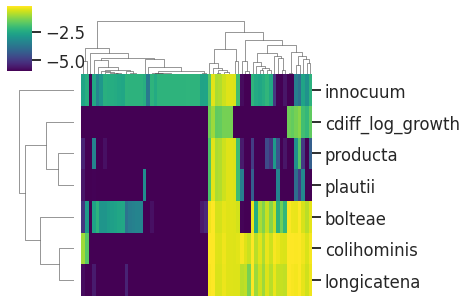

In [1186]:
clust=sns.clustermap(tmp[tmp['Growth Quantile']==2][strains+['cdiff_log_growth']].T,cmap='viridis',robust=True,figsize=(7,5),yticklabels=1)
order=[x.get_text() for x in clust.ax_heatmap.get_xticklabels()]
clust.ax_heatmap.set_ylabel('')
clust.ax_heatmap.set_xlabel('')
clust.ax_heatmap.set_xticks([])


# UMAPS

In [178]:
from umap import UMAP
umap = UMAP()
df=cdiff_import[cdiff_import.dataset=='fmt'].copy()
fit= umap.fit(df)
coord =fit.embedding_
trans2=pd.DataFrame(coord)
trans2.columns=['x','y']
trans2.index=imports.index
trans2.loc[tmp.index,'log_growth']=tmp.log_growth
trans2

x          y  dataset  \
murica  10317.000001067 Brevundimonas      8.634853 -13.712503   murica   
                        Clostridioides    -7.195393  -1.401245   murica   
                        Delftia           -8.436800   3.300290   murica   
                        Sphingobacterium   4.786083 -15.401658   murica   
                        Stenotrophomonas  18.329697  -4.400150   murica   
...                                             ...        ...      ...   
arivale QIRL-2|AKE014   Parasutterella     6.615071 -11.444865  arivale   
                        Phocaeicola        5.332753   4.164639  arivale   
                        Roseburia          3.315702   8.946846  arivale   
                        Ruminococcus      -3.815149  -0.309247  arivale   
                        Streptococcus      5.651167  -2.659073  arivale   

                                                     genus  log_growth  
murica  10317.000001067 Brevundimonas        Brevundimonas         NaN  
                        Clostridioides      Clostridioides   -1.098113  
                        Delftia                    Delftia         NaN  
                        Sphingobacterium  Sphingobacterium         NaN  
                        Stenotrophomonas  Stenotrophomonas         NaN  
...                                                    ...         ...  
arivale QIRL-2|AKE014   Parasutterella      Parasutterella         NaN  
                        Phocaeicola            Phocaeicola         NaN  
                        Roseburia                Roseburia         NaN  
                        Ruminococcus          Ruminococcus         NaN  
                        Streptococcus        Streptococcus         NaN  

[375574 rows x 5 columns]

In [55]:
imports = pd.concat({'murica':murica_import,'alm':alm_import,'fmt':fmt_import,'arivale':arivale_import})
imports = imports.drop('medium',level=2,axis=0)
imports=imports[imports>-6].fillna(-6)
imports

EX_12dgr180(e)  EX_12dgr180_m  \
murica  10317.000001067 Brevundimonas          -6.000000           -6.0   
                        Clostridioides         -2.780344           -6.0   
                        Delftia                -2.033031           -6.0   
                        Sphingobacterium       -6.000000           -6.0   
                        Stenotrophomonas       -6.000000           -6.0   
...                                                  ...            ...   
arivale QIRL-2|AKE014   Parasutterella         -6.000000           -6.0   
                        Phocaeicola            -6.000000           -6.0   
                        Roseburia              -6.000000           -6.0   
                        Ruminococcus           -4.484716           -6.0   
                        Streptococcus          -5.142672           -6.0   

                                          EX_13ppd(e)  EX_13ppd_m  \
murica  10317.000001067 Brevundimonas            -6.0        -6.0   
                        Clostridioides           -6.0        -6.0   
                        Delftia                  -6.0        -6.0   
                        Sphingobacterium         -6.0        -6.0   
                        Stenotrophomonas         -6.0        -6.0   
...                                               ...         ...   
arivale QIRL-2|AKE014   Parasutterella           -6.0        -6.0   
                        Phocaeicola              -6.0        -6.0   
                        Roseburia                -6.0        -6.0   
                        Ruminococcus             -6.0        -6.0   
                        Streptococcus            -6.0        -6.0   

                                          EX_15dap(e)  EX_15dap_m  \
murica  10317.000001067 Brevundimonas            -6.0        -6.0   
                        Clostridioides           -6.0        -6.0   
                        Delftia                  -6.0        -6.0   
                        Sphingobacterium         -6.0        -6.0   
                        Stenotrophomonas         -6.0        -6.0   
...                                               ...         ...   
arivale QIRL-2|AKE014   Parasutterella           -6.0        -6.0   
                        Phocaeicola              -6.0        -6.0   
                        Roseburia                -6.0        -6.0   
                        Ruminococcus             -6.0        -6.0   
                        Streptococcus            -6.0        -6.0   

                                          EX_26dap_M(e)  EX_26dap_M_m  \
murica  10317.000001067 Brevundimonas         -4.382919          -6.0   
                        Clostridioides        -6.000000          -6.0   
                        Delftia               -1.170366          -6.0   
                        Sphingobacterium      -6.000000          -6.0   
                        Stenotrophomonas      -0.896465          -6.0   
...                                                 ...           ...   
arivale QIRL-2|AKE014   Parasutterella        -1.587736          -6.0   
                        Phocaeicola           -2.212593          -6.0   
                        Roseburia             -2.516725          -6.0   
                        Ruminococcus          -3.628399          -6.0   
                        Streptococcus         -5.030870          -6.0   

                                          EX_2ddglcn(e)  EX_2ddglcn_m  ...  \
murica  10317.000001067 Brevundimonas              -6.0          -6.0  ...   
                        Clostridioides             -6.0          -6.0  ...   
                        Delftia                    -6.0          -6.0  ...   
                        Sphingobacterium           -6.0          -6.0  ...   
                        Stenotrophomonas           -6.0          -6.0  ...   
...                                                 ...           ...  ...   
arivale QIRL-2|AKE014   Parasutterella             -6.0     

In [117]:
imports=imports[imports.columns[imports.mean()>=-6]]
imports

EX_12dgr180(e)  EX_12dgr180_m  \
murica  10317.000001067 Brevundimonas          -6.000000           -6.0   
                        Clostridioides         -2.780344           -6.0   
                        Delftia                -2.033031           -6.0   
                        Sphingobacterium       -6.000000           -6.0   
                        Stenotrophomonas       -6.000000           -6.0   
...                                                  ...            ...   
arivale QIRL-2|AKE014   Parasutterella         -6.000000           -6.0   
                        Phocaeicola            -6.000000           -6.0   
                        Roseburia              -6.000000           -6.0   
                        Ruminococcus           -4.484716           -6.0   
                        Streptococcus          -5.142672           -6.0   

                                          EX_13ppd(e)  EX_13ppd_m  \
murica  10317.000001067 Brevundimonas            -6.0        -6.0   
                        Clostridioides           -6.0        -6.0   
                        Delftia                  -6.0        -6.0   
                        Sphingobacterium         -6.0        -6.0   
                        Stenotrophomonas         -6.0        -6.0   
...                                               ...         ...   
arivale QIRL-2|AKE014   Parasutterella           -6.0        -6.0   
                        Phocaeicola              -6.0        -6.0   
                        Roseburia                -6.0        -6.0   
                        Ruminococcus             -6.0        -6.0   
                        Streptococcus            -6.0        -6.0   

                                          EX_15dap(e)  EX_15dap_m  \
murica  10317.000001067 Brevundimonas            -6.0        -6.0   
                        Clostridioides           -6.0        -6.0   
                        Delftia                  -6.0        -6.0   
                        Sphingobacterium         -6.0        -6.0   
                        Stenotrophomonas         -6.0        -6.0   
...                                               ...         ...   
arivale QIRL-2|AKE014   Parasutterella           -6.0        -6.0   
                        Phocaeicola              -6.0        -6.0   
                        Roseburia                -6.0        -6.0   
                        Ruminococcus             -6.0        -6.0   
                        Streptococcus            -6.0        -6.0   

                                          EX_26dap_M(e)  EX_26dap_M_m  \
murica  10317.000001067 Brevundimonas         -4.382919          -6.0   
                        Clostridioides        -6.000000          -6.0   
                        Delftia               -1.170366          -6.0   
                        Sphingobacterium      -6.000000          -6.0   
                        Stenotrophomonas      -0.896465          -6.0   
...                                                 ...           ...   
arivale QIRL-2|AKE014   Parasutterella        -1.587736          -6.0   
                        Phocaeicola           -2.212593          -6.0   
                        Roseburia             -2.516725          -6.0   
                        Ruminococcus          -3.628399          -6.0   
                        Streptococcus         -5.030870          -6.0   

                                          EX_2ddglcn(e)  EX_2ddglcn_m  ...  \
murica  10317.000001067 Brevundimonas              -6.0          -6.0  ...   
                        Clostridioides             -6.0          -6.0  ...   
                        Delftia                    -6.0          -6.0  ...   
                        Sphingobacterium           -6.0          -6.0  ...   
                        Stenotrophomonas           -6.0          -6.0  ...   
...                                                 ...           ...  ...   
arivale QIRL-2|AKE014   Parasutterella             -6.0     

In [72]:
from umap import UMAP
umap = UMAP()
df=imports.copy()
fit= umap.fit(df)
coord =fit.embedding_
trans2=pd.DataFrame(coord)
trans2.columns=['x','y']

In [73]:
tmp=imports.reset_index()
names=['dataset','genus']
i=0
for col in ['level_0','level_2']:
    trans2[names[i]]=tmp[col].values
    i+=1
trans2

x          y  dataset             genus
0        8.634853 -13.712503   murica     Brevundimonas
1       -7.195393  -1.401245   murica    Clostridioides
2       -8.436800   3.300290   murica           Delftia
3        4.786083 -15.401658   murica  Sphingobacterium
4       18.329697  -4.400150   murica  Stenotrophomonas
...           ...        ...      ...               ...
375569   6.615071 -11.444865  arivale    Parasutterella
375570   5.332753   4.164639  arivale       Phocaeicola
375571   3.315702   8.946846  arivale         Roseburia
375572  -3.815149  -0.309247  arivale      Ruminococcus
375573   5.651167  -2.659073  arivale     Streptococcus

[375574 rows x 4 columns]

Text(0, 0.5, 'UMAP2')

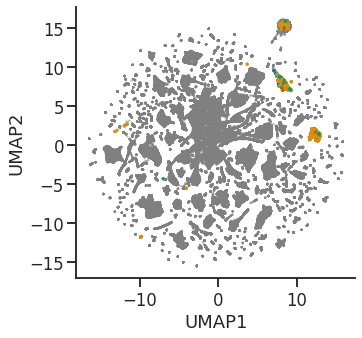

In [143]:
#Light grey for things not Cdiff, color cdiff by log growth rate
#Are there 3 cdiff clusteres?
#Color a few taxa from heatmaps: phocacola, roseburia, etc.
plt.figure(figsize=(5,5))
sns.scatterplot(x='x',y='y',data=trans2[trans2.genus!='Clostridioides'],color='grey',alpha=0.5,s=5,edgecolor = 'none',legend=False)
colors=sns.color_palette('colorblind')
i=0
for dset in ['arivale','murica','alm','fmt']:
    ax=sns.scatterplot(x='x',y='y',data=trans2[(trans2.genus=='Clostridioides')&(trans.dataset==dset)],color=colors[i],s=10,edgecolor = 'none')
    i+=1
#ax.legend(bbox_to_anchor=(1,1))
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

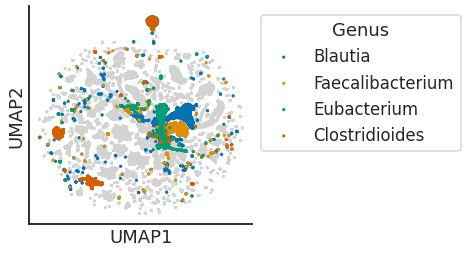

In [2200]:
plt.figure(figsize=(4,4))
#genera=list(res[(res.p_corr<=10**-3)&(abs(res.r)>=.5)].reset_index().sort_values(by='r')['index'].values[::-1])+['Clostridioides']
genera=['Blautia','Faecalibacterium','Eubacterium','Clostridioides']
sns.scatterplot(x='x',y='y',data=trans2[~trans2.genus.isin(genera)],color='lightgrey',alpha=0.5,s=5,edgecolor = 'none',legend=False)
colors=sns.color_palette('colorblind')
i=0
for g in list(genera):
    ax=sns.scatterplot(x='x',y='y',data=trans2[trans2.genus==g],color=colors[i],s=10,edgecolor = 'none',label=g,legend=False)
    i+=1
ax.legend(bbox_to_anchor=(1,1),title='Genus')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.xticks([])
plt.yticks([])
plt.savefig('Global-UMAP-cdiff-genuscorr-v2.png',bbox_inches='tight',dpi=500)
#plt.xlim(9.25,11)
#plt.ylim(16,18)

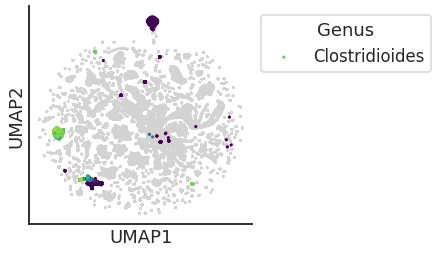

In [2199]:
plt.figure(figsize=(4,4))
#genera=list(res[(res.p_corr<=10**-3)&(abs(res.r)>=.5)].reset_index().sort_values(by='r')['index'].values[::-1])+['Clostridioides']
genera=['Clostridioides']
sns.scatterplot(x='x',y='y',data=trans2[~trans2.genus.isin(genera)],color='lightgrey',alpha=0.5,s=5,edgecolor = 'none',legend=False)
colors=sns.color_palette('colorblind')
i=0
for g in list(genera):
    tmp=trans2[trans2.genus==g].dropna()
    idx=tmp[tmp.log_growth<-6].index.values
    tmp.loc[idx,'log_growth']=-6
    
    ax=sns.scatterplot(x='x',y='y',data=tmp,hue='log_growth',palette='viridis',vmin=-6,vmax=1,s=10,edgecolor = 'none',label=g,legend=False)
    i+=1
ax.legend(bbox_to_anchor=(1,1),title='Genus')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.xticks([])
plt.yticks([])
plt.savefig('Global-UMAP-cdiff-growth.png',bbox_inches='tight',dpi=500)
#plt.xlim(9.25,11)
#plt.ylim(16,18)

/users/acarr/anaconda3/envs/micom/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


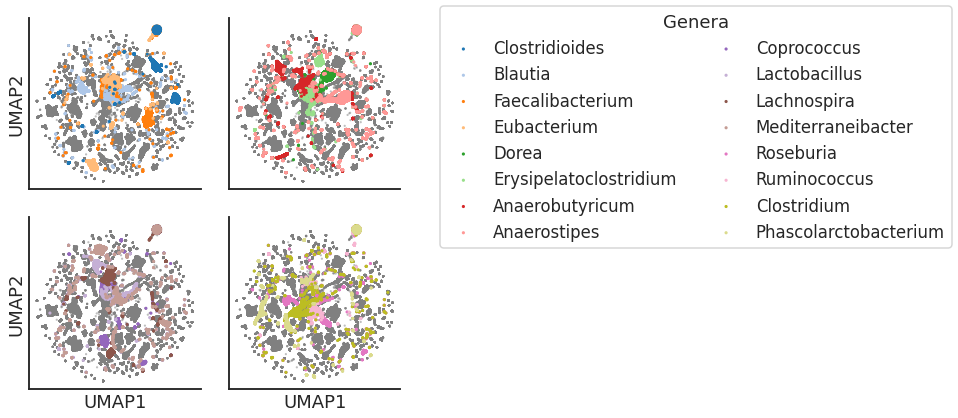

In [289]:
genera=['Clostridioides']+list(res[(res.p_corr<=10**-3)&(abs(res.r)>=.3)].reset_index().sort_values(by='r')['index'].values[::-1][:15])
fig,ax=plt.subplots(2,2,figsize=(6,6),sharex=True,sharey=True)
k=0
handles=[]
labels=[]
for i in range(2):
    for j in range(2):
        for g in range(k,k+4):
            if g < len(genera):
                if genera[g]=='Clostridioides':
                    
                    sns.scatterplot(x='x',y='y',data=trans2[trans2.genus==genera[g]],color=colors[g],s=10,edgecolor = 'none',ax=ax[i][j],label=genera[g],zorder=2)
                else:
                    sns.scatterplot(x='x',y='y',data=trans2[trans2.genus==genera[g]],color=colors[g],s=10,edgecolor = 'none',ax=ax[i][j],label=genera[g],zorder=1)
        h,l=ax[i][j].get_legend_handles_labels()
        ax[i][j].get_legend().remove()
        handles+=h
        labels+=l
        k+=4
        if (i,j) == (0,0) or (i,j) == (1,0):
            ax[i][j].set_ylabel('UMAP2')
        if i == 1:
            ax[i][j].set_xlabel('UMAP1')
ax[i][j].set_xticks([])
ax[i][j].set_yticks([])
fig.legend(handles,labels=labels,ncol=2,title='Genera',bbox_to_anchor=(2.25,1))

for i in range(2):
    for j in range(2):
        sns.scatterplot(x='x',y='y',data=trans2,color='grey',alpha=0.5,s=5,edgecolor = 'none',legend=False,ax=ax[i][j],label=None,zorder=0)
plt.tight_layout()
plt.savefig('genera-UMAP.png',dpi=500,bbox_inches='tight')

In [59]:
from umap import UMAP
umap = UMAP()
df=cdiff_import.loc[:,hits]
fit= umap.fit(df)
coord =fit.embedding_
trans=pd.DataFrame(coord)
trans.columns=['x','y']

In [60]:
trans['dataset']=cdiff_import['dataset'].values
trans['log_growth']=cdiff_import['log_growth'].values
trans.loc[trans.index[trans['log_growth']<-6],'log_growth']=-6
trans['EX_succ(e)']=cdiff_import['EX_succ(e)'].values
trans.loc[trans.index[trans['EX_succ(e)']<-6],'EX_succ(e)']=-6

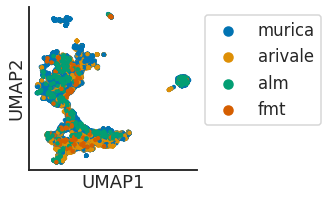

In [61]:
colors=sns.color_palette('colorblind')
plt.figure(figsize=(3,3))
tmp = trans[trans.dataset.isin(['arivale','murica'])]
sns.scatterplot(x='x',y='y',data=tmp.sample(frac=1),hue='dataset',s=20,edgecolor = 'none',palette=colors[:2])
tmp = trans[~trans.dataset.isin(['arivale','murica'])]
sns.scatterplot(x='x',y='y',data=tmp.sample(frac=1),hue='dataset',s=20,edgecolor = 'none',palette=colors[2:4])
plt.legend(bbox_to_anchor=(1,1))
plt.xticks([])
plt.yticks([])
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.savefig('Cdiff-import-UMAP-v2.pdf',bbox_inches='tight')         

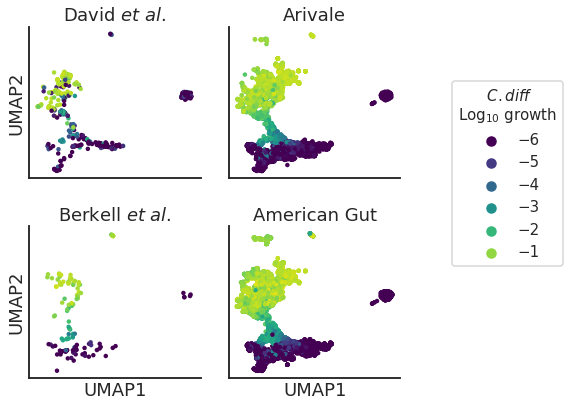

In [206]:
#color fmt data set by heatmap clusters as a sperate plot
#try building heatmap that can cluster all data then draw ellipse for clusters
fig,ax=plt.subplots(2,2,figsize=(6,6),sharex=True,sharey=True)
i=0
j=0
titles={'alm':'David $\it{et}$ $\it{al.}$','arivale':'Arivale','fmt':'Berkell $\it{et}$ $\it{al.}$','murica':'American Gut'}
for index,df in trans.groupby(by='dataset'):
    ax[j][i%2].set_title(titles[index])
    ax[j][i%2].set_xticks([])
    ax[j][i%2].set_yticks([])
    if i == 0 and j == 0:
        ax[j][i%2].set_ylabel('UMAP2')
        sns.scatterplot(x='x',y='y',data=df,hue='log_growth',hue_norm = (-6,0), palette='viridis',ax=ax[j][i%2],s=20,edgecolor = 'none')
        ax[j][i%2].legend().set_visible(False)
        fig.legend(bbox_to_anchor=(1.35,.8),title='      $C. diff$ \nLog$_{10}$ growth',prop={'size': 15},title_fontsize=15)
    else:
        sns.scatterplot(x='x',y='y',data=df,hue='log_growth',hue_norm = (-6,0), palette='viridis',ax=ax[j][i%2],legend=False,s=20,edgecolor = 'none')
    i+=1
    if i%2 == 0 and i != 0 and j ==0:
        j+=1
        ax[j][i%2].set_ylabel('UMAP2')
    if j == 1:
        ax[j][i%2].set_xlabel('UMAP1')
    
    
plt.tight_layout()
#plt.savefig('Cdiff-import-UMAP.png',bbox_inches='tight',dpi=500)

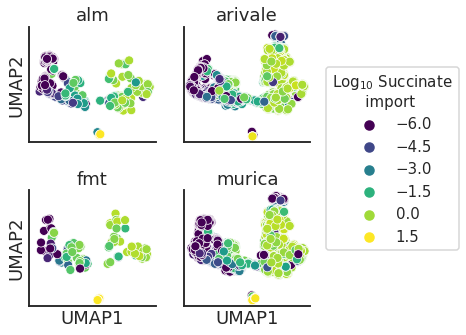

In [213]:
fig,ax=plt.subplots(2,2,figsize=(4.75,5),sharex=True,sharey=True)
i=0
j=0
#titles={'alm':,'arivale':,'fmt':,'murica':}
for index,df in trans.groupby(by='dataset'):
    ax[j][i%2].set_title(index)
    ax[j][i%2].set_xticks([])
    ax[j][i%2].set_yticks([])
    if i == 0 and j == 0:
        ax[j][i%2].set_ylabel('UMAP2')
        sns.scatterplot(x='x',y='y',data=df,hue='EX_succ(e)',hue_norm = (-6,1), palette='viridis',ax=ax[j][i%2])
        ax[j][i%2].legend().set_visible(False)
        fig.legend(bbox_to_anchor=(1.4,.8),title='Log$_{10}$ Succinate\n       import',prop={'size': 15},title_fontsize=15)
    else:
        sns.scatterplot(x='x',y='y',data=df,hue='EX_succ(e)',hue_norm = (-6,1), palette='viridis',ax=ax[j][i%2],legend=False)
    i+=1
    if i%2 == 0 and i != 0 and j ==0:
        j+=1
        ax[j][i%2].set_ylabel('UMAP2')
    if j == 1:
        ax[j][i%2].set_xlabel('UMAP1')
    
    
plt.tight_layout()